In [13]:

import os
import sys
import math
import json
import shutil
import random
import numpy as np
from copy import copy
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
torch.multiprocessing.set_sharing_strategy("file_system")
torch.backends.cudnn.deterministic = True

%load_ext autoreload
%autoreload 2

## 1. Training

We will use a `Trainer` class to perform the training and validation experiments. It requires a configuration file where all training and experiment parameters are defined in hierarchical structure. The configuration is usually a `.yaml` file which is converted to hierarchical configurations using [Hydra](https://hydra.cc/). The default configurations is specified in `config/base.yaml`.

#### Initialization

The initialization of the Trainer clas will create a model for training based on the network specified in the `.yaml` file, define loss function prepare an output directory `<cfg.exp.log_dir>/<exp_name>`, to save model checkpoints, and logs training and prediction outputs. If you don't want to log anything, you can set the parameter `train.debug` of the hydra config to `False`. To override the default values using class indexing, for instance, to change the `batch_size`, use `train.batch_size=32`.


In [4]:
from omegaconf import OmegaConf
from trainer import Trainer

cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))
print(OmegaConf.to_yaml(cfg))

trainer = Trainer(cfg, exp_name='exp1_training')
print(trainer.network)
print("Training parameters:", trainer.num_params)

net:
  type: unet
  input_dim: 1
  hidden_dim: 512
  detection: true
rng:
  seed: 42
  torch_seed: 42
optim:
  lr: 0.0003
  lr_min: 1.0e-06
  lr_scheduler: reduceonplateau
  lr_patience: 1
  lr_reduce_factor: 0.9
  lr_monitor: test/loss
  lr_mode: min
  lr_adjust: false
  lr_adjust_rule: ''
  weight_decay: 0.01
  weight_decay_end: 0.1
  clip_grad_norm: 1.5
loss:
  cls_bce:
    weight: 1
    learn_weight: false
    class_weights: null
    label_smoothing: 0.0
  det_bce:
    weight: 1
    learn_weight: false
    class_weights: null
    label_smoothing: 0.0
data:
  data_dir: ../data/dalpha
  label_dir: ../data/labels
  data_url: s3://mast/level2/shots
  train_samples: 20
  val_samples: 100
  context_len: 512
  train_split: 0.8
  n_folds: 1
  curr_fold: 0
  n_classes: 3
  class_types:
  - NONE
  - Type I
  - Type II
  class_balance: null
train:
  epochs: 1000
  warmup_epochs: 0
  batch_size: 16
  num_workers: 16
  prefetch: false
  preprocess: false
  gpu: 0
  ddp: false
  dist_run: false


#### Prepare data for training and evaluation

Next, we obtain the list of shots ids with available labels from the `data.label_dir`.

In [14]:
from dataset.datasets import split_data
from utils.misc import get_files_in_dir

data = [f.split('.')[0] for f in get_files_in_dir(cfg.data.label_dir, file_end='.csv')]

train_shots, test_shots = split_data(data, train_split=cfg.data.train_split, seed=cfg.rng.seed)
print(f"{data=}\n{train_shots=}\n{test_shots=}")

data=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465']
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']
test_shots=['30464', '30465']


#### Train function
Next we call the `train` function of the `Trainer` with training and test shots ID. The `train` function initialize dataloders, create model checkpointer for saving model with best metric and schedulers for adjusting learning rate. Note that, the training will monitor the metric specified in `train.monitor` to save the model checkpoints depending upon the monitor mode e.g. 'min' for 'loss' and 'max' for 'accuracy'.  The trainer utilize EarlyStopping method to stop the training if  metric specified in the `train.early_stopping_metric` doesn't improve for `train.early_stop_patience` steps.  

The trainer will create a model for training based on the network specified in the config file, train the network and save the network states in a output directory `<cfg.exp.log_dir>/<exp_name>`,  where in addition to model checkpoints, logs and any prediction outputs will be saved. If you don't want to log anything, you can set the parameter `train.debug` of the hydra config to `False`.

Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 1/1 [00:01<00:00,  1.03s/it, , elm_cls_loss:    1.121, elm_det_loss:    0.630, loss:    1.751]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.629, loss:    1.749]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.627, loss:    1.747]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.626, loss:    1.745]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.625, loss:    1.744]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  9.02it/s, test_loss: 1.741,                             test_cls_acc: 0.200, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49408 | 1792 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/ipykernel/ipkernel.py", li

Modelcheckpoint: test/loss improved from inf to 1.741453.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.741453.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.624, loss:    1.742]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.622, loss:    1.740]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.621, loss:    1.738]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.620, loss:    1.736]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.618, loss:    1.734]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.45it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49386 | 1814 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.741453 to 1.731175.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.741453 to 1.731175.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.616, loss:    1.732]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.614, loss:    1.728]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.611, loss:    1.724]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.606, loss:    1.718]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.599, loss:    1.708]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.72it/s, test_loss: 1.693,                             test_cls_acc: 0.200, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49362 | 1838 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.64it/s, test_loss: 1.693,                             test_cls_acc: 0.200, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.731175 to 1.692720.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.731175 to 1.692720.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.585, loss:    1.693]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.559, loss:    1.668]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.512, loss:    1.621]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.436, loss:    1.549]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.325, loss:    1.446]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.49it/s, test_loss: 1.342,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49360 | 1840 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.02it/s, test_loss: 1.342,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.692720 to 1.341962.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.692720 to 1.341962.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.156, elm_det_loss:    0.220, loss:    1.376]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.181, elm_det_loss:    0.205, loss:    1.386]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.290, elm_det_loss:    0.255, loss:    1.546]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    1.203, elm_det_loss:    0.287, loss:    1.490]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.155, elm_det_loss:    0.272, loss:    1.428]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.75it/s, test_loss: 1.252,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49394 | 1806 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.74it/s, test_loss: 1.252,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.341962 to 1.251847.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.341962 to 1.251847.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.102, elm_det_loss:    0.227, loss:    1.330]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.086, elm_det_loss:    0.194, loss:    1.280]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.196, loss:    1.274]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.225, loss:    1.306]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.237, loss:    1.315]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 18.17it/s, test_loss: 1.287,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49258 | 1942 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 1.287,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.251847.
Early Stopping: test/loss didn't improve from 1.251847. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.230, loss:    1.300]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.210, loss:    1.278]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.183, loss:    1.243]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.180, loss:    1.260]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.090, elm_det_loss:    0.189, loss:    1.279]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, test_loss: 1.222,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49478 | 1722 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.10it/s, test_loss: 1.222,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.251847 to 1.221970.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.251847 to 1.221970.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.194, loss:    1.273]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.182, loss:    1.253]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.180, loss:    1.237]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.178, loss:    1.239]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.190, loss:    1.252]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.93it/s, test_loss: 1.226,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49482 | 1718 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.226,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 1.221970.
Early Stopping: test/loss didn't improve from 1.221970. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.192, loss:    1.248]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.184, loss:    1.240]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.180, loss:    1.233]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.176, loss:    1.247]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.179, loss:    1.244]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.61it/s, test_loss: 1.214,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49365 | 1835 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.214,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.221970 to 1.213897.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.221970 to 1.213897.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.185, loss:    1.242]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.179, loss:    1.236]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.175, loss:    1.241]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.174, loss:    1.232]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.181, loss:    1.245]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.86it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49470 | 1730 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.19it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.213897 to 1.210141.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.213897 to 1.210141.
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.176, loss:    1.244]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.180, loss:    1.239]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.177, loss:    1.233]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.173, loss:    1.228]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.170, loss:    1.229]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.37it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49534 | 1666 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.210141 to 1.197080.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.210141 to 1.197080.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.176, loss:    1.233]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.176, loss:    1.242]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.173, loss:    1.235]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.169, loss:    1.226]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.168, loss:    1.236]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.58it/s, test_loss: 1.202,                             test_cls_acc: 0.400, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49527 | 1673 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.83it/s, test_loss: 1.202,                             test_cls_acc: 0.400, test_det_acc: 0.967]


Modelcheckpoint: test/loss didn't improved from 1.197080.
Early Stopping: test/loss didn't improve from 1.197080. Early stopping counter: 1/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.172, loss:    1.232]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.171, loss:    1.234]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.169, loss:    1.238]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.171, loss:    1.233]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.169, loss:    1.230]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.85it/s, test_loss: 1.206,                             test_cls_acc: 0.410, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.468 |    0.342 | 0.208 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49328 | 1872 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.18it/s, test_loss: 1.206,                             test_cls_acc: 0.410, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.197080.
Early Stopping: test/loss didn't improve from 1.197080. Early stopping counter: 2/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.172, loss:    1.230]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.168, loss:    1.227]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.169, loss:    1.229]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.165, loss:    1.226]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.164, loss:    1.223]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.40it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49314 | 1886 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.197080.
Early Stopping: test/loss didn't improve from 1.197080. Early stopping counter: 3/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.166, loss:    1.221]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.163, loss:    1.220]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.162, loss:    1.221]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.163, loss:    1.224]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.162, loss:    1.222]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.07it/s, test_loss: 1.194,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49410 | 1790 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.64it/s, test_loss: 1.194,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.197080 to 1.194448.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.197080 to 1.194448.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.162, loss:    1.214]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.162, loss:    1.224]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.158, loss:    1.219]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.159, loss:    1.215]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.154, loss:    1.206]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.49it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.961]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49187 | 2013 |      0.961 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.961]


Modelcheckpoint: test/loss didn't improved from 1.194448.
Early Stopping: test/loss didn't improve from 1.194448. Early stopping counter: 1/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.156, loss:    1.216]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.150, loss:    1.219]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.156, loss:    1.213]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.146, loss:    1.201]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.149, loss:    1.203]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.91it/s, test_loss: 1.182,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.299 |    0.333 | 0.204 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49290 | 1910 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.21it/s, test_loss: 1.182,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from 1.194448 to 1.181575.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.194448 to 1.181575.
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.142, loss:    1.193]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.141, loss:    1.199]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.144, loss:    1.201]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.134, loss:    1.197]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.136, loss:    1.193]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.36it/s, test_loss: 1.160,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49397 | 1803 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.78it/s, test_loss: 1.160,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.181575 to 1.159755.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.181575 to 1.159755.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.131, loss:    1.185]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.129, loss:    1.189]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.126, loss:    1.190]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.126, loss:    1.190]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.119, loss:    1.177]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.50it/s, test_loss: 1.135,                             test_cls_acc: 0.400, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49600 | 1600 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 1.135,                             test_cls_acc: 0.400, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 1.159755 to 1.135308.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.159755 to 1.135308.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.114, loss:    1.171]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.115, loss:    1.172]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.110, loss:    1.167]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.101, loss:    1.148]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.107, loss:    1.160]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.75it/s, test_loss: 1.137,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49361 | 1839 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.13it/s, test_loss: 1.137,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.135308.
Early Stopping: test/loss didn't improve from 1.135308. Early stopping counter: 1/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.099, loss:    1.161]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.110, loss:    1.159]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.098, loss:    1.152]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.095, loss:    1.151]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.094, loss:    1.156]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.47it/s, test_loss: 1.125,                             test_cls_acc: 0.400, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49584 | 1616 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 1.125,                             test_cls_acc: 0.400, test_det_acc: 0.968]


Modelcheckpoint: test/loss improved from 1.135308 to 1.124707.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.135308 to 1.124707.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.092, loss:    1.155]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.099, loss:    1.142]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.092, loss:    1.143]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.081, loss:    1.134]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.078, loss:    1.148]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.29it/s, test_loss: 1.111,                             test_cls_acc: 0.400, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49559 | 1641 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 1.111,                             test_cls_acc: 0.400, test_det_acc: 0.968]


Modelcheckpoint: test/loss improved from 1.124707 to 1.110783.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.124707 to 1.110783.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.079, loss:    1.136]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.078, loss:    1.127]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.073, loss:    1.125]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.071, loss:    1.126]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.070, loss:    1.124]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.96it/s, test_loss: 1.108,                             test_cls_acc: 0.400, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49572 | 1628 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.108,                             test_cls_acc: 0.400, test_det_acc: 0.968]


Modelcheckpoint: test/loss improved from 1.110783 to 1.107588.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.110783 to 1.107588.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.067, loss:    1.111]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.070, loss:    1.119]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.067, loss:    1.121]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.064, loss:    1.117]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.065, loss:    1.121]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.60it/s, test_loss: 1.104,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49409 | 1791 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.08it/s, test_loss: 1.104,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.107588 to 1.103814.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.107588 to 1.103814.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.061, loss:    1.111]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.063, loss:    1.113]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.059, loss:    1.112]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.061, loss:    1.102]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.058, loss:    1.101]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.26it/s, test_loss: 1.091,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49246 | 1954 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 1.091,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.103814 to 1.091403.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.103814 to 1.091403.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.058, loss:    1.111]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.059, loss:    1.110]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.058, loss:    1.097]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.059, loss:    1.109]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.058, loss:    1.086]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.48it/s, test_loss: 1.079,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49446 | 1754 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.079,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.091403 to 1.079048.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.091403 to 1.079048.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.036, elm_det_loss:    0.056, loss:    1.092]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.055, loss:    1.096]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.056, loss:    1.082]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.027, elm_det_loss:    0.058, loss:    1.085]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.054, loss:    1.081]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.77it/s, test_loss: 1.082,                             test_cls_acc: 0.400, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49587 | 1613 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.04it/s, test_loss: 1.082,                             test_cls_acc: 0.400, test_det_acc: 0.968]


Modelcheckpoint: test/loss didn't improved from 1.079048.
Early Stopping: test/loss didn't improve from 1.079048. Early stopping counter: 1/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.054, loss:    1.080]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    1.036, elm_det_loss:    0.058, loss:    1.094]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.055, loss:    1.078]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    1.016, elm_det_loss:    0.056, loss:    1.071]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.020, elm_det_loss:    0.054, loss:    1.075]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.68it/s, test_loss: 1.064,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49324 | 1876 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 1.064,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from 1.079048 to 1.064354.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.079048 to 1.064354.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.037, elm_det_loss:    0.054, loss:    1.090]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.011, elm_det_loss:    0.053, loss:    1.064]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.004, elm_det_loss:    0.053, loss:    1.056]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.006, elm_det_loss:    0.054, loss:    1.059]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.992, elm_det_loss:    0.053, loss:    1.045]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.28it/s, test_loss: 1.069,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49417 | 1783 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.069,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.064354.
Early Stopping: test/loss didn't improve from 1.064354. Early stopping counter: 1/10
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.014, elm_det_loss:    0.055, loss:    1.068]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.998, elm_det_loss:    0.054, loss:    1.051]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.980, elm_det_loss:    0.052, loss:    1.032]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.995, elm_det_loss:    0.054, loss:    1.049]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.972, elm_det_loss:    0.053, loss:    1.025]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.09it/s, test_loss: 1.090,                             test_cls_acc: 0.420, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   42 |   58 |  142 |   58 |      0.613 |       0.469 |     0.35 | 0.225 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49488 | 1712 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 1.090,                             test_cls_acc: 0.420, test_det_acc: 0.967]


Modelcheckpoint: test/loss didn't improved from 1.064354.
Early Stopping: test/loss didn't improve from 1.064354. Early stopping counter: 2/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.954, elm_det_loss:    0.054, loss:    1.008]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.973, elm_det_loss:    0.053, loss:    1.026]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.958, elm_det_loss:    0.055, loss:    1.013]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.946, elm_det_loss:    0.055, loss:    1.000]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.944, elm_det_loss:    0.053, loss:    0.997]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.02it/s, test_loss: 1.056,                             test_cls_acc: 0.410, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.301 |    0.342 | 0.242 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49344 | 1856 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.05it/s, test_loss: 1.056,                             test_cls_acc: 0.410, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.064354 to 1.055709.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.064354 to 1.055709.
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.946, elm_det_loss:    0.053, loss:    0.998]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.933, elm_det_loss:    0.049, loss:    0.982]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.941, elm_det_loss:    0.055, loss:    0.995]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.889, elm_det_loss:    0.050, loss:    0.940]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.866, elm_det_loss:    0.054, loss:    0.920]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.26it/s, test_loss: 1.021,                             test_cls_acc: 0.520, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   52 |   48 |  152 |   48 |       0.68 |        0.37 |    0.433 | 0.376 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49419 | 1781 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 1.021,                             test_cls_acc: 0.520, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.055709 to 1.021303.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.055709 to 1.021303.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.881, elm_det_loss:    0.056, loss:    0.937]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.850, elm_det_loss:    0.058, loss:    0.908]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.818, elm_det_loss:    0.058, loss:    0.876]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.829, elm_det_loss:    0.061, loss:    0.890]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.793, elm_det_loss:    0.061, loss:    0.853]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.49it/s, test_loss: 0.863,                             test_cls_acc: 0.650, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.433 |    0.542 | 0.481 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   23 |   20 | 49208 | 1949 |      0.962 |       0.535 |    0.012 | 0.023 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.863,                             test_cls_acc: 0.650, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.021303 to 0.863123.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.021303 to 0.863123.
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.766, elm_det_loss:    0.056, loss:    0.821]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.733, elm_det_loss:    0.049, loss:    0.783]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.740, elm_det_loss:    0.052, loss:    0.792]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.669, elm_det_loss:    0.055, loss:    0.724]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.690, elm_det_loss:    0.056, loss:    0.745]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.05it/s, test_loss: 0.821,                             test_cls_acc: 0.690, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.461 |    0.575 | 0.511 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  195 |  101 | 49237 | 1667 |      0.965 |       0.659 |    0.105 | 0.181 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 0.821,                             test_cls_acc: 0.690, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 0.863123 to 0.821114.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.863123 to 0.821114.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.731, elm_det_loss:    0.060, loss:    0.791]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.679, elm_det_loss:    0.056, loss:    0.735]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.720, elm_det_loss:    0.057, loss:    0.778]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.710, elm_det_loss:    0.056, loss:    0.766]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.662, elm_det_loss:    0.053, loss:    0.714]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.56it/s, test_loss: 0.848,                             test_cls_acc: 0.670, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.447 |    0.558 | 0.496 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  459 |  197 | 49126 | 1418 |      0.968 |         0.7 |    0.245 | 0.362 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 0.848,                             test_cls_acc: 0.670, test_det_acc: 0.968]


Modelcheckpoint: test/loss didn't improved from 0.821114.
Early Stopping: test/loss didn't improve from 0.821114. Early stopping counter: 1/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.656, elm_det_loss:    0.053, loss:    0.709]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.681, elm_det_loss:    0.054, loss:    0.735]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  7.59it/s, , elm_cls_loss:    0.699, elm_det_loss:    0.053, loss:    0.752]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.684, elm_det_loss:    0.055, loss:    0.739]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.054, loss:    0.689]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.47it/s, test_loss: 0.868,                             test_cls_acc: 0.620, test_det_acc: 0.971]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   62 |   38 |  162 |   38 |      0.747 |       0.749 |    0.525 | 0.486 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1018 |  751 | 48685 |  746 |      0.971 |       0.575 |    0.577 | 0.576 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.01it/s, test_loss: 0.868,                             test_cls_acc: 0.620, test_det_acc: 0.971]


Modelcheckpoint: test/loss didn't improved from 0.821114.
Early Stopping: test/loss didn't improve from 0.821114. Early stopping counter: 2/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.637, elm_det_loss:    0.057, loss:    0.694]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.653, elm_det_loss:    0.054, loss:    0.707]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.661, elm_det_loss:    0.055, loss:    0.715]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.666, elm_det_loss:    0.056, loss:    0.722]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.658, elm_det_loss:    0.054, loss:    0.712]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.99it/s, test_loss: 0.780,                             test_cls_acc: 0.680, test_det_acc: 0.980]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.628 |    0.625 | 0.622 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1337 |  518 | 48818 |  527 |       0.98 |       0.721 |    0.717 | 0.719 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.780,                             test_cls_acc: 0.680, test_det_acc: 0.980]


Modelcheckpoint: test/loss improved from 0.821114 to 0.779912.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.821114 to 0.779912.
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.626, elm_det_loss:    0.052, loss:    0.678]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.661, elm_det_loss:    0.058, loss:    0.719]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.633, elm_det_loss:    0.053, loss:    0.685]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.623, elm_det_loss:    0.050, loss:    0.673]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.050, loss:    0.685]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.98it/s, test_loss: 0.753,                             test_cls_acc: 0.680, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.623 |    0.625 | 0.624 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1320 |  367 | 49007 |  506 |      0.983 |       0.782 |    0.723 | 0.751 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 0.753,                             test_cls_acc: 0.680, test_det_acc: 0.983]


Modelcheckpoint: test/loss improved from 0.779912 to 0.752644.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.779912 to 0.752644.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.609, elm_det_loss:    0.049, loss:    0.658]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.675, elm_det_loss:    0.051, loss:    0.727]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.613, elm_det_loss:    0.050, loss:    0.663]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.686, elm_det_loss:    0.057, loss:    0.743]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.640, elm_det_loss:    0.055, loss:    0.694]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.08it/s, test_loss: 0.721,                             test_cls_acc: 0.670, test_det_acc: 0.979]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.606 |    0.608 | 0.606 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1419 |  747 | 48692 |  342 |      0.979 |       0.655 |    0.806 | 0.723 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.64it/s, test_loss: 0.721,                             test_cls_acc: 0.670, test_det_acc: 0.979]


Modelcheckpoint: test/loss improved from 0.752644 to 0.721323.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.752644 to 0.721323.
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.051, loss:    0.686]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.046, loss:    0.681]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.601, elm_det_loss:    0.048, loss:    0.648]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.623, elm_det_loss:    0.057, loss:    0.680]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.582, elm_det_loss:    0.046, loss:    0.628]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.40it/s, test_loss: 0.703,                             test_cls_acc: 0.720, test_det_acc: 0.977]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.686 |    0.683 | 0.685 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1612 |  867 | 48392 |  329 |      0.977 |        0.65 |     0.83 | 0.729 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.06s/it, test_loss: 0.703,                             test_cls_acc: 0.720, test_det_acc: 0.977]


Modelcheckpoint: test/loss improved from 0.721323 to 0.702539.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.721323 to 0.702539.
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.568, elm_det_loss:    0.052, loss:    0.619]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.606, elm_det_loss:    0.049, loss:    0.655]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.562, elm_det_loss:    0.048, loss:    0.611]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.555, elm_det_loss:    0.049, loss:    0.603]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.611, elm_det_loss:    0.055, loss:    0.666]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.19it/s, test_loss: 0.574,                             test_cls_acc: 0.780, test_det_acc: 0.978]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.722 |    0.717 | 0.716 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1647 |  890 | 48436 |  227 |      0.978 |       0.649 |    0.879 | 0.747 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 0.574,                             test_cls_acc: 0.780, test_det_acc: 0.978]


Modelcheckpoint: test/loss improved from 0.702539 to 0.574216.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.702539 to 0.574216.
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.582, elm_det_loss:    0.049, loss:    0.631]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.537, elm_det_loss:    0.047, loss:    0.584]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.586, elm_det_loss:    0.047, loss:    0.633]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  7.60it/s, , elm_cls_loss:    0.596, elm_det_loss:    0.043, loss:    0.639]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.583, elm_det_loss:    0.046, loss:    0.629]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.79it/s, test_loss: 0.611,                             test_cls_acc: 0.750, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.718 |    0.717 | 0.711 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1520 |  634 | 48853 |  193 |      0.984 |       0.706 |    0.887 | 0.786 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.611,                             test_cls_acc: 0.750, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.574216.
Early Stopping: test/loss didn't improve from 0.574216. Early stopping counter: 1/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.585, elm_det_loss:    0.050, loss:    0.636]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.513, elm_det_loss:    0.050, loss:    0.562]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.552, elm_det_loss:    0.045, loss:    0.596]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.506, elm_det_loss:    0.052, loss:    0.558]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.513, elm_det_loss:    0.054, loss:    0.567]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.77it/s, test_loss: 0.605,                             test_cls_acc: 0.740, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.698 |    0.692 | 0.694 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1636 |  407 | 48881 |  276 |      0.987 |       0.801 |    0.856 | 0.827 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 0.605,                             test_cls_acc: 0.740, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.574216.
Early Stopping: test/loss didn't improve from 0.574216. Early stopping counter: 2/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.497, elm_det_loss:    0.049, loss:    0.546]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.508, elm_det_loss:    0.044, loss:    0.552]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.576, elm_det_loss:    0.049, loss:    0.625]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.497, elm_det_loss:    0.043, loss:    0.540]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.043, loss:    0.489]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.20it/s, test_loss: 0.645,                             test_cls_acc: 0.760, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.759 |    0.758 | 0.742 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1664 |  687 | 48643 |  206 |      0.983 |       0.708 |     0.89 | 0.788 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.645,                             test_cls_acc: 0.760, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.574216.
Early Stopping: test/loss didn't improve from 0.574216. Early stopping counter: 3/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.555, elm_det_loss:    0.046, loss:    0.601]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.508, elm_det_loss:    0.044, loss:    0.552]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.460, elm_det_loss:    0.049, loss:    0.509]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.450, elm_det_loss:    0.044, loss:    0.494]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.513, elm_det_loss:    0.045, loss:    0.558]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.33it/s, test_loss: 0.600,                             test_cls_acc: 0.730, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.735 |    0.717 |  0.7 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1543 |  504 | 48880 |  273 |      0.985 |       0.754 |     0.85 | 0.799 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.07s/it, test_loss: 0.600,                             test_cls_acc: 0.730, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.574216.
Early Stopping: test/loss didn't improve from 0.574216. Early stopping counter: 4/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.475, elm_det_loss:    0.047, loss:    0.522]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.535, elm_det_loss:    0.045, loss:    0.580]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.460, elm_det_loss:    0.048, loss:    0.508]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.509, elm_det_loss:    0.058, loss:    0.567]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.058, loss:    0.550]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.77it/s, test_loss: 0.519,                             test_cls_acc: 0.850, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |        0.84 |      0.8 | 0.81 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1375 |  270 | 49258 |  297 |      0.989 |       0.836 |    0.822 | 0.829 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.60it/s, test_loss: 0.519,                             test_cls_acc: 0.850, test_det_acc: 0.989]


Modelcheckpoint: test/loss improved from 0.574216 to 0.519125.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.574216 to 0.519125.
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.505, elm_det_loss:    0.055, loss:    0.559]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.051, loss:    0.490]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.414, elm_det_loss:    0.042, loss:    0.455]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.043, loss:    0.413]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.450, elm_det_loss:    0.041, loss:    0.491]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.63it/s, test_loss: 0.624,                             test_cls_acc: 0.730, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.635 |    0.633 | 0.615 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1623 |  435 | 48935 |  207 |      0.987 |       0.789 |    0.887 | 0.835 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.624,                             test_cls_acc: 0.730, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.519125.
Early Stopping: test/loss didn't improve from 0.519125. Early stopping counter: 1/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.041, loss:    0.485]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.548, elm_det_loss:    0.048, loss:    0.595]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.497, elm_det_loss:    0.038, loss:    0.536]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.478, elm_det_loss:    0.040, loss:    0.517]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.040, loss:    0.485]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.48it/s, test_loss: 0.510,                             test_cls_acc: 0.850, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.843 |    0.817 | 0.826 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1276 |  209 | 49431 |  284 |       0.99 |       0.859 |    0.818 | 0.838 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.510,                             test_cls_acc: 0.850, test_det_acc: 0.990]


Modelcheckpoint: test/loss improved from 0.519125 to 0.510012.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.519125 to 0.510012.
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.490, elm_det_loss:    0.040, loss:    0.530]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.487, elm_det_loss:    0.039, loss:    0.526]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.453, elm_det_loss:    0.039, loss:    0.492]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.441, elm_det_loss:    0.041, loss:    0.482]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.464, elm_det_loss:    0.042, loss:    0.506]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.83it/s, test_loss: 0.567,                             test_cls_acc: 0.810, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.795 |      0.8 | 0.784 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1584 |  499 | 48978 |  139 |      0.988 |        0.76 |    0.919 | 0.832 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.15s/it, test_loss: 0.567,                             test_cls_acc: 0.810, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.510012.
Early Stopping: test/loss didn't improve from 0.510012. Early stopping counter: 1/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.390, elm_det_loss:    0.046, loss:    0.436]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.045, loss:    0.446]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.433, elm_det_loss:    0.051, loss:    0.485]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.052, loss:    0.476]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.427, elm_det_loss:    0.041, loss:    0.469]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.63it/s, test_loss: 0.614,                             test_cls_acc: 0.800, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.791 |      0.8 | 0.787 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1380 |  302 | 49133 |  385 |      0.987 |        0.82 |    0.782 | 0.801 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.614,                             test_cls_acc: 0.800, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.510012.
Early Stopping: test/loss didn't improve from 0.510012. Early stopping counter: 2/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.440, elm_det_loss:    0.040, loss:    0.480]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.409, elm_det_loss:    0.039, loss:    0.448]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.041, loss:    0.435]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.034, loss:    0.400]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.540, elm_det_loss:    0.039, loss:    0.578]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.76it/s, test_loss: 0.483,                             test_cls_acc: 0.850, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.835 |      0.8 | 0.81 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1513 |  321 | 49097 |  269 |      0.988 |       0.825 |    0.849 | 0.837 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 0.483,                             test_cls_acc: 0.850, test_det_acc: 0.988]


Modelcheckpoint: test/loss improved from 0.510012 to 0.483226.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.510012 to 0.483226.
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.039, loss:    0.471]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.037, loss:    0.393]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.454, elm_det_loss:    0.042, loss:    0.496]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.040, loss:    0.460]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.453, elm_det_loss:    0.039, loss:    0.492]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.90it/s, test_loss: 0.489,                             test_cls_acc: 0.840, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.819 |    0.833 | 0.819 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1810 |  450 | 48698 |  242 |      0.986 |       0.801 |    0.882 | 0.84 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.60it/s, test_loss: 0.489,                             test_cls_acc: 0.840, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.483226.
Early Stopping: test/loss didn't improve from 0.483226. Early stopping counter: 1/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.042, loss:    0.434]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.039, loss:    0.442]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.041, loss:    0.474]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.038, loss:    0.416]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.038, loss:    0.445]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.88it/s, test_loss: 0.651,                             test_cls_acc: 0.740, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |        0.71 |    0.717 | 0.711 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1402 |  358 | 49102 |  338 |      0.986 |       0.797 |    0.806 | 0.801 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.60it/s, test_loss: 0.651,                             test_cls_acc: 0.740, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.483226.
Early Stopping: test/loss didn't improve from 0.483226. Early stopping counter: 2/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.441, elm_det_loss:    0.037, loss:    0.478]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.037, loss:    0.429]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.036, loss:    0.392]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.038, loss:    0.431]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.402, elm_det_loss:    0.035, loss:    0.437]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.43it/s, test_loss: 0.596,                             test_cls_acc: 0.740, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.726 |    0.725 | 0.713 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1509 |  409 | 49137 |  145 |      0.989 |       0.787 |    0.912 | 0.845 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.20s/it, test_loss: 0.596,                             test_cls_acc: 0.740, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.483226.
Early Stopping: test/loss didn't improve from 0.483226. Early stopping counter: 3/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.038, loss:    0.416]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.038, loss:    0.420]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.037, loss:    0.369]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.036, loss:    0.441]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.415, elm_det_loss:    0.037, loss:    0.451]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.82it/s, test_loss: 0.408,                             test_cls_acc: 0.900, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.878 |    0.892 | 0.883 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1692 |  364 | 48913 |  231 |      0.988 |       0.823 |     0.88 | 0.85 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 0.408,                             test_cls_acc: 0.900, test_det_acc: 0.988]


Modelcheckpoint: test/loss improved from 0.483226 to 0.407571.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.483226 to 0.407571.
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.416, elm_det_loss:    0.036, loss:    0.452]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.037, loss:    0.395]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.036, loss:    0.415]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.035, loss:    0.363]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.039, loss:    0.339]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.45it/s, test_loss: 0.505,                             test_cls_acc: 0.810, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |        0.79 |    0.792 | 0.78 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1472 |  308 | 49145 |  275 |      0.989 |       0.827 |    0.843 | 0.835 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 0.505,                             test_cls_acc: 0.810, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.407571.
Early Stopping: test/loss didn't improve from 0.407571. Early stopping counter: 1/10
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.034, loss:    0.392]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.037, loss:    0.403]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.040, loss:    0.472]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.034, loss:    0.405]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.350, elm_det_loss:    0.035, loss:    0.385]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.60it/s, test_loss: 0.541,                             test_cls_acc: 0.830, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.809 |    0.825 | 0.811 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1618 |  320 | 49042 |  220 |      0.989 |       0.835 |     0.88 | 0.857 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 0.541,                             test_cls_acc: 0.830, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.407571.
Early Stopping: test/loss didn't improve from 0.407571. Early stopping counter: 2/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.036, loss:    0.354]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.035, loss:    0.385]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.036, loss:    0.387]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.038, loss:    0.422]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.039, loss:    0.447]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.39it/s, test_loss: 0.525,                             test_cls_acc: 0.810, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |        0.78 |    0.775 | 0.772 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1510 |  303 | 49127 |  260 |      0.989 |       0.833 |    0.853 | 0.843 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 0.525,                             test_cls_acc: 0.810, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.407571.
Early Stopping: test/loss didn't improve from 0.407571. Early stopping counter: 3/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.036, loss:    0.357]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.033, loss:    0.386]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.035, loss:    0.404]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.039, loss:    0.471]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.033, loss:    0.364]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.85it/s, test_loss: 0.394,                             test_cls_acc: 0.840, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.799 |      0.8 | 0.798 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1474 |  350 | 49138 |  238 |      0.989 |       0.808 |    0.861 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.394,                             test_cls_acc: 0.840, test_det_acc: 0.989]


Modelcheckpoint: test/loss improved from 0.407571 to 0.394085.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.407571 to 0.394085.
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.034, loss:    0.404]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.037, loss:    0.440]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.034, loss:    0.393]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.035, loss:    0.391]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    0.411, elm_det_loss:    0.035, loss:    0.445]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.18it/s, test_loss: 0.531,                             test_cls_acc: 0.840, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.832 |    0.842 | 0.817 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1506 |  391 | 49022 |  281 |      0.987 |       0.794 |    0.843 | 0.818 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.16s/it, test_loss: 0.531,                             test_cls_acc: 0.840, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.394085.
Early Stopping: test/loss didn't improve from 0.394085. Early stopping counter: 1/10
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.035, loss:    0.454]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.035, loss:    0.452]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.036, loss:    0.390]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.305, elm_det_loss:    0.031, loss:    0.337]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.402, elm_det_loss:    0.035, loss:    0.436]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.14it/s, test_loss: 0.446,                             test_cls_acc: 0.860, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.838 |     0.85 | 0.838 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1557 |  430 | 48870 |  343 |      0.985 |       0.784 |    0.819 | 0.801 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.446,                             test_cls_acc: 0.860, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.394085.
Early Stopping: test/loss didn't improve from 0.394085. Early stopping counter: 2/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.034, loss:    0.444]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.036, loss:    0.412]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.036, loss:    0.412]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.036, loss:    0.423]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.034, loss:    0.383]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.88it/s, test_loss: 0.488,                             test_cls_acc: 0.820, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.818 |    0.767 | 0.779 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1571 |  392 | 48981 |  256 |      0.987 |         0.8 |     0.86 | 0.829 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.488,                             test_cls_acc: 0.820, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.394085.
Early Stopping: test/loss didn't improve from 0.394085. Early stopping counter: 3/10
Epoch 310/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.035, loss:    0.361]


Epoch 311/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.036, loss:    0.379]


Epoch 312/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.036, loss:    0.380]


Epoch 313/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.039, loss:    0.366]


Epoch 314/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.037, loss:    0.428]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.81it/s, test_loss: 0.646,                             test_cls_acc: 0.760, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.767 |    0.758 | 0.738 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1563 |  531 | 48847 |  259 |      0.985 |       0.746 |    0.858 | 0.798 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.646,                             test_cls_acc: 0.760, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.394085.
Early Stopping: test/loss didn't improve from 0.394085. Early stopping counter: 4/10
Epoch 315/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.035, loss:    0.394]


Epoch 316/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.035, loss:    0.384]


Epoch 317/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.037, loss:    0.379]


Epoch 318/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.037, loss:    0.394]


Epoch 319/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.036, loss:    0.390]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.84it/s, test_loss: 0.437,                             test_cls_acc: 0.880, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.865 |    0.875 | 0.865 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1465 |  266 | 49156 |  313 |      0.989 |       0.846 |    0.824 | 0.835 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.437,                             test_cls_acc: 0.880, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.394085.
Early Stopping: test/loss didn't improve from 0.394085. Early stopping counter: 5/10
Epoch 320/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.037, loss:    0.428]


Epoch 321/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.036, loss:    0.436]


Epoch 322/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.038, loss:    0.424]


Epoch 323/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.039, loss:    0.444]


Epoch 324/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.038, loss:    0.387]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.03it/s, test_loss: 0.477,                             test_cls_acc: 0.880, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |        0.87 |    0.858 | 0.861 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1445 |  454 | 49006 |  295 |      0.985 |       0.761 |     0.83 | 0.794 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 0.477,                             test_cls_acc: 0.880, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.394085.
Early Stopping: test/loss didn't improve from 0.394085. Early stopping counter: 6/10
Epoch 325/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.033, loss:    0.373]


Epoch 326/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.035, loss:    0.406]


Epoch 327/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.032, loss:    0.464]


Epoch 328/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.033, loss:    0.389]


Epoch 329/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.035, loss:    0.353]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.11it/s, test_loss: 0.364,                             test_cls_acc: 0.900, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.889 |    0.917 | 0.888 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1792 |  406 | 48715 |  287 |      0.986 |       0.815 |    0.862 | 0.838 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.22s/it, test_loss: 0.364,                             test_cls_acc: 0.900, test_det_acc: 0.986]


Modelcheckpoint: test/loss improved from 0.394085 to 0.363736.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.394085 to 0.363736.
Epoch 330/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.033, loss:    0.369]


Epoch 331/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    0.395, elm_det_loss:    0.037, loss:    0.432]


Epoch 332/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.032, loss:    0.376]


Epoch 333/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.037, loss:    0.390]


Epoch 334/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.035, loss:    0.350]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.08it/s, test_loss: 0.620,                             test_cls_acc: 0.730, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.686 |    0.667 | 0.667 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1417 |  284 | 49183 |  316 |      0.988 |       0.833 |    0.818 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 0.620,                             test_cls_acc: 0.730, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 1/10
Epoch 335/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.037, loss:    0.426]


Epoch 336/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.350, elm_det_loss:    0.034, loss:    0.383]


Epoch 337/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.039, loss:    0.372]


Epoch 338/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.036, loss:    0.425]


Epoch 339/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.036, loss:    0.395]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.04it/s, test_loss: 0.568,                             test_cls_acc: 0.800, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.778 |    0.775 | 0.771 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1640 |  523 | 48835 |  202 |      0.986 |       0.758 |     0.89 | 0.819 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.58it/s, test_loss: 0.568,                             test_cls_acc: 0.800, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 2/10
Epoch 340/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.381, elm_det_loss:    0.038, loss:    0.420]


Epoch 341/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.381, elm_det_loss:    0.036, loss:    0.417]


Epoch 342/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.034, loss:    0.422]


Epoch 343/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.035, loss:    0.416]


Epoch 344/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.312, elm_det_loss:    0.033, loss:    0.345]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.19it/s, test_loss: 0.441,                             test_cls_acc: 0.830, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |        0.78 |    0.758 | 0.76 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1460 |  268 | 49175 |  297 |      0.989 |       0.845 |    0.831 | 0.838 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.441,                             test_cls_acc: 0.830, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 3/10
Epoch 345/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.035, loss:    0.372]


Epoch 346/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.033, loss:    0.404]


Epoch 347/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.278, elm_det_loss:    0.034, loss:    0.312]


Epoch 348/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.273, elm_det_loss:    0.035, loss:    0.308]


Epoch 349/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.032, loss:    0.367]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.90it/s, test_loss: 0.490,                             test_cls_acc: 0.820, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.801 |    0.808 | 0.799 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1575 |  286 | 49176 |  163 |      0.991 |       0.846 |    0.906 | 0.875 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.490,                             test_cls_acc: 0.820, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 4/10
Epoch 350/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.035, loss:    0.407]


Epoch 351/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.034, loss:    0.342]


Epoch 352/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.034, loss:    0.424]


Epoch 353/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.033, loss:    0.356]


Epoch 354/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.347, elm_det_loss:    0.035, loss:    0.383]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.17it/s, test_loss: 0.397,                             test_cls_acc: 0.870, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.853 |     0.85 | 0.849 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1430 |  327 | 49146 |  297 |      0.988 |       0.814 |    0.828 | 0.821 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.25s/it, test_loss: 0.397,                             test_cls_acc: 0.870, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 5/10
Epoch 355/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.039, loss:    0.376]


Epoch 356/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.036, loss:    0.396]


Epoch 357/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    0.352, elm_det_loss:    0.033, loss:    0.385]


Epoch 358/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.032, loss:    0.390]


Epoch 359/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.035, loss:    0.395]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.30it/s, test_loss: 0.566,                             test_cls_acc: 0.800, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.792 |    0.808 | 0.782 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1677 |  466 | 48839 |  218 |      0.987 |       0.783 |    0.885 | 0.831 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 0.566,                             test_cls_acc: 0.800, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 6/10
Epoch 360/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.035, loss:    0.356]


Epoch 361/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.037, loss:    0.338]


Epoch 362/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.357, elm_det_loss:    0.035, loss:    0.391]


Epoch 363/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.352, elm_det_loss:    0.033, loss:    0.385]


Epoch 364/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.036, loss:    0.374]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.11it/s, test_loss: 0.492,                             test_cls_acc: 0.840, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.819 |    0.833 | 0.82 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1672 |  382 | 48899 |  247 |      0.988 |       0.814 |    0.871 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 0.492,                             test_cls_acc: 0.840, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 7/10
Epoch 365/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.365, elm_det_loss:    0.034, loss:    0.399]


Epoch 366/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.030, loss:    0.330]


Epoch 367/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.034, loss:    0.359]


Epoch 368/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.032, loss:    0.347]


Epoch 369/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.312, elm_det_loss:    0.037, loss:    0.349]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.61it/s, test_loss: 0.465,                             test_cls_acc: 0.840, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.808 |    0.808 | 0.808 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1580 |  400 | 48925 |  295 |      0.986 |       0.798 |    0.843 | 0.82 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.56it/s, test_loss: 0.465,                             test_cls_acc: 0.840, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 8/10
Epoch 370/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.032, loss:    0.368]


Epoch 371/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.031, loss:    0.402]


Epoch 372/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.303, elm_det_loss:    0.035, loss:    0.338]


Epoch 373/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.032, loss:    0.357]


Epoch 374/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.297, elm_det_loss:    0.032, loss:    0.329]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.28it/s, test_loss: 0.486,                             test_cls_acc: 0.840, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.825 |     0.85 | 0.826 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1699 |  407 | 48748 |  346 |      0.985 |       0.807 |    0.831 | 0.819 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 0.486,                             test_cls_acc: 0.840, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 9/10
Epoch 375/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.311, elm_det_loss:    0.029, loss:    0.340]


Epoch 376/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.035, loss:    0.383]


Epoch 377/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.313, elm_det_loss:    0.031, loss:    0.344]


Epoch 378/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.031, loss:    0.354]


Epoch 379/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.033, loss:    0.328]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.95it/s, test_loss: 0.393,                             test_cls_acc: 0.870, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.845 |     0.85 | 0.847 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1605 |  363 | 49031 |  201 |      0.989 |       0.816 |    0.889 | 0.851 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.393,                             test_cls_acc: 0.870, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.363736.
Early Stopping: test/loss didn't improve from 0.363736. Early stopping counter: 10/10
Early stopping at epoch 379
DONE in 116.29027009010315!
Best ELM Classfication Results (epoch 329) {'tp': 90.0, 'fp': 10.0, 'tn': 190.0, 'fn': 10.0, 'accuracy': 0.9333333333333332, 'precision': 0.8888888888888888, 'recall': 0.9166666666666666, 'f1': 0.8877492877492879}
Best ELM Detection Results (epoch 329) {'tp': 1792.0, 'fp': 406.0, 'tn': 48715.0, 'fn': 287.0, 'accuracy': 0.98646484375, 'precision': array(0.81528662), 'recall': array(0.86195286), 'f1': array(0.83797054)}


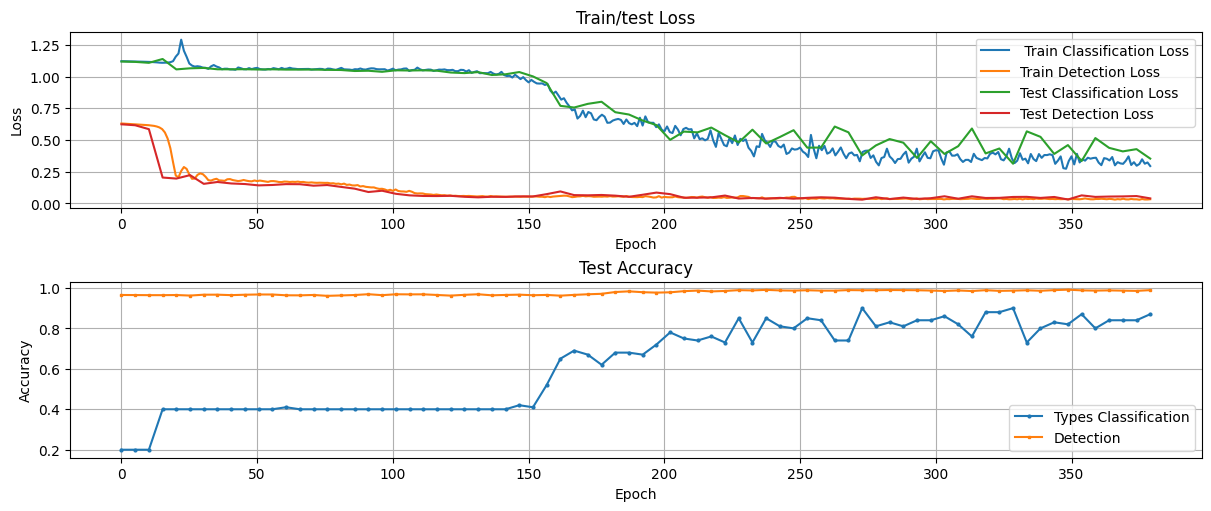

In [16]:
import matplotlib
%matplotlib inline

trainer.train(train_shots, test_sets=test_shots)

trainer.plot_history()

#### Visualize the progress in Tensoboard

One a new terminal, launch tensoboard with log dir set to `./logs`.

```
$ tensorboard --logdir ./logs/ --bind_all
```

## 2. K-Fold Validation

We will use the same steps as in the previous secsion, but this time we will rotate the validation set for K times and run the training in each set. 

In [9]:
import pandas as pd
from omegaconf import OmegaConf
from utils.misc import get_files_in_dir
from dataset.datasets import split_data
from trainer import Trainer

cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))

n_folds = 5

data = [f.split('.')[0] for f in get_files_in_dir(cfg.data.label_dir, file_end='.csv')]
kfolds_data = split_data(data, n_folds=n_folds, seed=cfg.rng.seed)

kfold_cls_results = []
kfold_det_results = []

for i in range(n_folds):
    # Create test samples for this fold
    train_shots, test_shots = kfolds_data[i]
    print(f"fold={i} \n{train_shots=}\n{test_shots=}")

    # create a trainer and train on each fold 
    trainer = Trainer(cfg, exp_name=f"exp1_{n_folds}folds_training/fold{i+1}")
    trainer.train(train_shots, test_sets=test_shots)

    kfold_cls_results.append(trainer.cls_metric_logger.results)
    if cfg.net.detection:
        kfold_det_results.append(trainer.det_metric_logger.results)

## Print kfold classification results
kfold_cls_results_df = pd.DataFrame(kfold_cls_results)
print("K-Fold Classification Results: \n", kfold_cls_results_df)
sum_metrics = kfold_cls_results_df[["tp", "fp", "tn", "fn"]].sum()
mean_metrics = kfold_cls_results_df[["accuracy", "precision", "recall", "f1"]].mean()
avg_results = pd.DataFrame([sum_metrics.tolist() + mean_metrics.tolist()], 
                           columns=sum_metrics.index.tolist() + mean_metrics.index.tolist()
                          )
print("Average K-Fold Classification Results: \n", avg_results)

fold=0 
train_shots=['30458', '30459', '30460', '30461', '30462', '30463', '30464', '30465']
test_shots=['30454', '30457']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.630, loss:    1.751]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.628, loss:    1.748]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.627, loss:    1.747]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.626, loss:    1.745]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.625, loss:    1.744]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.51it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49327 | 1873 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.55it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from inf to 1.741689.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.741689.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.624, loss:    1.742]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.622, loss:    1.740]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.621, loss:    1.738]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.619, loss:    1.736]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.618, loss:    1.734]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.83it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49384 | 1816 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.741689 to 1.731257.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.741689 to 1.731257.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.616, loss:    1.732]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.614, loss:    1.728]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.611, loss:    1.725]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.607, loss:    1.718]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.599, loss:    1.709]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  3.06it/s, test_loss: 1.694,                             test_cls_acc: 0.200, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49488 | 1712 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.58it/s, test_loss: 1.694,                             test_cls_acc: 0.200, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.731257 to 1.693987.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.731257 to 1.693987.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.587, loss:    1.696]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.563, loss:    1.672]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.110, elm_det_loss:    0.518, loss:    1.628]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.446, loss:    1.557]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.338, loss:    1.459]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.64it/s, test_loss: 1.341,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49432 | 1768 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.341,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.693987 to 1.340627.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.693987 to 1.340627.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.137, elm_det_loss:    0.230, loss:    1.367]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.210, elm_det_loss:    0.210, loss:    1.419]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.244, elm_det_loss:    0.255, loss:    1.499]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.169, elm_det_loss:    0.280, loss:    1.449]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.145, elm_det_loss:    0.275, loss:    1.420]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  3.07it/s, test_loss: 1.261,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49417 | 1783 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.61it/s, test_loss: 1.261,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.340627 to 1.260837.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.340627 to 1.260837.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.242, loss:    1.361]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.106, elm_det_loss:    0.201, loss:    1.307]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.083, elm_det_loss:    0.191, loss:    1.274]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.219, loss:    1.298]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.242, loss:    1.321]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.98it/s, test_loss: 1.303,                             test_cls_acc: 0.400, test_det_acc: 0.960]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49158 | 2042 |       0.96 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 1.303,                             test_cls_acc: 0.400, test_det_acc: 0.960]


Modelcheckpoint: test/loss didn't improved from 1.260837.
Early Stopping: test/loss didn't improve from 1.260837. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.241, loss:    1.310]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.219, loss:    1.278]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.191, loss:    1.244]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.175, loss:    1.255]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.187, loss:    1.266]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.07it/s, test_loss: 1.234,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49414 | 1786 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 1.234,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.260837 to 1.234440.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.260837 to 1.234440.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.092, elm_det_loss:    0.193, loss:    1.285]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.188, loss:    1.264]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.082, elm_det_loss:    0.189, loss:    1.271]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.183, loss:    1.254]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.188, loss:    1.247]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 1.237,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49393 | 1807 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.40it/s, test_loss: 1.237,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.234440.
Early Stopping: test/loss didn't improve from 1.234440. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.197, loss:    1.258]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.198, loss:    1.260]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.186, loss:    1.245]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.179, loss:    1.235]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.176, loss:    1.235]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.73it/s, test_loss: 1.213,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49371 | 1829 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 1.213,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.234440 to 1.212645.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.234440 to 1.212645.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.182, loss:    1.249]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.186, loss:    1.249]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.185, loss:    1.253]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.178, loss:    1.235]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.173, loss:    1.235]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.89it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49457 | 1743 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.45it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.212645 to 1.205974.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.212645 to 1.205974.
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.181, loss:    1.240]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.179, loss:    1.236]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.181, loss:    1.236]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.179, loss:    1.235]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.175, loss:    1.239]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.38it/s, test_loss: 1.200,                             test_cls_acc: 0.400, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49523 | 1677 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.200,                             test_cls_acc: 0.400, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.205974 to 1.199772.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.205974 to 1.199772.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.169, loss:    1.227]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.171, loss:    1.230]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.178, loss:    1.232]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.175, loss:    1.244]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.175, loss:    1.236]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.13it/s, test_loss: 1.211,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49310 | 1890 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.211,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.199772.
Early Stopping: test/loss didn't improve from 1.199772. Early stopping counter: 1/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.174, loss:    1.229]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.173, loss:    1.232]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.174, loss:    1.231]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.172, loss:    1.237]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.173, loss:    1.232]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.12it/s, test_loss: 1.205,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49383 | 1817 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.44it/s, test_loss: 1.205,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.199772.
Early Stopping: test/loss didn't improve from 1.199772. Early stopping counter: 2/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.175, loss:    1.231]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.173, loss:    1.234]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.166, loss:    1.219]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.174, loss:    1.230]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.170, loss:    1.227]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.35it/s, test_loss: 1.199,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49438 | 1762 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 1.199,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.199772 to 1.198611.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.199772 to 1.198611.
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.166, loss:    1.222]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.171, loss:    1.233]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.166, loss:    1.228]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.165, loss:    1.221]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.169, loss:    1.224]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.73it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49376 | 1824 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.197,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.198611 to 1.196748.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.198611 to 1.196748.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.161, loss:    1.211]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.164, loss:    1.231]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.162, loss:    1.218]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.164, loss:    1.226]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.163, loss:    1.226]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.11it/s, test_loss: 1.192,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49475 | 1725 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.43it/s, test_loss: 1.192,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.196748 to 1.191647.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.196748 to 1.191647.
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.158, loss:    1.212]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.158, loss:    1.213]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.153, loss:    1.204]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.158, loss:    1.214]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.150, loss:    1.209]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.77it/s, test_loss: 1.183,                             test_cls_acc: 0.190, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   19 |   81 |  119 |   81 |       0.46 |       0.119 |    0.158 | 0.134 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49433 | 1767 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 1.183,                             test_cls_acc: 0.190, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.191647 to 1.183141.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.191647 to 1.183141.
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.153, loss:    1.210]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  5.69it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.152, loss:    1.209]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.145, loss:    1.199]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.146, loss:    1.210]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.140, loss:    1.198]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.21it/s, test_loss: 1.176,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49410 | 1790 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 1.176,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.183141 to 1.175792.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.183141 to 1.175792.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.139, loss:    1.198]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.138, loss:    1.194]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.138, loss:    1.191]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.131, loss:    1.186]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.134, loss:    1.186]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.19it/s, test_loss: 1.172,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49350 | 1850 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.75it/s, test_loss: 1.172,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.175792 to 1.171667.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.175792 to 1.171667.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.129, loss:    1.184]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.124, loss:    1.177]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.120, loss:    1.174]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.122, loss:    1.174]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.118, loss:    1.166]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 1.140,                             test_cls_acc: 0.400, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49531 | 1669 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.49it/s, test_loss: 1.140,                             test_cls_acc: 0.400, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.171667 to 1.139626.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.171667 to 1.139626.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.112, loss:    1.160]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.112, loss:    1.164]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.106, loss:    1.151]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.104, loss:    1.154]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.106, loss:    1.145]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.06it/s, test_loss: 1.161,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49381 | 1819 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.58it/s, test_loss: 1.161,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.139626.
Early Stopping: test/loss didn't improve from 1.139626. Early stopping counter: 1/10
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.105, loss:    1.149]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.100, loss:    1.136]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.099, loss:    1.149]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.095, loss:    1.147]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.095, loss:    1.156]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, test_loss: 1.126,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49475 | 1725 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.33it/s, test_loss: 1.126,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.139626 to 1.125554.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.139626 to 1.125554.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.102, loss:    1.150]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.092, loss:    1.135]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.041, elm_det_loss:    0.083, loss:    1.124]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.081, loss:    1.134]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.080, loss:    1.119]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.43it/s, test_loss: 1.124,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49456 | 1744 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.36it/s, test_loss: 1.124,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.125554 to 1.124173.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.125554 to 1.124173.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.077, loss:    1.119]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.041, elm_det_loss:    0.076, loss:    1.116]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.071, loss:    1.121]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.070, loss:    1.121]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.069, loss:    1.112]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.15it/s, test_loss: 1.113,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49345 | 1855 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.77it/s, test_loss: 1.113,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.124173 to 1.113117.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.124173 to 1.113117.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.068, loss:    1.122]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.068, loss:    1.111]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.065, loss:    1.110]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.067, loss:    1.113]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.065, loss:    1.105]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.18it/s, test_loss: 1.118,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49246 | 1954 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.74it/s, test_loss: 1.118,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.113117.
Early Stopping: test/loss didn't improve from 1.113117. Early stopping counter: 1/10
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.063, loss:    1.105]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.062, loss:    1.107]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.066, loss:    1.121]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.065, loss:    1.110]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.033, elm_det_loss:    0.059, loss:    1.092]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.42it/s, test_loss: 1.090,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49440 | 1760 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.41it/s, test_loss: 1.090,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.113117 to 1.089694.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.113117 to 1.089694.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.041, elm_det_loss:    0.063, loss:    1.103]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.060, loss:    1.100]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.058, loss:    1.103]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.029, elm_det_loss:    0.062, loss:    1.090]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.058, loss:    1.103]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.18it/s, test_loss: 1.092,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49404 | 1796 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.74it/s, test_loss: 1.092,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.089694.
Early Stopping: test/loss didn't improve from 1.089694. Early stopping counter: 1/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.038, elm_det_loss:    0.061, loss:    1.099]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.063, loss:    1.091]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.062, loss:    1.086]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.060, loss:    1.086]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.016, elm_det_loss:    0.058, loss:    1.074]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.32it/s, test_loss: 1.077,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49428 | 1772 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 1.077,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.089694 to 1.077244.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.089694 to 1.077244.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.020, elm_det_loss:    0.056, loss:    1.076]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.057, loss:    1.085]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    1.011, elm_det_loss:    0.057, loss:    1.069]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.003, elm_det_loss:    0.058, loss:    1.061]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.001, elm_det_loss:    0.057, loss:    1.058]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.16it/s, test_loss: 1.024,                             test_cls_acc: 0.430, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   43 |   57 |  143 |   57 |       0.62 |       0.471 |    0.358 | 0.241 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49359 | 1841 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.16it/s, test_loss: 1.024,                             test_cls_acc: 0.430, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.077244 to 1.024272.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.077244 to 1.024272.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.987, elm_det_loss:    0.056, loss:    1.043]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.976, elm_det_loss:    0.058, loss:    1.034]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.959, elm_det_loss:    0.056, loss:    1.015]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.954, elm_det_loss:    0.057, loss:    1.011]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.948, elm_det_loss:    0.061, loss:    1.009]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.65it/s, test_loss: 0.916,                             test_cls_acc: 0.750, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.509 |    0.625 | 0.558 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49505 | 1695 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 0.916,                             test_cls_acc: 0.750, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.024272 to 0.915923.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.024272 to 0.915923.
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    0.904, elm_det_loss:    0.058, loss:    0.962]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.839, elm_det_loss:    0.062, loss:    0.901]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.788, elm_det_loss:    0.076, loss:    0.864]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.794, elm_det_loss:    0.077, loss:    0.871]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.753, elm_det_loss:    0.065, loss:    0.819]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.32it/s, test_loss: 0.772,                             test_cls_acc: 0.790, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.529 |    0.658 | 0.586 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49513 | 1687 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.772,                             test_cls_acc: 0.790, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 0.915923 to 0.772432.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.915923 to 0.772432.
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.755, elm_det_loss:    0.065, loss:    0.820]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    0.716, elm_det_loss:    0.070, loss:    0.785]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.696, elm_det_loss:    0.063, loss:    0.759]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.675, elm_det_loss:    0.068, loss:    0.743]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.680, elm_det_loss:    0.065, loss:    0.745]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.84it/s, test_loss: 0.730,                             test_cls_acc: 0.790, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.527 |    0.658 | 0.585 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |    1 |    1 | 49455 | 1743 |      0.966 |         0.5 |    0.001 | 0.001 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 0.730,                             test_cls_acc: 0.790, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 0.772432 to 0.730317.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.772432 to 0.730317.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.647, elm_det_loss:    0.064, loss:    0.711]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.695, elm_det_loss:    0.068, loss:    0.763]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.650, elm_det_loss:    0.058, loss:    0.709]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.685, elm_det_loss:    0.064, loss:    0.749]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.664, elm_det_loss:    0.068, loss:    0.732]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.22it/s, test_loss: 0.843,                             test_cls_acc: 0.720, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.489 |      0.6 | 0.533 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    9 |    2 | 49370 | 1819 |      0.964 |       0.818 |    0.005 | 0.01 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.33it/s, test_loss: 0.843,                             test_cls_acc: 0.720, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 0.730317.
Early Stopping: test/loss didn't improve from 0.730317. Early stopping counter: 1/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.646, elm_det_loss:    0.058, loss:    0.704]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    0.670, elm_det_loss:    0.059, loss:    0.729]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.701, elm_det_loss:    0.063, loss:    0.764]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.655, elm_det_loss:    0.059, loss:    0.715]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.605, elm_det_loss:    0.064, loss:    0.668]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.77it/s, test_loss: 0.810,                             test_cls_acc: 0.750, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.501 |    0.625 | 0.555 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   13 |    4 | 49316 | 1867 |      0.963 |       0.765 |    0.007 | 0.014 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.56it/s, test_loss: 0.810,                             test_cls_acc: 0.750, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 0.730317.
Early Stopping: test/loss didn't improve from 0.730317. Early stopping counter: 2/10
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.665, elm_det_loss:    0.067, loss:    0.732]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.599, elm_det_loss:    0.060, loss:    0.659]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.640, elm_det_loss:    0.057, loss:    0.697]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.658, elm_det_loss:    0.053, loss:    0.711]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.605, elm_det_loss:    0.059, loss:    0.664]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.89it/s, test_loss: 0.775,                             test_cls_acc: 0.760, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.508 |    0.633 | 0.563 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   74 |   32 | 49495 | 1599 |      0.968 |       0.698 |    0.044 | 0.083 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.775,                             test_cls_acc: 0.760, test_det_acc: 0.968]


Modelcheckpoint: test/loss didn't improved from 0.730317.
Early Stopping: test/loss didn't improve from 0.730317. Early stopping counter: 3/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.586, elm_det_loss:    0.056, loss:    0.642]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.627, elm_det_loss:    0.055, loss:    0.682]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.649, elm_det_loss:    0.058, loss:    0.707]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.595, elm_det_loss:    0.058, loss:    0.652]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.584, elm_det_loss:    0.052, loss:    0.636]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.45it/s, test_loss: 0.830,                             test_cls_acc: 0.750, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.501 |    0.625 | 0.555 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  157 |   30 | 49280 | 1733 |      0.966 |        0.84 |    0.083 | 0.151 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.76it/s, test_loss: 0.830,                             test_cls_acc: 0.750, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 0.730317.
Early Stopping: test/loss didn't improve from 0.730317. Early stopping counter: 4/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.627, elm_det_loss:    0.057, loss:    0.684]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.634, elm_det_loss:    0.056, loss:    0.690]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.602, elm_det_loss:    0.053, loss:    0.655]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.640, elm_det_loss:    0.057, loss:    0.697]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.609, elm_det_loss:    0.049, loss:    0.658]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.36it/s, test_loss: 0.854,                             test_cls_acc: 0.800, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |        0.76 |    0.725 | 0.727 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  224 |   45 | 49370 | 1561 |      0.969 |       0.833 |    0.125 | 0.218 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.37it/s, test_loss: 0.854,                             test_cls_acc: 0.800, test_det_acc: 0.969]


Modelcheckpoint: test/loss didn't improved from 0.730317.
Early Stopping: test/loss didn't improve from 0.730317. Early stopping counter: 5/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.618, elm_det_loss:    0.056, loss:    0.674]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.575, elm_det_loss:    0.057, loss:    0.632]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.574, elm_det_loss:    0.055, loss:    0.628]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.604, elm_det_loss:    0.055, loss:    0.660]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.604, elm_det_loss:    0.050, loss:    0.655]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.79it/s, test_loss: 0.743,                             test_cls_acc: 0.790, test_det_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.729 |    0.708 | 0.705 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  472 |  102 | 49198 | 1428 |       0.97 |       0.822 |    0.248 | 0.382 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 0.743,                             test_cls_acc: 0.790, test_det_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 0.730317.
Early Stopping: test/loss didn't improve from 0.730317. Early stopping counter: 6/10
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.612, elm_det_loss:    0.052, loss:    0.664]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.561, elm_det_loss:    0.050, loss:    0.612]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.589, elm_det_loss:    0.051, loss:    0.641]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.597, elm_det_loss:    0.053, loss:    0.650]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.545, elm_det_loss:    0.049, loss:    0.594]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.77it/s, test_loss: 0.705,                             test_cls_acc: 0.810, test_det_acc: 0.978]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.804 |    0.767 | 0.777 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  746 |   99 | 49312 | 1043 |      0.978 |       0.883 |    0.417 | 0.566 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.81it/s, test_loss: 0.705,                             test_cls_acc: 0.810, test_det_acc: 0.978]


Modelcheckpoint: test/loss improved from 0.730317 to 0.704618.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.730317 to 0.704618.
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.532, elm_det_loss:    0.048, loss:    0.580]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.549, elm_det_loss:    0.050, loss:    0.598]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.499, elm_det_loss:    0.048, loss:    0.547]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.549, elm_det_loss:    0.048, loss:    0.597]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.522, elm_det_loss:    0.049, loss:    0.571]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.07it/s, test_loss: 0.686,                             test_cls_acc: 0.790, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.741 |    0.725 | 0.727 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1195 |  233 | 49188 |  584 |      0.984 |       0.837 |    0.672 | 0.745 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.76it/s, test_loss: 0.686,                             test_cls_acc: 0.790, test_det_acc: 0.984]


Modelcheckpoint: test/loss improved from 0.704618 to 0.686119.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.704618 to 0.686119.
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.050, loss:    0.561]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.577, elm_det_loss:    0.047, loss:    0.624]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.544, elm_det_loss:    0.049, loss:    0.593]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.522, elm_det_loss:    0.044, loss:    0.566]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.521, elm_det_loss:    0.045, loss:    0.567]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.02it/s, test_loss: 0.607,                             test_cls_acc: 0.810, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.772 |     0.75 | 0.755 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1317 |  194 | 49217 |  472 |      0.987 |       0.872 |    0.736 | 0.798 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.23it/s, test_loss: 0.607,                             test_cls_acc: 0.810, test_det_acc: 0.987]


Modelcheckpoint: test/loss improved from 0.686119 to 0.607121.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.686119 to 0.607121.
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.524, elm_det_loss:    0.047, loss:    0.571]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.545, elm_det_loss:    0.050, loss:    0.595]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.526, elm_det_loss:    0.049, loss:    0.574]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.554, elm_det_loss:    0.048, loss:    0.602]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.490, elm_det_loss:    0.044, loss:    0.535]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.60it/s, test_loss: 0.571,                             test_cls_acc: 0.810, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.742 |    0.717 | 0.708 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1414 |  213 | 49275 |  298 |       0.99 |       0.869 |    0.826 | 0.847 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.28it/s, test_loss: 0.571,                             test_cls_acc: 0.810, test_det_acc: 0.990]


Modelcheckpoint: test/loss improved from 0.607121 to 0.571476.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.607121 to 0.571476.
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    0.543, elm_det_loss:    0.047, loss:    0.590]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.519, elm_det_loss:    0.047, loss:    0.566]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  7.15it/s, , elm_cls_loss:    0.482, elm_det_loss:    0.046, loss:    0.529]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.495, elm_det_loss:    0.046, loss:    0.540]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.529, elm_det_loss:    0.048, loss:    0.577]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.60it/s, test_loss: 0.791,                             test_cls_acc: 0.790, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.737 |    0.717 | 0.718 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1508 |  270 | 49159 |  263 |       0.99 |       0.848 |    0.851 | 0.85 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.791,                             test_cls_acc: 0.790, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.571476.
Early Stopping: test/loss didn't improve from 0.571476. Early stopping counter: 1/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.514, elm_det_loss:    0.051, loss:    0.565]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.454, elm_det_loss:    0.046, loss:    0.500]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.532, elm_det_loss:    0.043, loss:    0.576]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.480, elm_det_loss:    0.046, loss:    0.525]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    0.521, elm_det_loss:    0.046, loss:    0.567]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.96it/s, test_loss: 0.516,                             test_cls_acc: 0.840, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.809 |    0.808 | 0.808 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1602 |  426 | 49026 |  146 |      0.989 |        0.79 |    0.916 | 0.849 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 0.516,                             test_cls_acc: 0.840, test_det_acc: 0.989]


Modelcheckpoint: test/loss improved from 0.571476 to 0.515617.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.571476 to 0.515617.
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.486, elm_det_loss:    0.044, loss:    0.530]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.506, elm_det_loss:    0.042, loss:    0.548]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.471, elm_det_loss:    0.043, loss:    0.514]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.044, loss:    0.487]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.479, elm_det_loss:    0.043, loss:    0.522]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.98it/s, test_loss: 0.539,                             test_cls_acc: 0.790, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.744 |      0.7 | 0.692 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1727 |  463 | 48824 |  186 |      0.987 |       0.789 |    0.903 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.539,                             test_cls_acc: 0.790, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.515617.
Early Stopping: test/loss didn't improve from 0.515617. Early stopping counter: 1/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  5.97it/s, , elm_cls_loss:    0.462, elm_det_loss:    0.041, loss:    0.503]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.474, elm_det_loss:    0.046, loss:    0.519]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.466, elm_det_loss:    0.042, loss:    0.508]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.041, loss:    0.552]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.496, elm_det_loss:    0.044, loss:    0.540]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.73it/s, test_loss: 0.438,                             test_cls_acc: 0.880, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.855 |     0.85 | 0.852 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1631 |  422 | 48988 |  159 |      0.989 |       0.794 |    0.911 | 0.849 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.07it/s, test_loss: 0.438,                             test_cls_acc: 0.880, test_det_acc: 0.989]


Modelcheckpoint: test/loss improved from 0.515617 to 0.437969.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.515617 to 0.437969.
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.455, elm_det_loss:    0.039, loss:    0.494]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.462, elm_det_loss:    0.041, loss:    0.503]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.043, loss:    0.467]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.480, elm_det_loss:    0.039, loss:    0.519]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.449, elm_det_loss:    0.041, loss:    0.490]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.02it/s, test_loss: 0.534,                             test_cls_acc: 0.820, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.782 |    0.758 | 0.764 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1627 |  284 | 49095 |  194 |      0.991 |       0.851 |    0.893 | 0.872 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.95it/s, test_loss: 0.534,                             test_cls_acc: 0.820, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.437969.
Early Stopping: test/loss didn't improve from 0.437969. Early stopping counter: 1/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  6.07it/s, , elm_cls_loss:    0.435, elm_det_loss:    0.040, loss:    0.475]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  5.82it/s, , elm_cls_loss:    0.438, elm_det_loss:    0.041, loss:    0.478]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.042, loss:    0.476]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.478, elm_det_loss:    0.039, loss:    0.517]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.433, elm_det_loss:    0.042, loss:    0.475]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.64it/s, test_loss: 0.519,                             test_cls_acc: 0.820, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |        0.79 |    0.758 | 0.764 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1623 |  322 | 49073 |  182 |       0.99 |       0.834 |    0.899 | 0.866 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 0.519,                             test_cls_acc: 0.820, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.437969.
Early Stopping: test/loss didn't improve from 0.437969. Early stopping counter: 2/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.039, loss:    0.531]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.444, elm_det_loss:    0.039, loss:    0.484]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.466, elm_det_loss:    0.042, loss:    0.507]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.041, loss:    0.475]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.041, loss:    0.376]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.87it/s, test_loss: 0.499,                             test_cls_acc: 0.870, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.864 |     0.85 | 0.855 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1595 |  263 | 49030 |  312 |      0.989 |       0.858 |    0.836 | 0.847 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 0.499,                             test_cls_acc: 0.870, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.437969.
Early Stopping: test/loss didn't improve from 0.437969. Early stopping counter: 3/10
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.422, elm_det_loss:    0.046, loss:    0.467]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  7.27it/s, , elm_cls_loss:    0.500, elm_det_loss:    0.039, loss:    0.539]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  7.40it/s, , elm_cls_loss:    0.456, elm_det_loss:    0.040, loss:    0.496]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.494, elm_det_loss:    0.044, loss:    0.538]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.046, loss:    0.538]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.91it/s, test_loss: 0.411,                             test_cls_acc: 0.890, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   89 |   11 |  189 |   11 |      0.927 |       0.874 |     0.85 | 0.859 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1544 |  472 | 49077 |  107 |      0.989 |       0.766 |    0.935 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.19it/s, test_loss: 0.411,                             test_cls_acc: 0.890, test_det_acc: 0.989]


Modelcheckpoint: test/loss improved from 0.437969 to 0.411177.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.437969 to 0.411177.
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.044, loss:    0.463]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.454, elm_det_loss:    0.038, loss:    0.492]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.472, elm_det_loss:    0.041, loss:    0.513]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.454, elm_det_loss:    0.035, loss:    0.489]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.039, loss:    0.430]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.60it/s, test_loss: 0.460,                             test_cls_acc: 0.850, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.832 |    0.792 | 0.801 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1535 |  281 | 49176 |  208 |       0.99 |       0.845 |    0.881 | 0.863 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.460,                             test_cls_acc: 0.850, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.411177.
Early Stopping: test/loss didn't improve from 0.411177. Early stopping counter: 1/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.453, elm_det_loss:    0.042, loss:    0.495]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.041, loss:    0.441]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.038, loss:    0.457]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.039, loss:    0.447]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.448, elm_det_loss:    0.037, loss:    0.485]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.18it/s, test_loss: 0.492,                             test_cls_acc: 0.840, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |        0.82 |      0.8 | 0.806 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1712 |  380 | 48891 |  217 |      0.988 |       0.818 |    0.888 | 0.852 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.492,                             test_cls_acc: 0.840, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.411177.
Early Stopping: test/loss didn't improve from 0.411177. Early stopping counter: 2/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.036, loss:    0.413]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.467, elm_det_loss:    0.037, loss:    0.505]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.036, loss:    0.409]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.440, elm_det_loss:    0.038, loss:    0.477]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.381, elm_det_loss:    0.036, loss:    0.418]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.84it/s, test_loss: 0.387,                             test_cls_acc: 0.890, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   89 |   11 |  189 |   11 |      0.927 |       0.885 |     0.85 | 0.862 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1655 |  291 | 49065 |  189 |      0.991 |        0.85 |    0.898 | 0.873 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.387,                             test_cls_acc: 0.890, test_det_acc: 0.991]


Modelcheckpoint: test/loss improved from 0.411177 to 0.386849.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.411177 to 0.386849.
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.036, loss:    0.445]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.037, loss:    0.420]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.035, loss:    0.440]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.036, loss:    0.455]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.037, loss:    0.415]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.76it/s, test_loss: 0.463,                             test_cls_acc: 0.860, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.841 |      0.8 | 0.81 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1599 |  373 | 49064 |  164 |       0.99 |       0.811 |    0.907 | 0.856 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.463,                             test_cls_acc: 0.860, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.386849.
Early Stopping: test/loss didn't improve from 0.386849. Early stopping counter: 1/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.394, elm_det_loss:    0.040, loss:    0.434]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.041, loss:    0.439]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.428, elm_det_loss:    0.037, loss:    0.465]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.038, loss:    0.430]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.037, loss:    0.420]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.85it/s, test_loss: 0.646,                             test_cls_acc: 0.830, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.813 |    0.767 | 0.776 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1559 |  306 | 49153 |  182 |       0.99 |       0.836 |    0.895 | 0.865 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.14it/s, test_loss: 0.646,                             test_cls_acc: 0.830, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.386849.
Early Stopping: test/loss didn't improve from 0.386849. Early stopping counter: 2/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.036, loss:    0.409]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.037, loss:    0.434]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.044, loss:    0.473]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.039, loss:    0.385]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.038, loss:    0.440]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.51it/s, test_loss: 0.358,                             test_cls_acc: 0.880, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.891 |    0.825 | 0.841 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1633 |  280 | 49121 |  166 |      0.991 |       0.854 |    0.908 | 0.88 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.40it/s, test_loss: 0.358,                             test_cls_acc: 0.880, test_det_acc: 0.991]


Modelcheckpoint: test/loss improved from 0.386849 to 0.357901.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.386849 to 0.357901.
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.416, elm_det_loss:    0.037, loss:    0.453]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    0.395, elm_det_loss:    0.038, loss:    0.432]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.037, loss:    0.400]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.036, loss:    0.389]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.040, loss:    0.439]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.67it/s, test_loss: 0.470,                             test_cls_acc: 0.840, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.838 |    0.783 | 0.795 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1729 |  333 | 48888 |  250 |      0.989 |       0.839 |    0.874 | 0.856 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 0.470,                             test_cls_acc: 0.840, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.357901.
Early Stopping: test/loss didn't improve from 0.357901. Early stopping counter: 1/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.041, loss:    0.470]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.034, loss:    0.404]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.039, loss:    0.458]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.038, loss:    0.420]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.037, loss:    0.440]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.06it/s, test_loss: 0.513,                             test_cls_acc: 0.790, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.759 |    0.742 | 0.744 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1713 |  325 | 48965 |  197 |       0.99 |       0.841 |    0.897 | 0.868 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.33it/s, test_loss: 0.513,                             test_cls_acc: 0.790, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.357901.
Early Stopping: test/loss didn't improve from 0.357901. Early stopping counter: 2/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.036, loss:    0.391]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.037, loss:    0.365]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.039, loss:    0.427]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.357, elm_det_loss:    0.035, loss:    0.393]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.039, loss:    0.456]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.27it/s, test_loss: 0.397,                             test_cls_acc: 0.880, test_det_acc: 0.992]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.919 |    0.808 | 0.825 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1454 |  239 | 49338 |  169 |      0.992 |       0.859 |    0.896 | 0.877 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.397,                             test_cls_acc: 0.880, test_det_acc: 0.992]


Modelcheckpoint: test/loss didn't improved from 0.357901.
Early Stopping: test/loss didn't improve from 0.357901. Early stopping counter: 3/10
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.036, loss:    0.395]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.038, loss:    0.431]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.036, loss:    0.363]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.036, loss:    0.404]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.036, loss:    0.410]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.58it/s, test_loss: 0.318,                             test_cls_acc: 0.900, test_det_acc: 0.992]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.893 |    0.858 | 0.87 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1665 |  245 | 49124 |  166 |      0.992 |       0.872 |    0.909 | 0.89 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.06it/s, test_loss: 0.318,                             test_cls_acc: 0.900, test_det_acc: 0.992]


Modelcheckpoint: test/loss improved from 0.357901 to 0.318117.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.357901 to 0.318117.
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.422, elm_det_loss:    0.037, loss:    0.459]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.438, elm_det_loss:    0.036, loss:    0.474]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.036, loss:    0.433]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    0.437, elm_det_loss:    0.035, loss:    0.472]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.038, loss:    0.413]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.05it/s, test_loss: 0.341,                             test_cls_acc: 0.870, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.878 |      0.8 | 0.812 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1605 |  238 | 49129 |  228 |      0.991 |       0.871 |    0.876 | 0.873 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 0.341,                             test_cls_acc: 0.870, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.318117.
Early Stopping: test/loss didn't improve from 0.318117. Early stopping counter: 1/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.395, elm_det_loss:    0.037, loss:    0.432]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.427, elm_det_loss:    0.048, loss:    0.476]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.034, loss:    0.413]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00,  7.70it/s, , elm_cls_loss:    0.365, elm_det_loss:    0.035, loss:    0.400]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.034, loss:    0.379]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.49it/s, test_loss: 0.555,                             test_cls_acc: 0.810, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |        0.83 |    0.742 | 0.752 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1606 |  316 | 49137 |  141 |      0.991 |       0.836 |    0.919 | 0.875 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 0.555,                             test_cls_acc: 0.810, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.318117.
Early Stopping: test/loss didn't improve from 0.318117. Early stopping counter: 2/10
Epoch 310/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.036, loss:    0.377]


Epoch 311/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.037, loss:    0.426]


Epoch 312/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.036, loss:    0.420]


Epoch 313/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.036, loss:    0.422]


Epoch 314/1000


100%|██████████| 1/1 [00:00<00:00,  7.78it/s, , elm_cls_loss:    0.347, elm_det_loss:    0.036, loss:    0.383]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.86it/s, test_loss: 0.438,                             test_cls_acc: 0.840, test_det_acc: 0.992]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.804 |    0.758 | 0.759 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1499 |  273 | 49277 |  151 |      0.992 |       0.846 |    0.908 | 0.876 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.75it/s, test_loss: 0.438,                             test_cls_acc: 0.840, test_det_acc: 0.992]


Modelcheckpoint: test/loss didn't improved from 0.318117.
Early Stopping: test/loss didn't improve from 0.318117. Early stopping counter: 3/10
Epoch 315/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.339, elm_det_loss:    0.038, loss:    0.377]


Epoch 316/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    0.406, elm_det_loss:    0.038, loss:    0.444]


Epoch 317/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    0.347, elm_det_loss:    0.033, loss:    0.380]


Epoch 318/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.035, loss:    0.427]


Epoch 319/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.035, loss:    0.412]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.92it/s, test_loss: 0.485,                             test_cls_acc: 0.830, test_det_acc: 0.992]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.804 |    0.775 | 0.782 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1619 |  290 | 49181 |  110 |      0.992 |       0.848 |    0.936 | 0.89 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.60it/s, test_loss: 0.485,                             test_cls_acc: 0.830, test_det_acc: 0.992]


Modelcheckpoint: test/loss didn't improved from 0.318117.
Early Stopping: test/loss didn't improve from 0.318117. Early stopping counter: 4/10
Epoch 320/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.039, loss:    0.438]


Epoch 321/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.034, loss:    0.402]


Epoch 322/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.037, loss:    0.434]


Epoch 323/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.032, loss:    0.321]


Epoch 324/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.367, elm_det_loss:    0.035, loss:    0.402]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.72it/s, test_loss: 0.524,                             test_cls_acc: 0.820, test_det_acc: 0.992]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.809 |    0.742 | 0.746 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1507 |  259 | 49274 |  160 |      0.992 |       0.853 |    0.904 | 0.878 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.15it/s, test_loss: 0.524,                             test_cls_acc: 0.820, test_det_acc: 0.992]


Modelcheckpoint: test/loss didn't improved from 0.318117.
Early Stopping: test/loss didn't improve from 0.318117. Early stopping counter: 5/10
Epoch 325/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.038, loss:    0.365]


Epoch 326/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.314, elm_det_loss:    0.036, loss:    0.350]


Epoch 327/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.034, loss:    0.377]


Epoch 328/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.035, loss:    0.380]


Epoch 329/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.394, elm_det_loss:    0.036, loss:    0.430]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.35it/s, test_loss: 0.301,                             test_cls_acc: 0.900, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.908 |    0.875 | 0.887 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1690 |  296 | 49062 |  152 |      0.991 |       0.851 |    0.917 | 0.883 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.84it/s, test_loss: 0.301,                             test_cls_acc: 0.900, test_det_acc: 0.991]


Modelcheckpoint: test/loss improved from 0.318117 to 0.300871.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.318117 to 0.300871.
Epoch 330/1000


100%|██████████| 1/1 [00:00<00:00,  7.51it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.036, loss:    0.413]


Epoch 331/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.036, loss:    0.392]


Epoch 332/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.034, loss:    0.390]


Epoch 333/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.036, loss:    0.418]


Epoch 334/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.037, loss:    0.368]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.85it/s, test_loss: 0.445,                             test_cls_acc: 0.810, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.781 |    0.733 | 0.735 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1579 |  222 | 49184 |  215 |      0.991 |       0.877 |     0.88 | 0.878 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.77it/s, test_loss: 0.445,                             test_cls_acc: 0.810, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 1/10
Epoch 335/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.415, elm_det_loss:    0.034, loss:    0.449]


Epoch 336/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.313, elm_det_loss:    0.035, loss:    0.348]


Epoch 337/1000


100%|██████████| 1/1 [00:00<00:00,  7.33it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.032, loss:    0.380]


Epoch 338/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.034, loss:    0.341]


Epoch 339/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.035, loss:    0.388]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.44it/s, test_loss: 0.389,                             test_cls_acc: 0.870, test_det_acc: 0.992]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.882 |    0.825 | 0.841 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1670 |  248 | 49137 |  145 |      0.992 |       0.871 |     0.92 | 0.895 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.78it/s, test_loss: 0.389,                             test_cls_acc: 0.870, test_det_acc: 0.992]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 2/10
Epoch 340/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.034, loss:    0.406]


Epoch 341/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    0.352, elm_det_loss:    0.033, loss:    0.385]


Epoch 342/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.038, loss:    0.394]


Epoch 343/1000


100%|██████████| 1/1 [00:00<00:00,  7.52it/s, , elm_cls_loss:    0.357, elm_det_loss:    0.035, loss:    0.392]


Epoch 344/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.033, loss:    0.356]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.36it/s, test_loss: 0.458,                             test_cls_acc: 0.830, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.801 |    0.783 | 0.789 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1623 |  379 | 49098 |  100 |      0.991 |       0.811 |    0.942 | 0.871 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 0.458,                             test_cls_acc: 0.830, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 3/10
Epoch 345/1000


100%|██████████| 1/1 [00:00<00:00,  7.48it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.034, loss:    0.342]


Epoch 346/1000


100%|██████████| 1/1 [00:00<00:00,  7.63it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.037, loss:    0.390]


Epoch 347/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.033, loss:    0.422]


Epoch 348/1000


100%|██████████| 1/1 [00:00<00:00,  7.65it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.038, loss:    0.404]


Epoch 349/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.036, loss:    0.380]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.44it/s, test_loss: 0.394,                             test_cls_acc: 0.850, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.824 |      0.8 | 0.807 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1583 |  202 | 49149 |  266 |      0.991 |       0.887 |    0.856 | 0.871 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.00it/s, test_loss: 0.394,                             test_cls_acc: 0.850, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 4/10
Epoch 350/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.035, loss:    0.336]


Epoch 351/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.030, loss:    0.392]


Epoch 352/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.034, loss:    0.370]


Epoch 353/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.032, loss:    0.407]


Epoch 354/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.035, loss:    0.370]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.15it/s, test_loss: 0.382,                             test_cls_acc: 0.840, test_det_acc: 0.992]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.807 |    0.817 | 0.811 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1765 |  311 | 49026 |   98 |      0.992 |        0.85 |    0.947 | 0.896 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.78it/s, test_loss: 0.382,                             test_cls_acc: 0.840, test_det_acc: 0.992]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 5/10
Epoch 355/1000


100%|██████████| 1/1 [00:00<00:00,  6.02it/s, , elm_cls_loss:    0.306, elm_det_loss:    0.034, loss:    0.340]


Epoch 356/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    0.284, elm_det_loss:    0.032, loss:    0.316]


Epoch 357/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    0.273, elm_det_loss:    0.032, loss:    0.305]


Epoch 358/1000


100%|██████████| 1/1 [00:00<00:00,  7.57it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.032, loss:    0.324]


Epoch 359/1000


100%|██████████| 1/1 [00:00<00:00,  7.28it/s, , elm_cls_loss:    0.326, elm_det_loss:    0.034, loss:    0.360]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.81it/s, test_loss: 0.342,                             test_cls_acc: 0.910, test_det_acc: 0.994]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   91 |    9 |  191 |    9 |       0.94 |       0.915 |    0.875 | 0.889 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1587 |  158 | 49308 |  147 |      0.994 |       0.909 |    0.915 | 0.912 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.81it/s, test_loss: 0.342,                             test_cls_acc: 0.910, test_det_acc: 0.994]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 6/10
Epoch 360/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.035, loss:    0.371]


Epoch 361/1000


100%|██████████| 1/1 [00:00<00:00,  7.64it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.032, loss:    0.370]


Epoch 362/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.334, elm_det_loss:    0.033, loss:    0.368]


Epoch 363/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    0.291, elm_det_loss:    0.034, loss:    0.325]


Epoch 364/1000


100%|██████████| 1/1 [00:00<00:00,  7.53it/s, , elm_cls_loss:    0.306, elm_det_loss:    0.031, loss:    0.336]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.70it/s, test_loss: 0.441,                             test_cls_acc: 0.860, test_det_acc: 0.993]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.872 |    0.783 | 0.794 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1552 |  237 | 49273 |  138 |      0.993 |       0.868 |    0.918 | 0.892 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.441,                             test_cls_acc: 0.860, test_det_acc: 0.993]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 7/10
Epoch 365/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.034, loss:    0.342]


Epoch 366/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.036, loss:    0.394]


Epoch 367/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.029, loss:    0.346]


Epoch 368/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.297, elm_det_loss:    0.033, loss:    0.329]


Epoch 369/1000


100%|██████████| 1/1 [00:00<00:00,  7.45it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.033, loss:    0.375]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.92it/s, test_loss: 0.373,                             test_cls_acc: 0.860, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.833 |    0.825 | 0.828 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1849 |  307 | 48841 |  203 |       0.99 |       0.858 |    0.901 | 0.879 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.373,                             test_cls_acc: 0.860, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 8/10
Epoch 370/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    0.280, elm_det_loss:    0.032, loss:    0.313]


Epoch 371/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.286, elm_det_loss:    0.035, loss:    0.321]


Epoch 372/1000


100%|██████████| 1/1 [00:00<00:00,  7.62it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.033, loss:    0.353]


Epoch 373/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    0.306, elm_det_loss:    0.031, loss:    0.337]


Epoch 374/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.032, loss:    0.333]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.78it/s, test_loss: 0.514,                             test_cls_acc: 0.830, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.811 |    0.792 | 0.798 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1738 |  284 | 48922 |  256 |      0.989 |        0.86 |    0.872 | 0.866 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.80it/s, test_loss: 0.514,                             test_cls_acc: 0.830, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 9/10
Epoch 375/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.030, loss:    0.334]


Epoch 376/1000


100%|██████████| 1/1 [00:00<00:00,  7.66it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.037, loss:    0.375]


Epoch 377/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.305, elm_det_loss:    0.033, loss:    0.337]


Epoch 378/1000


100%|██████████| 1/1 [00:00<00:00,  7.36it/s, , elm_cls_loss:    0.298, elm_det_loss:    0.035, loss:    0.333]


Epoch 379/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.032, loss:    0.362]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.58it/s, test_loss: 0.511,                             test_cls_acc: 0.810, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.781 |     0.75 | 0.756 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1683 |  312 | 49063 |  142 |      0.991 |       0.844 |    0.922 | 0.881 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.07it/s, test_loss: 0.511,                             test_cls_acc: 0.810, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.300871.
Early Stopping: test/loss didn't improve from 0.300871. Early stopping counter: 10/10
Early stopping at epoch 379
DONE in 103.80813670158386!
Best ELM Classfication Results (epoch 329) {'tp': 90.0, 'fp': 10.0, 'tn': 190.0, 'fn': 10.0, 'accuracy': 0.9333333333333332, 'precision': 0.9079415954415954, 'recall': 0.875, 'f1': 0.8868619177628858}
Best ELM Detection Results (epoch 329) {'tp': 1690.0, 'fp': 296.0, 'tn': 49062.0, 'fn': 152.0, 'accuracy': 0.99125, 'precision': array(0.8509567), 'recall': array(0.917481), 'f1': array(0.88296761)}
fold=1 
train_shots=['30454', '30457', '30460', '30461', '30462', '30463', '30464', '30465']
test_shots=['30458', '30459']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([380, 1, 512]), 'dtime': torch.Size([380, 1, 512]), 'cls_labels': torch.Size([380]), 'elm_labels': torch.S

/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([120, 1, 512]), 'dtime': torch.Size([120, 1, 512]), 'cls_labels': torch.Size([120]), 'elm_labels': torch.Size([120, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.88it/s, , elm_cls_loss:    1.127, elm_det_loss:    0.630, loss:    1.757]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.126, elm_det_loss:    0.628, loss:    1.754]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.126, elm_det_loss:    0.627, loss:    1.753]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.125, elm_det_loss:    0.626, loss:    1.751]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.124, elm_det_loss:    0.625, loss:    1.749]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.80it/s, test_loss: 1.725,                             test_cls_acc: 0.333, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59075 | 2365 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.54it/s, test_loss: 1.725,                             test_cls_acc: 0.333, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from inf to 1.724604.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.724604.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.123, elm_det_loss:    0.624, loss:    1.747]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.123, elm_det_loss:    0.622, loss:    1.745]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.122, elm_det_loss:    0.621, loss:    1.743]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.620, loss:    1.741]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.618, loss:    1.739]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.64it/s, test_loss: 1.717,                             test_cls_acc: 0.333, test_det_acc: 0.961]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59070 | 2370 |      0.961 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.36it/s, test_loss: 1.717,                             test_cls_acc: 0.333, test_det_acc: 0.961]


Modelcheckpoint: test/loss improved from 1.724604 to 1.716794.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.724604 to 1.716794.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.616, loss:    1.736]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.614, loss:    1.733]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.611, loss:    1.728]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.24it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.606, loss:    1.720]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.599, loss:    1.710]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.15it/s, test_loss: 1.684,                             test_cls_acc: 0.333, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59174 | 2266 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 1.684,                             test_cls_acc: 0.333, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from 1.716794 to 1.683509.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.716794 to 1.683509.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.585, loss:    1.695]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.110, elm_det_loss:    0.557, loss:    1.667]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.508, loss:    1.623]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  7.07it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.428, loss:    1.542]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.19it/s, , elm_cls_loss:    1.137, elm_det_loss:    0.315, loss:    1.452]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.59it/s, test_loss: 1.329,                             test_cls_acc: 0.333, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59122 | 2318 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.43it/s, test_loss: 1.329,                             test_cls_acc: 0.333, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.683509 to 1.328929.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.683509 to 1.328929.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.170, elm_det_loss:    0.215, loss:    1.385]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.230, elm_det_loss:    0.210, loss:    1.440]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.218, elm_det_loss:    0.253, loss:    1.470]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.131, elm_det_loss:    0.274, loss:    1.404]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.138, elm_det_loss:    0.267, loss:    1.404]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.42it/s, test_loss: 1.364,                             test_cls_acc: 0.333, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59158 | 2282 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.04s/it, test_loss: 1.364,                             test_cls_acc: 0.333, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.328929.
Early Stopping: test/loss didn't improve from 1.328929. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.220, loss:    1.273]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.189, loss:    1.259]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.198, loss:    1.243]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.222, loss:    1.273]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.226, loss:    1.288]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.91it/s, test_loss: 1.350,                             test_cls_acc: 0.333, test_det_acc: 0.958]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 58887 | 2553 |      0.958 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 1.350,                             test_cls_acc: 0.333, test_det_acc: 0.958]


Modelcheckpoint: test/loss didn't improved from 1.328929.
Early Stopping: test/loss didn't improve from 1.328929. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.209, loss:    1.244]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.187, loss:    1.226]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    1.019, elm_det_loss:    0.178, loss:    1.197]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.188, loss:    1.255]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.188, loss:    1.234]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.97it/s, test_loss: 1.410,                             test_cls_acc: 0.333, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59219 | 2221 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 1.410,                             test_cls_acc: 0.333, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.328929.
Early Stopping: test/loss didn't improve from 1.328929. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.027, elm_det_loss:    0.184, loss:    1.211]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  7.37it/s, , elm_cls_loss:    1.037, elm_det_loss:    0.181, loss:    1.218]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  7.49it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.175, loss:    1.221]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.41it/s, , elm_cls_loss:    1.036, elm_det_loss:    0.178, loss:    1.215]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.189, loss:    1.210]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.96it/s, test_loss: 1.329,                             test_cls_acc: 0.333, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59075 | 2365 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.56it/s, test_loss: 1.329,                             test_cls_acc: 0.333, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.328929 to 1.328817.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.328929 to 1.328817.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.032, elm_det_loss:    0.185, loss:    1.217]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.181, loss:    1.206]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.175, loss:    1.196]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  7.34it/s, , elm_cls_loss:    1.036, elm_det_loss:    0.177, loss:    1.213]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  7.47it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.176, loss:    1.204]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.01it/s, test_loss: 1.372,                             test_cls_acc: 0.333, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59115 | 2325 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.58it/s, test_loss: 1.372,                             test_cls_acc: 0.333, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.328817.
Early Stopping: test/loss didn't improve from 1.328817. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.188, loss:    1.209]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.027, elm_det_loss:    0.179, loss:    1.206]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.175, loss:    1.202]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.020, elm_det_loss:    0.175, loss:    1.194]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.178, loss:    1.206]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.45it/s, test_loss: 1.315,                             test_cls_acc: 0.333, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59189 | 2251 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.05it/s, test_loss: 1.315,                             test_cls_acc: 0.333, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from 1.328817 to 1.315354.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.328817 to 1.315354.
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.034, elm_det_loss:    0.176, loss:    1.210]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.029, elm_det_loss:    0.170, loss:    1.199]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    1.022, elm_det_loss:    0.169, loss:    1.191]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.173, loss:    1.194]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    1.033, elm_det_loss:    0.178, loss:    1.212]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.77it/s, test_loss: 1.346,                             test_cls_acc: 0.333, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59191 | 2249 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 1.346,                             test_cls_acc: 0.333, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 1/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.178, loss:    1.204]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    1.033, elm_det_loss:    0.171, loss:    1.204]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.176, loss:    1.202]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    1.027, elm_det_loss:    0.170, loss:    1.197]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    1.027, elm_det_loss:    0.170, loss:    1.197]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.01it/s, test_loss: 1.327,                             test_cls_acc: 0.333, test_det_acc: 0.961]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59066 | 2374 |      0.961 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.64it/s, test_loss: 1.327,                             test_cls_acc: 0.333, test_det_acc: 0.961]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 2/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.033, elm_det_loss:    0.175, loss:    1.208]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  7.23it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.169, loss:    1.197]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.174, loss:    1.200]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    1.031, elm_det_loss:    0.164, loss:    1.196]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  7.21it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.169, loss:    1.192]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.51it/s, test_loss: 1.349,                             test_cls_acc: 0.333, test_det_acc: 0.961]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59071 | 2369 |      0.961 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 1.349,                             test_cls_acc: 0.333, test_det_acc: 0.961]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 3/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.169, loss:    1.203]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.169, loss:    1.198]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  7.43it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.166, loss:    1.189]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.171, loss:    1.199]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.173, loss:    1.200]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.81it/s, test_loss: 1.328,                             test_cls_acc: 0.333, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59141 | 2299 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 1.328,                             test_cls_acc: 0.333, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 4/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    1.015, elm_det_loss:    0.168, loss:    1.183]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.168, loss:    1.194]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.170, loss:    1.193]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.170, loss:    1.192]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.163, loss:    1.183]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.03it/s, test_loss: 1.352,                             test_cls_acc: 0.333, test_det_acc: 0.959]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 58935 | 2505 |      0.959 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 1.352,                             test_cls_acc: 0.333, test_det_acc: 0.959]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 5/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.020, elm_det_loss:    0.165, loss:    1.185]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.029, elm_det_loss:    0.163, loss:    1.192]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.166, loss:    1.191]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.165, loss:    1.188]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.168, loss:    1.197]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.39it/s, test_loss: 1.326,                             test_cls_acc: 0.333, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59219 | 2221 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, test_loss: 1.326,                             test_cls_acc: 0.333, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 6/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    1.019, elm_det_loss:    0.161, loss:    1.180]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    1.022, elm_det_loss:    0.163, loss:    1.185]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.165, loss:    1.204]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  7.39it/s, , elm_cls_loss:    1.022, elm_det_loss:    0.160, loss:    1.182]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  7.42it/s, , elm_cls_loss:    1.027, elm_det_loss:    0.163, loss:    1.190]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.24it/s, test_loss: 1.322,                             test_cls_acc: 0.333, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59148 | 2292 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 1.322,                             test_cls_acc: 0.333, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 7/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  7.31it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.158, loss:    1.179]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.024, elm_det_loss:    0.156, loss:    1.180]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    1.018, elm_det_loss:    0.158, loss:    1.176]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  7.32it/s, , elm_cls_loss:    1.022, elm_det_loss:    0.153, loss:    1.175]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.033, elm_det_loss:    0.156, loss:    1.189]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.02it/s, test_loss: 1.329,                             test_cls_acc: 0.325, test_det_acc: 0.960]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   39 |   81 |  159 |   81 |       0.55 |       0.109 |    0.325 | 0.164 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 58985 | 2455 |       0.96 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 1.329,                             test_cls_acc: 0.325, test_det_acc: 0.960]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 8/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.25it/s, , elm_cls_loss:    1.015, elm_det_loss:    0.151, loss:    1.166]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.018, elm_det_loss:    0.152, loss:    1.170]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  7.26it/s, , elm_cls_loss:    1.028, elm_det_loss:    0.154, loss:    1.182]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  7.22it/s, , elm_cls_loss:    1.032, elm_det_loss:    0.149, loss:    1.181]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.148, loss:    1.173]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.52it/s, test_loss: 1.321,                             test_cls_acc: 0.308, test_det_acc: 0.961]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   37 |   83 |  157 |   83 |      0.539 |       0.105 |    0.308 | 0.157 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59026 | 2414 |      0.961 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 1.321,                             test_cls_acc: 0.308, test_det_acc: 0.961]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 9/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.148, loss:    1.172]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.44it/s, , elm_cls_loss:    1.024, elm_det_loss:    0.150, loss:    1.174]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  7.38it/s, , elm_cls_loss:    1.032, elm_det_loss:    0.143, loss:    1.174]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.140, loss:    1.166]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.140, loss:    1.162]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.05it/s, test_loss: 1.320,                             test_cls_acc: 0.333, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   80 |  160 |   80 |      0.556 |       0.111 |    0.333 | 0.167 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 59083 | 2357 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 1.320,                             test_cls_acc: 0.333, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.315354.
Early Stopping: test/loss didn't improve from 1.315354. Early stopping counter: 10/10
Early stopping at epoch 99
DONE in 26.86058735847473!
Best ELM Classfication Results (epoch 49) {'tp': 40.0, 'fp': 80.0, 'tn': 160.0, 'fn': 80.0, 'accuracy': 0.5555555555555555, 'precision': 0.1111111111111111, 'recall': 0.3333333333333333, 'f1': 0.16666666666666666}
Best ELM Detection Results (epoch 49) {'tp': 0.0, 'fp': 0.0, 'tn': 59189.0, 'fn': 2251.0, 'accuracy': 0.9633626302083333, 'precision': array(0.), 'recall': array(0.), 'f1': array(0.)}
fold=2 
train_shots=['30454', '30457', '30458', '30459', '30462', '30463', '30464', '30465']
test_shots=['30460', '30461']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([420, 1, 512]), 'dtime': torch.Size([420, 1, 512]), 'cls_labels': torch.Size([420]), 'elm_labels': torch.Size(

/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([80, 1, 512]), 'dtime': torch.Size([80, 1, 512]), 'cls_labels': torch.Size([80]), 'elm_labels': torch.Size([80, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.14it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.630, loss:    1.745]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.628, loss:    1.743]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  5.89it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.628, loss:    1.742]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  5.63it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.626, loss:    1.740]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.625, loss:    1.739]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.54it/s, test_loss: 1.767,                             test_cls_acc: 0.000, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |    0 |   80 |   80 |   80 |      0.333 |           0 |        0 |    0 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39699 | 1261 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.54it/s, test_loss: 1.767,                             test_cls_acc: 0.000, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from inf to 1.767119.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.767119.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  5.58it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.624, loss:    1.737]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.622, loss:    1.735]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.621, loss:    1.733]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.01it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.620, loss:    1.732]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  5.95it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.618, loss:    1.730]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.80it/s, test_loss: 1.753,                             test_cls_acc: 0.000, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |    0 |   80 |   80 |   80 |      0.333 |           0 |        0 |    0 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39677 | 1283 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.20s/it, test_loss: 1.753,                             test_cls_acc: 0.000, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 1.767119 to 1.753498.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.767119 to 1.753498.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.616, loss:    1.727]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  5.85it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.614, loss:    1.724]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  5.81it/s, , elm_cls_loss:    1.110, elm_det_loss:    0.611, loss:    1.720]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  5.83it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.606, loss:    1.714]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  5.29it/s, , elm_cls_loss:    1.107, elm_det_loss:    0.598, loss:    1.706]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.51it/s, test_loss: 1.705,                             test_cls_acc: 0.000, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |    0 |   80 |   80 |   80 |      0.333 |           0 |        0 |    0 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39681 | 1279 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.86it/s, test_loss: 1.705,                             test_cls_acc: 0.000, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 1.753498 to 1.704667.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.753498 to 1.704667.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, , elm_cls_loss:    1.106, elm_det_loss:    0.585, loss:    1.691]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.105, elm_det_loss:    0.558, loss:    1.663]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  5.65it/s, , elm_cls_loss:    1.105, elm_det_loss:    0.512, loss:    1.617]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.436, loss:    1.544]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    1.123, elm_det_loss:    0.328, loss:    1.451]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.86it/s, test_loss: 1.336,                             test_cls_acc: 0.500, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39559 | 1401 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 1.336,                             test_cls_acc: 0.500, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.704667 to 1.335564.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.704667 to 1.335564.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.01it/s, , elm_cls_loss:    1.131, elm_det_loss:    0.220, loss:    1.351]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  5.36it/s, , elm_cls_loss:    1.214, elm_det_loss:    0.208, loss:    1.422]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.04it/s, , elm_cls_loss:    1.214, elm_det_loss:    0.257, loss:    1.471]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.269, elm_det_loss:    0.293, loss:    1.562]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  5.96it/s, , elm_cls_loss:    1.187, elm_det_loss:    0.283, loss:    1.469]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.54it/s, test_loss: 1.142,                             test_cls_acc: 0.500, test_det_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39721 | 1239 |       0.97 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.75it/s, test_loss: 1.142,                             test_cls_acc: 0.500, test_det_acc: 0.970]


Modelcheckpoint: test/loss improved from 1.335564 to 1.142324.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.335564 to 1.142324.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    1.148, elm_det_loss:    0.236, loss:    1.384]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  5.88it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.190, loss:    1.298]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, , elm_cls_loss:    1.090, elm_det_loss:    0.190, loss:    1.280]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.091, elm_det_loss:    0.223, loss:    1.314]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  5.78it/s, , elm_cls_loss:    1.096, elm_det_loss:    0.244, loss:    1.340]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.22it/s, test_loss: 1.234,                             test_cls_acc: 0.500, test_det_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39725 | 1235 |       0.97 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.74it/s, test_loss: 1.234,                             test_cls_acc: 0.500, test_det_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 1.142324.
Early Stopping: test/loss didn't improve from 1.142324. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  5.81it/s, , elm_cls_loss:    1.090, elm_det_loss:    0.244, loss:    1.334]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  5.71it/s, , elm_cls_loss:    1.087, elm_det_loss:    0.225, loss:    1.312]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.195, loss:    1.275]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    1.089, elm_det_loss:    0.181, loss:    1.270]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.100, elm_det_loss:    0.184, loss:    1.284]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.19it/s, test_loss: 1.041,                             test_cls_acc: 0.500, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39620 | 1340 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.85it/s, test_loss: 1.041,                             test_cls_acc: 0.500, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.142324 to 1.041006.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.142324 to 1.041006.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.20it/s, , elm_cls_loss:    1.102, elm_det_loss:    0.188, loss:    1.291]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.106, elm_det_loss:    0.188, loss:    1.294]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  5.78it/s, , elm_cls_loss:    1.093, elm_det_loss:    0.189, loss:    1.282]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.180, loss:    1.264]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.183, loss:    1.264]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.76it/s, test_loss: 1.141,                             test_cls_acc: 0.500, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39675 | 1285 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.141,                             test_cls_acc: 0.500, test_det_acc: 0.969]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.087, elm_det_loss:    0.189, loss:    1.276]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.01it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.195, loss:    1.273]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.189, loss:    1.270]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.082, elm_det_loss:    0.187, loss:    1.269]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.088, elm_det_loss:    0.178, loss:    1.266]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.82it/s, test_loss: 1.101,                             test_cls_acc: 0.500, test_det_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39738 | 1222 |       0.97 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 1.101,                             test_cls_acc: 0.500, test_det_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.088, elm_det_loss:    0.179, loss:    1.266]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.083, elm_det_loss:    0.175, loss:    1.258]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.086, elm_det_loss:    0.180, loss:    1.266]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.00it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.179, loss:    1.257]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.169, loss:    1.253]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.56it/s, test_loss: 1.118,                             test_cls_acc: 0.500, test_det_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39725 | 1235 |       0.97 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.118,                             test_cls_acc: 0.500, test_det_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.086, elm_det_loss:    0.178, loss:    1.264]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.178, loss:    1.256]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.180, loss:    1.261]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    1.088, elm_det_loss:    0.176, loss:    1.265]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.074, elm_det_loss:    0.176, loss:    1.250]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.35it/s, test_loss: 1.140,                             test_cls_acc: 0.500, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39681 | 1279 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, test_loss: 1.140,                             test_cls_acc: 0.500, test_det_acc: 0.969]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.090, elm_det_loss:    0.176, loss:    1.267]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.175, loss:    1.255]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  5.93it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.173, loss:    1.252]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.074, elm_det_loss:    0.178, loss:    1.251]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    1.074, elm_det_loss:    0.176, loss:    1.251]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 18.01it/s, test_loss: 1.119,                             test_cls_acc: 0.500, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39614 | 1346 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.82it/s, test_loss: 1.119,                             test_cls_acc: 0.500, test_det_acc: 0.967]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.179, loss:    1.255]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.090, elm_det_loss:    0.170, loss:    1.260]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.075, elm_det_loss:    0.173, loss:    1.248]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.075, elm_det_loss:    0.174, loss:    1.250]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.167, loss:    1.243]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.95it/s, test_loss: 1.135,                             test_cls_acc: 0.500, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39521 | 1439 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 1.135,                             test_cls_acc: 0.500, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.169, loss:    1.249]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.173, loss:    1.253]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    1.082, elm_det_loss:    0.171, loss:    1.253]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.167, loss:    1.246]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.073, elm_det_loss:    0.171, loss:    1.244]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.00it/s, test_loss: 1.109,                             test_cls_acc: 0.500, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39618 | 1342 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.85it/s, test_loss: 1.109,                             test_cls_acc: 0.500, test_det_acc: 0.967]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.170, loss:    1.247]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    1.073, elm_det_loss:    0.168, loss:    1.242]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.082, elm_det_loss:    0.167, loss:    1.249]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.05it/s, , elm_cls_loss:    1.073, elm_det_loss:    0.170, loss:    1.244]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.073, elm_det_loss:    0.163, loss:    1.237]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.18it/s, test_loss: 1.108,                             test_cls_acc: 0.500, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39660 | 1300 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.84it/s, test_loss: 1.108,                             test_cls_acc: 0.500, test_det_acc: 0.968]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.170, loss:    1.247]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.165, loss:    1.249]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.087, elm_det_loss:    0.165, loss:    1.252]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.166, loss:    1.250]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.159, loss:    1.236]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.14it/s, test_loss: 1.096,                             test_cls_acc: 0.500, test_det_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39711 | 1249 |       0.97 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.84it/s, test_loss: 1.096,                             test_cls_acc: 0.500, test_det_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.161, loss:    1.238]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.159, loss:    1.239]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.161, loss:    1.238]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  5.68it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.160, loss:    1.242]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.158, loss:    1.236]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.04it/s, test_loss: 1.102,                             test_cls_acc: 0.500, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39636 | 1324 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 1.102,                             test_cls_acc: 0.500, test_det_acc: 0.968]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.155, loss:    1.231]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.157, loss:    1.235]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.161, loss:    1.241]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  5.66it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.150, loss:    1.228]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.150, loss:    1.230]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.84it/s, test_loss: 1.086,                             test_cls_acc: 0.500, test_det_acc: 0.970]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   40 |  120 |   40 |      0.667 |       0.167 |    0.333 | 0.222 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39713 | 1247 |       0.97 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.78it/s, test_loss: 1.086,                             test_cls_acc: 0.500, test_det_acc: 0.970]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.151, loss:    1.227]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    1.082, elm_det_loss:    0.153, loss:    1.234]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.144, loss:    1.221]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.145, loss:    1.227]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    1.082, elm_det_loss:    0.144, loss:    1.226]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.53it/s, test_loss: 1.089,                             test_cls_acc: 0.525, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   42 |   38 |  122 |   38 |      0.683 |       0.504 |     0.35 | 0.258 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 39617 | 1343 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.56it/s, test_loss: 1.089,                             test_cls_acc: 0.525, test_det_acc: 0.967]


Modelcheckpoint: test/loss didn't improved from 1.041006.
Early Stopping: test/loss didn't improve from 1.041006. Early stopping counter: 10/10
Early stopping at epoch 94
DONE in 26.64099884033203!
Best ELM Classfication Results (epoch 34) {'tp': 40.0, 'fp': 40.0, 'tn': 120.0, 'fn': 40.0, 'accuracy': 0.6666666666666666, 'precision': 0.16666666666666666, 'recall': 0.3333333333333333, 'f1': 0.2222222222222222}
Best ELM Detection Results (epoch 34) {'tp': 0.0, 'fp': 0.0, 'tn': 39620.0, 'fn': 1340.0, 'accuracy': 0.96728515625, 'precision': array(0.), 'recall': array(0.), 'f1': array(0.)}
fold=3 
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30464', '30465']
test_shots=['30462', '30463']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400,

/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.11it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.629, loss:    1.750]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  5.08it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.628, loss:    1.748]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.627, loss:    1.746]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.626, loss:    1.745]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.624, loss:    1.743]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.05it/s, test_loss: 1.745,                             test_cls_acc: 0.200, test_det_acc: 0.942]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48229 | 2971 |      0.942 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.47s/it, test_loss: 1.745,                             test_cls_acc: 0.200, test_det_acc: 0.942]


Modelcheckpoint: test/loss improved from inf to 1.745044.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.745044.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.623, loss:    1.741]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.622, loss:    1.739]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.620, loss:    1.737]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.619, loss:    1.735]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.617, loss:    1.733]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.94it/s, test_loss: 1.735,                             test_cls_acc: 0.200, test_det_acc: 0.943]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48268 | 2932 |      0.943 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.34it/s, test_loss: 1.735,                             test_cls_acc: 0.200, test_det_acc: 0.943]


Modelcheckpoint: test/loss improved from 1.745044 to 1.734876.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.745044 to 1.734876.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.616, loss:    1.731]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.613, loss:    1.728]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.610, loss:    1.723]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.605, loss:    1.716]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.597, loss:    1.706]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.21it/s, test_loss: 1.697,                             test_cls_acc: 0.200, test_det_acc: 0.943]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48281 | 2919 |      0.943 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 1.697,                             test_cls_acc: 0.200, test_det_acc: 0.943]


Modelcheckpoint: test/loss improved from 1.734876 to 1.696908.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.734876 to 1.696908.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.583, loss:    1.692]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    1.107, elm_det_loss:    0.556, loss:    1.663]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.110, elm_det_loss:    0.507, loss:    1.617]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.426, loss:    1.538]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.312, loss:    1.432]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.06it/s, test_loss: 1.379,                             test_cls_acc: 0.400, test_det_acc: 0.945]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48408 | 2792 |      0.945 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.379,                             test_cls_acc: 0.400, test_det_acc: 0.945]


Modelcheckpoint: test/loss improved from 1.696908 to 1.378955.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.696908 to 1.378955.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.149, elm_det_loss:    0.204, loss:    1.354]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.181, elm_det_loss:    0.192, loss:    1.373]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.297, elm_det_loss:    0.235, loss:    1.532]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.202, elm_det_loss:    0.268, loss:    1.470]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.168, elm_det_loss:    0.259, loss:    1.428]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.73it/s, test_loss: 1.406,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48311 | 2889 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 1.406,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss didn't improved from 1.378955.
Early Stopping: test/loss didn't improve from 1.378955. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.107, elm_det_loss:    0.228, loss:    1.336]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.186, loss:    1.270]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.174, loss:    1.252]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.202, loss:    1.281]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.224, loss:    1.302]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.59it/s, test_loss: 1.325,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48341 | 2859 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 1.325,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss improved from 1.378955 to 1.325165.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.378955 to 1.325165.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.226, loss:    1.296]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.206, loss:    1.273]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.181, loss:    1.252]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.165, loss:    1.226]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.163, loss:    1.223]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.00it/s, test_loss: 1.332,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48334 | 2866 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.19it/s, test_loss: 1.332,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss didn't improved from 1.325165.
Early Stopping: test/loss didn't improve from 1.325165. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.174, loss:    1.259]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.088, elm_det_loss:    0.173, loss:    1.261]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.164, loss:    1.230]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.160, loss:    1.226]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.168, loss:    1.230]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.78it/s, test_loss: 1.269,                             test_cls_acc: 0.400, test_det_acc: 0.947]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48495 | 2705 |      0.947 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.94s/it, test_loss: 1.269,                             test_cls_acc: 0.400, test_det_acc: 0.947]


Modelcheckpoint: test/loss improved from 1.325165 to 1.269030.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.325165 to 1.269030.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.180, loss:    1.241]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.178, loss:    1.237]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.173, loss:    1.231]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.165, loss:    1.230]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.159, loss:    1.226]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.46it/s, test_loss: 1.288,                             test_cls_acc: 0.400, test_det_acc: 0.943]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48301 | 2899 |      0.943 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 1.288,                             test_cls_acc: 0.400, test_det_acc: 0.943]


Modelcheckpoint: test/loss didn't improved from 1.269030.
Early Stopping: test/loss didn't improve from 1.269030. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.162, loss:    1.221]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.165, loss:    1.226]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.170, loss:    1.223]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.166, loss:    1.227]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.163, loss:    1.225]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.92it/s, test_loss: 1.276,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48336 | 2864 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 1.276,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss didn't improved from 1.269030.
Early Stopping: test/loss didn't improve from 1.269030. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.158, loss:    1.223]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  5.90it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.163, loss:    1.228]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.161, loss:    1.216]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.161, loss:    1.219]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.157, loss:    1.215]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.37it/s, test_loss: 1.280,                             test_cls_acc: 0.400, test_det_acc: 0.942]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48237 | 2963 |      0.942 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 1.280,                             test_cls_acc: 0.400, test_det_acc: 0.942]


Modelcheckpoint: test/loss didn't improved from 1.269030.
Early Stopping: test/loss didn't improve from 1.269030. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.156, loss:    1.211]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.152, loss:    1.214]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.161, loss:    1.219]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.164, loss:    1.217]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.164, loss:    1.224]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.07it/s, test_loss: 1.266,                             test_cls_acc: 0.400, test_det_acc: 0.949]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48565 | 2635 |      0.949 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 1.266,                             test_cls_acc: 0.400, test_det_acc: 0.949]


Modelcheckpoint: test/loss improved from 1.269030 to 1.266056.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.269030 to 1.266056.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.157, loss:    1.221]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.157, loss:    1.216]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.158, loss:    1.209]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.156, loss:    1.212]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.157, loss:    1.206]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.87it/s, test_loss: 1.274,                             test_cls_acc: 0.400, test_det_acc: 0.942]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48244 | 2956 |      0.942 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.58it/s, test_loss: 1.274,                             test_cls_acc: 0.400, test_det_acc: 0.942]


Modelcheckpoint: test/loss didn't improved from 1.266056.
Early Stopping: test/loss didn't improve from 1.266056. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.160, loss:    1.219]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.154, loss:    1.215]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  5.32it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.153, loss:    1.223]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  5.90it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.155, loss:    1.212]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  5.91it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.150, loss:    1.206]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.08it/s, test_loss: 1.269,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48357 | 2843 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.41it/s, test_loss: 1.269,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss didn't improved from 1.266056.
Early Stopping: test/loss didn't improve from 1.266056. Early stopping counter: 2/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  5.67it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.152, loss:    1.208]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.151, loss:    1.212]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.153, loss:    1.210]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  5.59it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.151, loss:    1.210]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.153, loss:    1.218]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.30it/s, test_loss: 1.255,                             test_cls_acc: 0.400, test_det_acc: 0.946]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48426 | 2774 |      0.946 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.35it/s, test_loss: 1.255,                             test_cls_acc: 0.400, test_det_acc: 0.946]


Modelcheckpoint: test/loss improved from 1.266056 to 1.255441.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.266056 to 1.255441.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.150, loss:    1.208]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  5.31it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.150, loss:    1.206]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  5.84it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.149, loss:    1.206]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.20it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.148, loss:    1.205]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  5.73it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.147, loss:    1.202]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, test_loss: 1.269,                             test_cls_acc: 0.400, test_det_acc: 0.941]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48171 | 3029 |      0.941 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 1.269,                             test_cls_acc: 0.400, test_det_acc: 0.941]


Modelcheckpoint: test/loss didn't improved from 1.255441.
Early Stopping: test/loss didn't improve from 1.255441. Early stopping counter: 1/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.06it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.150, loss:    1.203]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  5.16it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.142, loss:    1.196]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  5.81it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.145, loss:    1.198]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.141, loss:    1.194]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.00it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.145, loss:    1.202]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.06it/s, test_loss: 1.256,                             test_cls_acc: 0.400, test_det_acc: 0.943]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48304 | 2896 |      0.943 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.26s/it, test_loss: 1.256,                             test_cls_acc: 0.400, test_det_acc: 0.943]


Modelcheckpoint: test/loss didn't improved from 1.255441.
Early Stopping: test/loss didn't improve from 1.255441. Early stopping counter: 2/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  5.53it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.136, loss:    1.196]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.143, loss:    1.196]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.137, loss:    1.189]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  5.61it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.142, loss:    1.193]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.20it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.134, loss:    1.188]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.49it/s, test_loss: 1.238,                             test_cls_acc: 0.400, test_det_acc: 0.945]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48399 | 2801 |      0.945 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.238,                             test_cls_acc: 0.400, test_det_acc: 0.945]


Modelcheckpoint: test/loss improved from 1.255441 to 1.238342.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.255441 to 1.238342.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  5.44it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.135, loss:    1.193]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  5.63it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.134, loss:    1.193]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.128, loss:    1.184]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  5.87it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.129, loss:    1.185]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  5.79it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.128, loss:    1.185]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.63it/s, test_loss: 1.230,                             test_cls_acc: 0.400, test_det_acc: 0.942]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48218 | 2982 |      0.942 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 1.230,                             test_cls_acc: 0.400, test_det_acc: 0.942]


Modelcheckpoint: test/loss improved from 1.238342 to 1.230253.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.238342 to 1.230253.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.122, loss:    1.183]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  5.82it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.124, loss:    1.180]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  5.91it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.120, loss:    1.172]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.116, loss:    1.171]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  5.46it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.116, loss:    1.171]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.52it/s, test_loss: 1.209,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48348 | 2852 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 1.209,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss improved from 1.230253 to 1.209437.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.230253 to 1.209437.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.114, loss:    1.167]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  5.59it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.109, loss:    1.162]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.110, loss:    1.168]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  5.83it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.107, loss:    1.154]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  5.87it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.112, loss:    1.176]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48346 | 2854 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss improved from 1.209437 to 1.195877.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.209437 to 1.195877.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.104, loss:    1.158]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.099, loss:    1.147]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.096, loss:    1.140]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  5.48it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.094, loss:    1.146]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.095, loss:    1.152]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.11it/s, test_loss: 1.186,                             test_cls_acc: 0.400, test_det_acc: 0.941]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48197 | 3003 |      0.941 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 1.186,                             test_cls_acc: 0.400, test_det_acc: 0.941]


Modelcheckpoint: test/loss improved from 1.195877 to 1.186132.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.195877 to 1.186132.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  5.85it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.093, loss:    1.147]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.090, loss:    1.133]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.089, loss:    1.144]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  5.74it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.091, loss:    1.134]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  5.76it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.090, loss:    1.139]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.74it/s, test_loss: 1.152,                             test_cls_acc: 0.400, test_det_acc: 0.947]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48486 | 2714 |      0.947 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 1.152,                             test_cls_acc: 0.400, test_det_acc: 0.947]


Modelcheckpoint: test/loss improved from 1.186132 to 1.152454.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.186132 to 1.152454.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.086, loss:    1.144]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.086, loss:    1.130]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  5.85it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.081, loss:    1.130]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  5.58it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.079, loss:    1.126]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  5.34it/s, , elm_cls_loss:    1.041, elm_det_loss:    0.078, loss:    1.119]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.50it/s, test_loss: 1.141,                             test_cls_acc: 0.400, test_det_acc: 0.943]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48261 | 2939 |      0.943 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 1.141,                             test_cls_acc: 0.400, test_det_acc: 0.943]


Modelcheckpoint: test/loss improved from 1.152454 to 1.140569.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.152454 to 1.140569.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  5.96it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.072, loss:    1.114]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.071, loss:    1.121]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.071, loss:    1.121]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.065, loss:    1.127]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  5.56it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.067, loss:    1.122]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.82it/s, test_loss: 1.138,                             test_cls_acc: 0.400, test_det_acc: 0.943]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48290 | 2910 |      0.943 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.37s/it, test_loss: 1.138,                             test_cls_acc: 0.400, test_det_acc: 0.943]


Modelcheckpoint: test/loss improved from 1.140569 to 1.137587.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.140569 to 1.137587.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.063, loss:    1.118]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.062, loss:    1.126]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.061, loss:    1.115]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.064, loss:    1.112]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.061, loss:    1.115]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.21it/s, test_loss: 1.118,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48334 | 2866 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 1.118,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss improved from 1.137587 to 1.118314.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.137587 to 1.118314.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.059, loss:    1.115]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  5.97it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.057, loss:    1.115]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.058, loss:    1.110]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.056, loss:    1.103]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.053, loss:    1.105]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.16it/s, test_loss: 1.104,                             test_cls_acc: 0.400, test_det_acc: 0.948]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48518 | 2682 |      0.948 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 1.104,                             test_cls_acc: 0.400, test_det_acc: 0.948]


Modelcheckpoint: test/loss improved from 1.118314 to 1.103646.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.118314 to 1.103646.
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  5.72it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.056, loss:    1.104]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.055, loss:    1.097]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.057, loss:    1.113]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.054, loss:    1.098]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.053, loss:    1.102]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.06it/s, test_loss: 1.109,                             test_cls_acc: 0.400, test_det_acc: 0.942]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48244 | 2956 |      0.942 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 1.109,                             test_cls_acc: 0.400, test_det_acc: 0.942]


Modelcheckpoint: test/loss didn't improved from 1.103646.
Early Stopping: test/loss didn't improve from 1.103646. Early stopping counter: 1/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.052, loss:    1.112]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.055, loss:    1.101]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.047, loss:    1.091]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.051, loss:    1.106]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.050, loss:    1.102]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, test_loss: 1.101,                             test_cls_acc: 0.400, test_det_acc: 0.947]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48493 | 2707 |      0.947 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.14it/s, test_loss: 1.101,                             test_cls_acc: 0.400, test_det_acc: 0.947]


Modelcheckpoint: test/loss improved from 1.103646 to 1.100815.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.103646 to 1.100815.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.056, loss:    1.105]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.051, loss:    1.090]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.052, loss:    1.101]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.047, loss:    1.092]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.050, loss:    1.088]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.26it/s, test_loss: 1.096,                             test_cls_acc: 0.400, test_det_acc: 0.945]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48391 | 2809 |      0.945 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.096,                             test_cls_acc: 0.400, test_det_acc: 0.945]


Modelcheckpoint: test/loss improved from 1.100815 to 1.096218.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.100815 to 1.096218.
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.051, loss:    1.099]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.050, loss:    1.097]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.048, loss:    1.083]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.046, loss:    1.086]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.051, loss:    1.091]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.23it/s, test_loss: 1.080,                             test_cls_acc: 0.400, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48356 | 2844 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 1.080,                             test_cls_acc: 0.400, test_det_acc: 0.944]


Modelcheckpoint: test/loss improved from 1.096218 to 1.079945.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.096218 to 1.079945.
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.050, loss:    1.085]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    1.034, elm_det_loss:    0.052, loss:    1.086]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.049, loss:    1.089]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.049, loss:    1.093]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    1.018, elm_det_loss:    0.047, loss:    1.065]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.99it/s, test_loss: 1.069,                             test_cls_acc: 0.400, test_det_acc: 0.945]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48387 | 2813 |      0.945 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.069,                             test_cls_acc: 0.400, test_det_acc: 0.945]


Modelcheckpoint: test/loss improved from 1.079945 to 1.069407.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.079945 to 1.069407.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.045, loss:    1.070]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.037, elm_det_loss:    0.048, loss:    1.085]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    1.029, elm_det_loss:    0.050, loss:    1.079]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.032, elm_det_loss:    0.049, loss:    1.081]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    1.020, elm_det_loss:    0.048, loss:    1.067]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.96it/s, test_loss: 1.063,                             test_cls_acc: 0.520, test_det_acc: 0.945]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   52 |   48 |  152 |   48 |       0.68 |       0.485 |    0.433 | 0.362 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48370 | 2830 |      0.945 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.60it/s, test_loss: 1.063,                             test_cls_acc: 0.520, test_det_acc: 0.945]


Modelcheckpoint: test/loss improved from 1.069407 to 1.063493.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.069407 to 1.063493.
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  5.74it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.047, loss:    1.070]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  5.37it/s, , elm_cls_loss:    1.012, elm_det_loss:    0.048, loss:    1.060]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  5.66it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.044, loss:    1.069]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  6.01it/s, , elm_cls_loss:    1.018, elm_det_loss:    0.050, loss:    1.068]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  5.22it/s, , elm_cls_loss:    1.009, elm_det_loss:    0.047, loss:    1.056]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.75it/s, test_loss: 1.030,                             test_cls_acc: 0.650, test_det_acc: 0.944]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.511 |    0.542 | 0.488 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48343 | 2857 |      0.944 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.44s/it, test_loss: 1.030,                             test_cls_acc: 0.650, test_det_acc: 0.944]


Modelcheckpoint: test/loss improved from 1.063493 to 1.029820.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.063493 to 1.029820.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    1.020, elm_det_loss:    0.045, loss:    1.065]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.009, elm_det_loss:    0.048, loss:    1.057]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    1.014, elm_det_loss:    0.052, loss:    1.066]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  5.75it/s, , elm_cls_loss:    1.009, elm_det_loss:    0.046, loss:    1.054]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.998, elm_det_loss:    0.048, loss:    1.046]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.02it/s, test_loss: 0.981,                             test_cls_acc: 0.720, test_det_acc: 0.948]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.529 |      0.6 | 0.543 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48512 | 2688 |      0.948 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.35it/s, test_loss: 0.981,                             test_cls_acc: 0.720, test_det_acc: 0.948]


Modelcheckpoint: test/loss improved from 1.029820 to 0.980614.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.029820 to 0.980614.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.982, elm_det_loss:    0.044, loss:    1.026]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.960, elm_det_loss:    0.047, loss:    1.007]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.958, elm_det_loss:    0.047, loss:    1.005]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.951, elm_det_loss:    0.047, loss:    0.999]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.936, elm_det_loss:    0.047, loss:    0.983]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.51it/s, test_loss: 0.914,                             test_cls_acc: 0.760, test_det_acc: 0.947]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.518 |    0.633 | 0.566 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48493 | 2707 |      0.947 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.41it/s, test_loss: 0.914,                             test_cls_acc: 0.760, test_det_acc: 0.947]


Modelcheckpoint: test/loss improved from 0.980614 to 0.913750.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.980614 to 0.913750.
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.936, elm_det_loss:    0.047, loss:    0.983]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.941, elm_det_loss:    0.051, loss:    0.992]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.900, elm_det_loss:    0.047, loss:    0.947]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.872, elm_det_loss:    0.052, loss:    0.925]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.852, elm_det_loss:    0.052, loss:    0.904]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.14it/s, test_loss: 0.733,                             test_cls_acc: 0.750, test_det_acc: 0.945]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.524 |    0.625 | 0.563 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 48362 | 2838 |      0.945 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 0.733,                             test_cls_acc: 0.750, test_det_acc: 0.945]


Modelcheckpoint: test/loss improved from 0.913750 to 0.733336.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.913750 to 0.733336.
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.853, elm_det_loss:    0.055, loss:    0.908]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.854, elm_det_loss:    0.051, loss:    0.905]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.901, elm_det_loss:    0.053, loss:    0.954]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.902, elm_det_loss:    0.059, loss:    0.961]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.779, elm_det_loss:    0.057, loss:    0.835]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.42it/s, test_loss: 0.824,                             test_cls_acc: 0.670, test_det_acc: 0.941]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.507 |    0.558 | 0.503 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   11 |   16 | 48176 | 2997 |      0.941 |       0.407 |    0.004 | 0.007 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.58it/s, test_loss: 0.824,                             test_cls_acc: 0.670, test_det_acc: 0.941]


Modelcheckpoint: test/loss didn't improved from 0.733336.
Early Stopping: test/loss didn't improve from 0.733336. Early stopping counter: 1/10
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.794, elm_det_loss:    0.059, loss:    0.853]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.784, elm_det_loss:    0.057, loss:    0.841]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.734, elm_det_loss:    0.054, loss:    0.788]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.712, elm_det_loss:    0.049, loss:    0.761]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.755, elm_det_loss:    0.054, loss:    0.809]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.03it/s, test_loss: 0.671,                             test_cls_acc: 0.730, test_det_acc: 0.948]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.526 |    0.608 | 0.549 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  288 |   84 | 48246 | 2582 |      0.948 |       0.774 |      0.1 | 0.178 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 0.671,                             test_cls_acc: 0.730, test_det_acc: 0.948]


Modelcheckpoint: test/loss improved from 0.733336 to 0.671460.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.733336 to 0.671460.
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    0.702, elm_det_loss:    0.053, loss:    0.755]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.742, elm_det_loss:    0.052, loss:    0.793]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.750, elm_det_loss:    0.051, loss:    0.801]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.703, elm_det_loss:    0.053, loss:    0.756]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.706, elm_det_loss:    0.052, loss:    0.758]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.10it/s, test_loss: 0.649,                             test_cls_acc: 0.730, test_det_acc: 0.955]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.625 |    0.617 | 0.58 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  616 |  136 | 48276 | 2172 |      0.955 |       0.819 |    0.221 | 0.348 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.64it/s, test_loss: 0.649,                             test_cls_acc: 0.730, test_det_acc: 0.955]


Modelcheckpoint: test/loss improved from 0.671460 to 0.649137.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.671460 to 0.649137.
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.701, elm_det_loss:    0.051, loss:    0.752]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.658, elm_det_loss:    0.057, loss:    0.715]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.726, elm_det_loss:    0.058, loss:    0.784]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.723, elm_det_loss:    0.060, loss:    0.783]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.667, elm_det_loss:    0.054, loss:    0.720]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.78it/s, test_loss: 0.524,                             test_cls_acc: 0.770, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.545 |    0.642 | 0.579 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1561 |  629 | 47857 | 1153 |      0.965 |       0.713 |    0.575 | 0.637 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.524,                             test_cls_acc: 0.770, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 0.649137 to 0.524145.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.649137 to 0.524145.
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.590, elm_det_loss:    0.051, loss:    0.641]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.672, elm_det_loss:    0.052, loss:    0.724]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.683, elm_det_loss:    0.051, loss:    0.734]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.662, elm_det_loss:    0.053, loss:    0.715]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  7.18it/s, , elm_cls_loss:    0.643, elm_det_loss:    0.053, loss:    0.695]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.54it/s, test_loss: 0.650,                             test_cls_acc: 0.740, test_det_acc: 0.975]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.805 |     0.65 | 0.646 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1699 |  236 | 48214 | 1051 |      0.975 |       0.878 |    0.618 | 0.725 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 0.650,                             test_cls_acc: 0.740, test_det_acc: 0.975]


Modelcheckpoint: test/loss didn't improved from 0.524145.
Early Stopping: test/loss didn't improve from 0.524145. Early stopping counter: 1/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.620, elm_det_loss:    0.050, loss:    0.670]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.670, elm_det_loss:    0.050, loss:    0.720]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.645, elm_det_loss:    0.045, loss:    0.690]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.582, elm_det_loss:    0.062, loss:    0.645]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.565, elm_det_loss:    0.066, loss:    0.630]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.31it/s, test_loss: 0.560,                             test_cls_acc: 0.740, test_det_acc: 0.979]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.615 |    0.625 | 0.589 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2459 |  677 | 47669 |  395 |      0.979 |       0.784 |    0.862 | 0.821 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.560,                             test_cls_acc: 0.740, test_det_acc: 0.979]


Modelcheckpoint: test/loss didn't improved from 0.524145.
Early Stopping: test/loss didn't improve from 0.524145. Early stopping counter: 2/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.606, elm_det_loss:    0.059, loss:    0.665]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.556, elm_det_loss:    0.055, loss:    0.612]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.590, elm_det_loss:    0.053, loss:    0.643]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.531, elm_det_loss:    0.049, loss:    0.580]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    0.540, elm_det_loss:    0.053, loss:    0.593]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.78s/it, test_loss: 0.458,                             test_cls_acc: 0.850, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.839 |    0.817 | 0.822 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2403 |  601 | 47894 |  302 |      0.982 |         0.8 |    0.888 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:02<00:00,  2.11s/it, test_loss: 0.458,                             test_cls_acc: 0.850, test_det_acc: 0.982]


Modelcheckpoint: test/loss improved from 0.524145 to 0.457993.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.524145 to 0.457993.
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.514, elm_det_loss:    0.053, loss:    0.566]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  7.14it/s, , elm_cls_loss:    0.526, elm_det_loss:    0.058, loss:    0.584]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  6.33it/s, , elm_cls_loss:    0.484, elm_det_loss:    0.056, loss:    0.541]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.522, elm_det_loss:    0.051, loss:    0.573]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.468, elm_det_loss:    0.050, loss:    0.518]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.91it/s, test_loss: 0.924,                             test_cls_acc: 0.680, test_det_acc: 0.981]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.524 |    0.567 | 0.517 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2268 |  298 | 47940 |  694 |      0.981 |       0.884 |    0.766 | 0.821 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.924,                             test_cls_acc: 0.680, test_det_acc: 0.981]


Modelcheckpoint: test/loss didn't improved from 0.457993.
Early Stopping: test/loss didn't improve from 0.457993. Early stopping counter: 1/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    0.716, elm_det_loss:    0.062, loss:    0.777]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  6.04it/s, , elm_cls_loss:    0.584, elm_det_loss:    0.056, loss:    0.639]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.501, elm_det_loss:    0.054, loss:    0.555]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.618, elm_det_loss:    0.062, loss:    0.680]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.495, elm_det_loss:    0.054, loss:    0.549]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, test_loss: 0.577,                             test_cls_acc: 0.800, test_det_acc: 0.978]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.794 |    0.733 | 0.741 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2548 |  862 | 47548 |  242 |      0.978 |       0.747 |    0.913 | 0.822 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 0.577,                             test_cls_acc: 0.800, test_det_acc: 0.978]


Modelcheckpoint: test/loss didn't improved from 0.457993.
Early Stopping: test/loss didn't improve from 0.457993. Early stopping counter: 2/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.515, elm_det_loss:    0.054, loss:    0.569]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.565, elm_det_loss:    0.060, loss:    0.625]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.515, elm_det_loss:    0.057, loss:    0.572]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.054, loss:    0.484]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    0.498, elm_det_loss:    0.052, loss:    0.550]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.49it/s, test_loss: 0.561,                             test_cls_acc: 0.810, test_det_acc: 0.978]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.827 |    0.833 | 0.811 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2483 |  605 | 47573 |  539 |      0.978 |       0.804 |    0.822 | 0.813 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 0.561,                             test_cls_acc: 0.810, test_det_acc: 0.978]


Modelcheckpoint: test/loss didn't improved from 0.457993.
Early Stopping: test/loss didn't improve from 0.457993. Early stopping counter: 3/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.051, loss:    0.482]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.453, elm_det_loss:    0.049, loss:    0.502]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.046, loss:    0.490]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.422, elm_det_loss:    0.051, loss:    0.473]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.455, elm_det_loss:    0.048, loss:    0.502]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.36it/s, test_loss: 0.460,                             test_cls_acc: 0.840, test_det_acc: 0.980]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.844 |    0.858 | 0.838 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2231 |  325 | 47950 |  694 |       0.98 |       0.873 |    0.763 | 0.814 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 0.460,                             test_cls_acc: 0.840, test_det_acc: 0.980]


Modelcheckpoint: test/loss didn't improved from 0.457993.
Early Stopping: test/loss didn't improve from 0.457993. Early stopping counter: 4/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.456, elm_det_loss:    0.053, loss:    0.509]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.048, loss:    0.477]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.475, elm_det_loss:    0.046, loss:    0.521]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  7.20it/s, , elm_cls_loss:    0.467, elm_det_loss:    0.051, loss:    0.518]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.051, loss:    0.482]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.37it/s, test_loss: 0.356,                             test_cls_acc: 0.910, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   91 |    9 |  191 |    9 |       0.94 |       0.901 |    0.917 | 0.907 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2669 |  623 | 47702 |  206 |      0.984 |       0.811 |    0.928 | 0.866 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.356,                             test_cls_acc: 0.910, test_det_acc: 0.984]


Modelcheckpoint: test/loss improved from 0.457993 to 0.355877.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.457993 to 0.355877.
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    0.501, elm_det_loss:    0.045, loss:    0.545]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    0.418, elm_det_loss:    0.045, loss:    0.463]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.043, loss:    0.463]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.504, elm_det_loss:    0.043, loss:    0.547]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.459, elm_det_loss:    0.045, loss:    0.504]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.39it/s, test_loss: 0.419,                             test_cls_acc: 0.850, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.839 |    0.867 | 0.842 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2263 |  314 | 48264 |  359 |      0.987 |       0.878 |    0.863 | 0.871 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 0.419,                             test_cls_acc: 0.850, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.355877.
Early Stopping: test/loss didn't improve from 0.355877. Early stopping counter: 1/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.543, elm_det_loss:    0.045, loss:    0.587]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.418, elm_det_loss:    0.044, loss:    0.461]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.045, loss:    0.514]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.041, loss:    0.465]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    0.483, elm_det_loss:    0.046, loss:    0.528]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  9.52it/s, test_loss: 0.296,                             test_cls_acc: 0.950, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   95 |    5 |  195 |    5 |      0.967 |       0.933 |     0.95 | 0.94 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 2532 |  442 | 47911 |  315 |      0.985 |       0.851 |    0.889 | 0.87 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.33it/s, test_loss: 0.296,                             test_cls_acc: 0.950, test_det_acc: 0.985]


Modelcheckpoint: test/loss improved from 0.355877 to 0.295696.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.355877 to 0.295696.
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.454, elm_det_loss:    0.044, loss:    0.498]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.043, loss:    0.474]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.488, elm_det_loss:    0.042, loss:    0.530]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.451, elm_det_loss:    0.041, loss:    0.492]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.043, loss:    0.467]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.73it/s, test_loss: 0.364,                             test_cls_acc: 0.860, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.849 |    0.867 | 0.847 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2607 |  428 | 47839 |  326 |      0.985 |       0.859 |    0.889 | 0.874 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.34it/s, test_loss: 0.364,                             test_cls_acc: 0.860, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 1/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.471, elm_det_loss:    0.041, loss:    0.512]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.041, loss:    0.444]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.040, loss:    0.433]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.040, loss:    0.472]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.043, loss:    0.443]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.50it/s, test_loss: 0.321,                             test_cls_acc: 0.900, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.901 |      0.9 | 0.897 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2461 |  351 | 47981 |  407 |      0.985 |       0.875 |    0.858 | 0.867 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.44it/s, test_loss: 0.321,                             test_cls_acc: 0.900, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 2/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.042, loss:    0.436]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.042, loss:    0.470]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  6.06it/s, , elm_cls_loss:    0.438, elm_det_loss:    0.040, loss:    0.479]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.450, elm_det_loss:    0.043, loss:    0.493]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.484, elm_det_loss:    0.043, loss:    0.527]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.17s/it, test_loss: 0.474,                             test_cls_acc: 0.860, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.868 |    0.875 | 0.858 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2536 |  512 | 47849 |  303 |      0.984 |       0.832 |    0.893 | 0.862 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.49s/it, test_loss: 0.474,                             test_cls_acc: 0.860, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 3/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.411, elm_det_loss:    0.041, loss:    0.452]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.039, loss:    0.379]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.448, elm_det_loss:    0.046, loss:    0.494]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.451, elm_det_loss:    0.044, loss:    0.495]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.043, loss:    0.440]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, test_loss: 0.397,                             test_cls_acc: 0.890, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   89 |   11 |  189 |   11 |      0.927 |       0.886 |    0.908 | 0.89 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2611 |  416 | 47870 |  303 |      0.986 |       0.863 |    0.896 | 0.879 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.397,                             test_cls_acc: 0.890, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 4/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.418, elm_det_loss:    0.040, loss:    0.458]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.040, loss:    0.436]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  7.16it/s, , elm_cls_loss:    0.446, elm_det_loss:    0.037, loss:    0.484]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.040, loss:    0.414]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.036, loss:    0.403]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.06it/s, test_loss: 0.392,                             test_cls_acc: 0.900, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.903 |    0.908 | 0.901 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2455 |  343 | 47997 |  405 |      0.985 |       0.877 |    0.858 | 0.868 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.392,                             test_cls_acc: 0.900, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 5/10
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.039, loss:    0.429]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  7.02it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.035, loss:    0.447]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.485, elm_det_loss:    0.036, loss:    0.522]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.474, elm_det_loss:    0.040, loss:    0.514]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.038, loss:    0.436]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.06it/s, test_loss: 0.390,                             test_cls_acc: 0.890, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   89 |   11 |  189 |   11 |      0.927 |       0.881 |    0.908 | 0.888 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2627 |  574 | 47839 |  160 |      0.986 |       0.821 |    0.943 | 0.877 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.390,                             test_cls_acc: 0.890, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 6/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  7.13it/s, , elm_cls_loss:    0.448, elm_det_loss:    0.040, loss:    0.488]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.037, loss:    0.446]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.404, elm_det_loss:    0.037, loss:    0.440]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  7.00it/s, , elm_cls_loss:    0.423, elm_det_loss:    0.039, loss:    0.463]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  7.17it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.043, loss:    0.472]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.52it/s, test_loss: 0.317,                             test_cls_acc: 0.900, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.887 |    0.917 | 0.892 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 2541 |  435 | 48032 |  192 |      0.988 |       0.854 |     0.93 | 0.89 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 0.317,                             test_cls_acc: 0.900, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 7/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.042, loss:    0.440]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.475, elm_det_loss:    0.040, loss:    0.516]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.447, elm_det_loss:    0.038, loss:    0.485]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.037, loss:    0.468]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  6.00it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.036, loss:    0.449]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.22it/s, test_loss: 0.316,                             test_cls_acc: 0.900, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.905 |    0.883 | 0.891 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2273 |  200 | 48166 |  561 |      0.985 |       0.919 |    0.802 | 0.857 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 0.316,                             test_cls_acc: 0.900, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 8/10
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    0.428, elm_det_loss:    0.041, loss:    0.469]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.486, elm_det_loss:    0.040, loss:    0.525]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.367, elm_det_loss:    0.041, loss:    0.408]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.041, loss:    0.403]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    0.471, elm_det_loss:    0.037, loss:    0.508]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.46it/s, test_loss: 0.426,                             test_cls_acc: 0.860, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.851 |    0.883 | 0.853 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2498 |  557 | 47837 |  308 |      0.983 |       0.818 |     0.89 | 0.852 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.426,                             test_cls_acc: 0.860, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 9/10
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    0.468, elm_det_loss:    0.036, loss:    0.504]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.453, elm_det_loss:    0.040, loss:    0.492]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.039, loss:    0.425]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    0.423, elm_det_loss:    0.038, loss:    0.461]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    0.395, elm_det_loss:    0.038, loss:    0.433]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.72it/s, test_loss: 0.574,                             test_cls_acc: 0.760, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.776 |      0.7 | 0.709 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 2591 |  383 | 47844 |  382 |      0.985 |       0.871 |    0.872 | 0.871 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.574,                             test_cls_acc: 0.760, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.295696.
Early Stopping: test/loss didn't improve from 0.295696. Early stopping counter: 10/10
Early stopping at epoch 304
DONE in 91.73950505256653!
Best ELM Classfication Results (epoch 254) {'tp': 95.0, 'fp': 5.0, 'tn': 195.0, 'fn': 5.0, 'accuracy': 0.9666666666666667, 'precision': 0.9334819769602379, 'recall': 0.9499999999999998, 'f1': 0.9400350736824096}
Best ELM Detection Results (epoch 254) {'tp': 2532.0, 'fp': 442.0, 'tn': 47911.0, 'fn': 315.0, 'accuracy': 0.98521484375, 'precision': array(0.85137861), 'recall': array(0.88935722), 'f1': array(0.86995362)}
fold=4 
train_shots=['30454', '30457', '30458', '30459', '30460', '30461', '30462', '30463']
test_shots=['30464', '30465']
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'e

/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.68it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.630, loss:    1.750]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.629, loss:    1.749]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.627, loss:    1.747]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.626, loss:    1.745]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.625, loss:    1.744]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49251 | 1949 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.44it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from inf to 1.741922.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.741922.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.624, loss:    1.742]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.623, loss:    1.740]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.621, loss:    1.738]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.620, loss:    1.736]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.07it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.618, loss:    1.734]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.30it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49521 | 1679 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.39it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.741922 to 1.730649.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.741922 to 1.730649.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.616, loss:    1.731]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  5.20it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.614, loss:    1.729]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.611, loss:    1.724]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.606, loss:    1.717]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.599, loss:    1.708]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.60it/s, test_loss: 1.692,                             test_cls_acc: 0.200, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49357 | 1843 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.72s/it, test_loss: 1.692,                             test_cls_acc: 0.200, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.730649 to 1.692058.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.730649 to 1.692058.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.585, loss:    1.693]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.107, elm_det_loss:    0.558, loss:    1.665]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.110, elm_det_loss:    0.510, loss:    1.621]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.112, elm_det_loss:    0.432, loss:    1.544]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.321, loss:    1.442]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.28it/s, test_loss: 1.337,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49350 | 1850 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.37it/s, test_loss: 1.337,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.692058 to 1.336552.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.692058 to 1.336552.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.150, elm_det_loss:    0.221, loss:    1.371]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.178, elm_det_loss:    0.213, loss:    1.392]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.284, elm_det_loss:    0.266, loss:    1.550]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.186, elm_det_loss:    0.279, loss:    1.465]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.149, elm_det_loss:    0.272, loss:    1.421]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.61it/s, test_loss: 1.259,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49372 | 1828 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.44it/s, test_loss: 1.259,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.336552 to 1.258624.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.336552 to 1.258624.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  5.51it/s, , elm_cls_loss:    1.095, elm_det_loss:    0.234, loss:    1.329]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.193, loss:    1.270]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.074, elm_det_loss:    0.195, loss:    1.270]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.223, loss:    1.301]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.236, loss:    1.313]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.74it/s, test_loss: 1.285,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49298 | 1902 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 1.285,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.258624.
Early Stopping: test/loss didn't improve from 1.258624. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  5.92it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.229, loss:    1.297]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.209, loss:    1.275]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.186, loss:    1.258]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.182, loss:    1.247]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.190, loss:    1.253]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.19it/s, test_loss: 1.227,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49448 | 1752 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 1.227,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.258624 to 1.226877.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.258624 to 1.226877.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.181, loss:    1.261]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  5.97it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.182, loss:    1.261]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.179, loss:    1.239]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.182, loss:    1.245]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.187, loss:    1.249]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.49it/s, test_loss: 1.235,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49342 | 1858 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 1.235,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.226877.
Early Stopping: test/loss didn't improve from 1.226877. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  5.80it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.193, loss:    1.255]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.190, loss:    1.248]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.180, loss:    1.236]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.174, loss:    1.239]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.178, loss:    1.246]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.02it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49432 | 1768 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 1.208,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.226877 to 1.208101.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.226877 to 1.208101.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.183, loss:    1.243]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.185, loss:    1.246]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.176, loss:    1.228]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  5.95it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.175, loss:    1.234]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  5.98it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.173, loss:    1.235]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.21it/s, test_loss: 1.215,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49373 | 1827 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 1.215,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.208101.
Early Stopping: test/loss didn't improve from 1.208101. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.177, loss:    1.243]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.180, loss:    1.245]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.23it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.177, loss:    1.232]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.176, loss:    1.231]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.175, loss:    1.232]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.63it/s, test_loss: 1.204,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49431 | 1769 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.34it/s, test_loss: 1.204,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.208101 to 1.204025.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.208101 to 1.204025.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.168, loss:    1.221]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  6.45it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.174, loss:    1.236]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  5.89it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.173, loss:    1.230]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.172, loss:    1.225]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.173, loss:    1.232]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.52it/s, test_loss: 1.193,                             test_cls_acc: 0.400, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49632 | 1568 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 1.193,                             test_cls_acc: 0.400, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 1.204025 to 1.192554.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.204025 to 1.192554.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.174, loss:    1.237]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.173, loss:    1.232]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.173, loss:    1.224]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.176, loss:    1.232]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.00it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.171, loss:    1.219]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.99it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49347 | 1853 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.44it/s, test_loss: 1.206,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.192554.
Early Stopping: test/loss didn't improve from 1.192554. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.174, loss:    1.232]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.170, loss:    1.231]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.16it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.166, loss:    1.236]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.172, loss:    1.228]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  5.50it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.168, loss:    1.223]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.72it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49256 | 1944 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 1.210,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.192554.
Early Stopping: test/loss didn't improve from 1.192554. Early stopping counter: 2/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  5.93it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.169, loss:    1.224]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.165, loss:    1.224]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  5.95it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.164, loss:    1.221]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  5.66it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.164, loss:    1.223]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.159, loss:    1.224]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.30s/it, test_loss: 1.189,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49473 | 1727 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.62s/it, test_loss: 1.189,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.192554 to 1.189469.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.192554 to 1.189469.
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.164, loss:    1.221]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.165, loss:    1.221]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.158, loss:    1.213]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.160, loss:    1.216]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.163, loss:    1.219]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.76it/s, test_loss: 1.185,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49469 | 1731 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.42it/s, test_loss: 1.185,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.189469 to 1.185173.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.189469 to 1.185173.
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.158, loss:    1.211]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.152, loss:    1.208]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.153, loss:    1.207]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.151, loss:    1.205]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.148, loss:    1.204]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.93it/s, test_loss: 1.181,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49365 | 1835 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 1.181,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.185173 to 1.181131.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.185173 to 1.181131.
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.10it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.144, loss:    1.203]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.144, loss:    1.198]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.143, loss:    1.195]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.02it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.140, loss:    1.193]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.138, loss:    1.194]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.73it/s, test_loss: 1.171,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49327 | 1873 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.171,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from 1.181131 to 1.170706.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.181131 to 1.170706.
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  5.52it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.131, loss:    1.190]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.131, loss:    1.188]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.130, loss:    1.185]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.126, loss:    1.184]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.125, loss:    1.182]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.85it/s, test_loss: 1.149,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49275 | 1925 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 1.149,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.170706 to 1.149000.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.170706 to 1.149000.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.119, loss:    1.178]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.115, loss:    1.172]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.111, loss:    1.164]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.112, loss:    1.167]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  5.93it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.107, loss:    1.159]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.54it/s, test_loss: 1.138,                             test_cls_acc: 0.400, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49496 | 1704 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.138,                             test_cls_acc: 0.400, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.149000 to 1.138239.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.149000 to 1.138239.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.103, loss:    1.157]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  5.94it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.102, loss:    1.151]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  5.77it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.099, loss:    1.151]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.042, elm_det_loss:    0.102, loss:    1.144]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.098, loss:    1.159]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.06it/s, test_loss: 1.121,                             test_cls_acc: 0.400, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49561 | 1639 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 1.121,                             test_cls_acc: 0.400, test_det_acc: 0.968]


Modelcheckpoint: test/loss improved from 1.138239 to 1.121466.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.138239 to 1.121466.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.095, loss:    1.138]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.094, loss:    1.136]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  5.80it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.086, loss:    1.129]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.088, loss:    1.142]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.088, loss:    1.142]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, test_loss: 1.112,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49414 | 1786 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 1.112,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.121466 to 1.112388.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.121466 to 1.112388.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.082, loss:    1.138]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.078, loss:    1.120]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  5.93it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.073, loss:    1.132]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.075, loss:    1.125]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.072, loss:    1.118]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.44it/s, test_loss: 1.110,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 1.110,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.112388 to 1.110140.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.112388 to 1.110140.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.071, loss:    1.123]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.065, loss:    1.108]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.065, loss:    1.116]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.041, elm_det_loss:    0.065, loss:    1.106]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.063, loss:    1.103]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.21it/s, test_loss: 1.100,                             test_cls_acc: 0.400, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49622 | 1578 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 1.100,                             test_cls_acc: 0.400, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 1.110140 to 1.100244.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.110140 to 1.100244.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.061, loss:    1.107]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    1.041, elm_det_loss:    0.062, loss:    1.104]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    1.045, elm_det_loss:    0.063, loss:    1.107]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.061, loss:    1.121]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.061, loss:    1.110]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.55it/s, test_loss: 1.087,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 1.087,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.100244 to 1.086938.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.100244 to 1.086938.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.061, loss:    1.112]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.060, loss:    1.111]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    1.038, elm_det_loss:    0.059, loss:    1.097]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.037, elm_det_loss:    0.060, loss:    1.096]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.039, elm_det_loss:    0.057, loss:    1.096]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.40s/it, test_loss: 1.087,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49379 | 1821 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.75s/it, test_loss: 1.087,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.086938.
Early Stopping: test/loss didn't improve from 1.086938. Early stopping counter: 1/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  6.05it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.056, loss:    1.106]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.041, elm_det_loss:    0.054, loss:    1.094]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    1.043, elm_det_loss:    0.056, loss:    1.099]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.030, elm_det_loss:    0.054, loss:    1.084]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    1.024, elm_det_loss:    0.054, loss:    1.077]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.63it/s, test_loss: 1.090,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49395 | 1805 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.39it/s, test_loss: 1.090,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.086938.
Early Stopping: test/loss didn't improve from 1.086938. Early stopping counter: 2/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    1.035, elm_det_loss:    0.054, loss:    1.089]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.055, loss:    1.078]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    1.027, elm_det_loss:    0.055, loss:    1.082]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.017, elm_det_loss:    0.053, loss:    1.069]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    1.015, elm_det_loss:    0.055, loss:    1.070]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, test_loss: 1.061,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49396 | 1804 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.33it/s, test_loss: 1.061,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.086938 to 1.061287.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.086938 to 1.061287.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    1.031, elm_det_loss:    0.056, loss:    1.088]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.021, elm_det_loss:    0.055, loss:    1.075]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    1.025, elm_det_loss:    0.054, loss:    1.080]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    1.020, elm_det_loss:    0.053, loss:    1.073]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    1.023, elm_det_loss:    0.056, loss:    1.079]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  9.61it/s, test_loss: 1.053,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49266 | 1934 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.80it/s, test_loss: 1.053,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.061287 to 1.053325.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.061287 to 1.053325.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.004, elm_det_loss:    0.052, loss:    1.056]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    1.000, elm_det_loss:    0.050, loss:    1.050]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    1.008, elm_det_loss:    0.051, loss:    1.059]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    1.003, elm_det_loss:    0.051, loss:    1.054]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    1.013, elm_det_loss:    0.050, loss:    1.063]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.56it/s, test_loss: 1.071,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49421 | 1779 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 1.071,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.053325.
Early Stopping: test/loss didn't improve from 1.053325. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    0.985, elm_det_loss:    0.053, loss:    1.038]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    1.037, elm_det_loss:    0.072, loss:    1.109]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  6.07it/s, , elm_cls_loss:    1.031, elm_det_loss:    0.067, loss:    1.098]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.995, elm_det_loss:    0.056, loss:    1.051]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.991, elm_det_loss:    0.049, loss:    1.040]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.06it/s, test_loss: 1.082,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49449 | 1751 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.41it/s, test_loss: 1.082,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 1.053325.
Early Stopping: test/loss didn't improve from 1.053325. Early stopping counter: 2/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    1.001, elm_det_loss:    0.055, loss:    1.057]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.976, elm_det_loss:    0.059, loss:    1.035]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.985, elm_det_loss:    0.057, loss:    1.042]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    0.997, elm_det_loss:    0.051, loss:    1.047]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.977, elm_det_loss:    0.056, loss:    1.033]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.14it/s, test_loss: 1.045,                             test_cls_acc: 0.420, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   42 |   58 |  142 |   58 |      0.613 |       0.469 |     0.35 | 0.225 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49296 | 1904 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.27it/s, test_loss: 1.045,                             test_cls_acc: 0.420, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from 1.053325 to 1.045225.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.053325 to 1.045225.
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    0.977, elm_det_loss:    0.053, loss:    1.029]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.967, elm_det_loss:    0.053, loss:    1.020]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.958, elm_det_loss:    0.056, loss:    1.014]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.988, elm_det_loss:    0.059, loss:    1.047]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.946, elm_det_loss:    0.056, loss:    1.002]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.18it/s, test_loss: 1.055,                             test_cls_acc: 0.410, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.301 |    0.342 | 0.233 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49239 | 1961 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 1.055,                             test_cls_acc: 0.410, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.045225.
Early Stopping: test/loss didn't improve from 1.045225. Early stopping counter: 1/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.961, elm_det_loss:    0.054, loss:    1.014]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.949, elm_det_loss:    0.057, loss:    1.005]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.955, elm_det_loss:    0.054, loss:    1.009]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.959, elm_det_loss:    0.053, loss:    1.012]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  5.87it/s, , elm_cls_loss:    0.943, elm_det_loss:    0.052, loss:    0.995]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.48it/s, test_loss: 1.040,                             test_cls_acc: 0.450, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   45 |   55 |  145 |   55 |      0.633 |       0.374 |    0.375 | 0.288 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49399 | 1801 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 1.040,                             test_cls_acc: 0.450, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.045225 to 1.039510.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.045225 to 1.039510.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    0.934, elm_det_loss:    0.049, loss:    0.983]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.942, elm_det_loss:    0.052, loss:    0.994]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.926, elm_det_loss:    0.050, loss:    0.976]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    0.920, elm_det_loss:    0.050, loss:    0.970]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    0.896, elm_det_loss:    0.049, loss:    0.945]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.80it/s, test_loss: 0.953,                             test_cls_acc: 0.600, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.432 |      0.5 | 0.446 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49273 | 1927 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.36it/s, test_loss: 0.953,                             test_cls_acc: 0.600, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.039510 to 0.952576.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.039510 to 0.952576.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    0.879, elm_det_loss:    0.050, loss:    0.930]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  6.25it/s, , elm_cls_loss:    0.835, elm_det_loss:    0.049, loss:    0.884]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    0.813, elm_det_loss:    0.051, loss:    0.865]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.788, elm_det_loss:    0.055, loss:    0.843]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    0.754, elm_det_loss:    0.054, loss:    0.808]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.64it/s, test_loss: 0.933,                             test_cls_acc: 0.610, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   61 |   39 |  161 |   39 |       0.74 |       0.407 |    0.508 | 0.449 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |    1 |    0 | 49466 | 1733 |      0.966 |           1 |    0.001 | 0.001 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.44it/s, test_loss: 0.933,                             test_cls_acc: 0.610, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 0.952576 to 0.933297.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.952576 to 0.933297.
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  5.75it/s, , elm_cls_loss:    0.755, elm_det_loss:    0.052, loss:    0.806]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  5.56it/s, , elm_cls_loss:    0.767, elm_det_loss:    0.052, loss:    0.819]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  6.29it/s, , elm_cls_loss:    0.773, elm_det_loss:    0.054, loss:    0.827]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.692, elm_det_loss:    0.058, loss:    0.750]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.693, elm_det_loss:    0.058, loss:    0.751]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.68it/s, test_loss: 0.791,                             test_cls_acc: 0.690, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |        0.46 |    0.575 | 0.51 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   90 |   54 | 49404 | 1652 |      0.967 |       0.625 |    0.052 | 0.095 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 0.791,                             test_cls_acc: 0.690, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 0.933297 to 0.791095.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.933297 to 0.791095.
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.748, elm_det_loss:    0.059, loss:    0.806]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.736, elm_det_loss:    0.057, loss:    0.792]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.689, elm_det_loss:    0.054, loss:    0.743]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.646, elm_det_loss:    0.053, loss:    0.699]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.697, elm_det_loss:    0.053, loss:    0.751]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.51s/it, test_loss: 0.720,                             test_cls_acc: 0.720, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.654 |     0.65 | 0.647 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  136 |   53 | 49469 | 1542 |      0.969 |        0.72 |    0.081 | 0.146 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.85s/it, test_loss: 0.720,                             test_cls_acc: 0.720, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 0.791095 to 0.720448.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.791095 to 0.720448.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.672, elm_det_loss:    0.052, loss:    0.724]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.785, elm_det_loss:    0.056, loss:    0.841]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.648, elm_det_loss:    0.055, loss:    0.704]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.648, elm_det_loss:    0.053, loss:    0.701]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.690, elm_det_loss:    0.052, loss:    0.742]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.75it/s, test_loss: 0.892,                             test_cls_acc: 0.590, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.466 |      0.5 | 0.474 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  210 |   49 | 49390 | 1551 |      0.969 |       0.811 |    0.119 | 0.208 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.892,                             test_cls_acc: 0.590, test_det_acc: 0.969]


Modelcheckpoint: test/loss didn't improved from 0.720448.
Early Stopping: test/loss didn't improve from 0.720448. Early stopping counter: 1/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.639, elm_det_loss:    0.051, loss:    0.690]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.629, elm_det_loss:    0.051, loss:    0.680]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.631, elm_det_loss:    0.054, loss:    0.685]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.579, elm_det_loss:    0.056, loss:    0.634]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.688, elm_det_loss:    0.058, loss:    0.746]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.90it/s, test_loss: 1.010,                             test_cls_acc: 0.600, test_det_acc: 0.971]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   60 |   40 |  160 |   40 |      0.733 |       0.519 |    0.525 | 0.506 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  514 |  151 | 49198 | 1337 |      0.971 |       0.773 |    0.278 | 0.409 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.34it/s, test_loss: 1.010,                             test_cls_acc: 0.600, test_det_acc: 0.971]


Modelcheckpoint: test/loss didn't improved from 0.720448.
Early Stopping: test/loss didn't improve from 0.720448. Early stopping counter: 2/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.646, elm_det_loss:    0.052, loss:    0.699]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.654, elm_det_loss:    0.051, loss:    0.705]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.056, loss:    0.691]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    0.694, elm_det_loss:    0.058, loss:    0.751]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.685, elm_det_loss:    0.054, loss:    0.740]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.41it/s, test_loss: 0.737,                             test_cls_acc: 0.700, test_det_acc: 0.975]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.627 |    0.617 | 0.606 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  797 |  336 | 49143 |  924 |      0.975 |       0.703 |    0.463 | 0.559 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.40it/s, test_loss: 0.737,                             test_cls_acc: 0.700, test_det_acc: 0.975]


Modelcheckpoint: test/loss didn't improved from 0.720448.
Early Stopping: test/loss didn't improve from 0.720448. Early stopping counter: 3/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.582, elm_det_loss:    0.052, loss:    0.634]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.609, elm_det_loss:    0.053, loss:    0.662]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.634, elm_det_loss:    0.057, loss:    0.691]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.595, elm_det_loss:    0.050, loss:    0.645]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.635, elm_det_loss:    0.052, loss:    0.686]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.56it/s, test_loss: 0.796,                             test_cls_acc: 0.710, test_det_acc: 0.974]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.642 |    0.625 | 0.615 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1434 |  692 | 48448 |  626 |      0.974 |       0.675 |    0.696 | 0.685 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 0.796,                             test_cls_acc: 0.710, test_det_acc: 0.974]


Modelcheckpoint: test/loss didn't improved from 0.720448.
Early Stopping: test/loss didn't improve from 0.720448. Early stopping counter: 4/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.666, elm_det_loss:    0.050, loss:    0.716]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.581, elm_det_loss:    0.051, loss:    0.632]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.652, elm_det_loss:    0.053, loss:    0.705]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.575, elm_det_loss:    0.049, loss:    0.624]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.608, elm_det_loss:    0.047, loss:    0.655]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.91it/s, test_loss: 0.633,                             test_cls_acc: 0.750, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.691 |    0.692 | 0.69 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1398 |  253 | 48998 |  551 |      0.984 |       0.847 |    0.717 | 0.777 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.36it/s, test_loss: 0.633,                             test_cls_acc: 0.750, test_det_acc: 0.984]


Modelcheckpoint: test/loss improved from 0.720448 to 0.632811.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.720448 to 0.632811.
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.610, elm_det_loss:    0.051, loss:    0.661]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  5.99it/s, , elm_cls_loss:    0.668, elm_det_loss:    0.058, loss:    0.726]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.596, elm_det_loss:    0.048, loss:    0.644]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    0.596, elm_det_loss:    0.048, loss:    0.644]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.611, elm_det_loss:    0.048, loss:    0.659]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.89it/s, test_loss: 0.865,                             test_cls_acc: 0.650, test_det_acc: 0.978]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   65 |   35 |  165 |   35 |      0.767 |       0.603 |      0.6 | 0.595 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1612 |  892 | 48480 |  216 |      0.978 |       0.644 |    0.882 | 0.744 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 0.865,                             test_cls_acc: 0.650, test_det_acc: 0.978]


Modelcheckpoint: test/loss didn't improved from 0.632811.
Early Stopping: test/loss didn't improve from 0.632811. Early stopping counter: 1/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.630, elm_det_loss:    0.051, loss:    0.681]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.670, elm_det_loss:    0.048, loss:    0.718]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.583, elm_det_loss:    0.047, loss:    0.630]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.631, elm_det_loss:    0.049, loss:    0.679]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.592, elm_det_loss:    0.044, loss:    0.636]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.52it/s, test_loss: 0.699,                             test_cls_acc: 0.740, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.684 |    0.683 | 0.684 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1513 |  672 | 48833 |  182 |      0.983 |       0.692 |    0.893 | 0.78 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 0.699,                             test_cls_acc: 0.740, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.632811.
Early Stopping: test/loss didn't improve from 0.632811. Early stopping counter: 2/10
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.571, elm_det_loss:    0.046, loss:    0.617]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.592, elm_det_loss:    0.046, loss:    0.639]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.586, elm_det_loss:    0.045, loss:    0.631]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.611, elm_det_loss:    0.046, loss:    0.657]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    0.588, elm_det_loss:    0.043, loss:    0.632]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.40it/s, test_loss: 0.680,                             test_cls_acc: 0.750, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.681 |    0.675 | 0.674 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1650 |  725 | 48615 |  210 |      0.982 |       0.695 |    0.887 | 0.779 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 0.680,                             test_cls_acc: 0.750, test_det_acc: 0.982]


Modelcheckpoint: test/loss didn't improved from 0.632811.
Early Stopping: test/loss didn't improve from 0.632811. Early stopping counter: 3/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    0.570, elm_det_loss:    0.040, loss:    0.610]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.581, elm_det_loss:    0.046, loss:    0.626]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.608, elm_det_loss:    0.047, loss:    0.655]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.552, elm_det_loss:    0.043, loss:    0.595]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.538, elm_det_loss:    0.039, loss:    0.577]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.73it/s, test_loss: 0.766,                             test_cls_acc: 0.640, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   64 |   36 |  164 |   36 |       0.76 |       0.561 |    0.567 | 0.562 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1520 |  605 | 48820 |  255 |      0.983 |       0.715 |    0.856 | 0.779 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.766,                             test_cls_acc: 0.640, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.632811.
Early Stopping: test/loss didn't improve from 0.632811. Early stopping counter: 4/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.563, elm_det_loss:    0.044, loss:    0.607]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.521, elm_det_loss:    0.044, loss:    0.565]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    0.595, elm_det_loss:    0.045, loss:    0.640]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.606, elm_det_loss:    0.041, loss:    0.647]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.532, elm_det_loss:    0.042, loss:    0.574]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.99it/s, test_loss: 0.721,                             test_cls_acc: 0.710, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.662 |     0.65 | 0.651 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1686 |  776 | 48587 |  151 |      0.982 |       0.685 |    0.918 | 0.784 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 0.721,                             test_cls_acc: 0.710, test_det_acc: 0.982]


Modelcheckpoint: test/loss didn't improved from 0.632811.
Early Stopping: test/loss didn't improve from 0.632811. Early stopping counter: 5/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.538, elm_det_loss:    0.040, loss:    0.578]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.551, elm_det_loss:    0.042, loss:    0.594]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.583, elm_det_loss:    0.043, loss:    0.627]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.590, elm_det_loss:    0.044, loss:    0.634]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.494, elm_det_loss:    0.042, loss:    0.536]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.38it/s, test_loss: 0.577,                             test_cls_acc: 0.780, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.733 |    0.717 | 0.72 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1749 |  725 | 48532 |  194 |      0.982 |       0.707 |      0.9 | 0.792 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.43it/s, test_loss: 0.577,                             test_cls_acc: 0.780, test_det_acc: 0.982]


Modelcheckpoint: test/loss improved from 0.632811 to 0.577402.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.632811 to 0.577402.
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.544, elm_det_loss:    0.039, loss:    0.583]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.532, elm_det_loss:    0.042, loss:    0.574]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.542, elm_det_loss:    0.040, loss:    0.582]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.535, elm_det_loss:    0.038, loss:    0.573]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.538, elm_det_loss:    0.043, loss:    0.581]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.96it/s, test_loss: 0.602,                             test_cls_acc: 0.800, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.766 |    0.767 | 0.765 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1580 |  540 | 48842 |  238 |      0.985 |       0.745 |    0.869 | 0.802 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.602,                             test_cls_acc: 0.800, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.577402.
Early Stopping: test/loss didn't improve from 0.577402. Early stopping counter: 1/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.553, elm_det_loss:    0.042, loss:    0.595]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.540, elm_det_loss:    0.044, loss:    0.584]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.543, elm_det_loss:    0.041, loss:    0.584]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.558, elm_det_loss:    0.041, loss:    0.599]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.568, elm_det_loss:    0.043, loss:    0.611]


Evaluating


100%|██████████| 1/1 [00:01<00:00,  1.58s/it, test_loss: 0.687,                             test_cls_acc: 0.720, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.657 |    0.658 | 0.657 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1617 |  595 | 48687 |  301 |      0.983 |       0.731 |    0.843 | 0.783 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.90s/it, test_loss: 0.687,                             test_cls_acc: 0.720, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.577402.
Early Stopping: test/loss didn't improve from 0.577402. Early stopping counter: 2/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.552, elm_det_loss:    0.044, loss:    0.596]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    0.516, elm_det_loss:    0.046, loss:    0.563]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.521, elm_det_loss:    0.044, loss:    0.565]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.552, elm_det_loss:    0.040, loss:    0.592]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.547, elm_det_loss:    0.041, loss:    0.588]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.36it/s, test_loss: 0.789,                             test_cls_acc: 0.670, test_det_acc: 0.981]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   67 |   33 |  167 |   33 |       0.78 |       0.608 |      0.6 | 0.598 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1577 |  748 | 48649 |  226 |      0.981 |       0.678 |    0.875 | 0.764 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.789,                             test_cls_acc: 0.670, test_det_acc: 0.981]


Modelcheckpoint: test/loss didn't improved from 0.577402.
Early Stopping: test/loss didn't improve from 0.577402. Early stopping counter: 3/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.499, elm_det_loss:    0.042, loss:    0.541]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.544, elm_det_loss:    0.045, loss:    0.589]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.550, elm_det_loss:    0.044, loss:    0.594]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.485, elm_det_loss:    0.039, loss:    0.523]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.460, elm_det_loss:    0.036, loss:    0.495]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.77it/s, test_loss: 0.699,                             test_cls_acc: 0.720, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.699 |      0.7 | 0.693 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1512 |  550 | 48883 |  255 |      0.984 |       0.733 |    0.856 | 0.79 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 0.699,                             test_cls_acc: 0.720, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.577402.
Early Stopping: test/loss didn't improve from 0.577402. Early stopping counter: 4/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.484, elm_det_loss:    0.036, loss:    0.519]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.494, elm_det_loss:    0.039, loss:    0.533]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.470, elm_det_loss:    0.039, loss:    0.509]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.463, elm_det_loss:    0.038, loss:    0.501]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.488, elm_det_loss:    0.035, loss:    0.523]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.06it/s, test_loss: 0.622,                             test_cls_acc: 0.750, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.712 |    0.708 | 0.706 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1528 |  390 | 49054 |  228 |      0.988 |       0.797 |     0.87 | 0.832 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.622,                             test_cls_acc: 0.750, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.577402.
Early Stopping: test/loss didn't improve from 0.577402. Early stopping counter: 5/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.430, elm_det_loss:    0.039, loss:    0.468]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.485, elm_det_loss:    0.043, loss:    0.528]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00,  7.09it/s, , elm_cls_loss:    0.489, elm_det_loss:    0.039, loss:    0.528]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00,  6.99it/s, , elm_cls_loss:    0.460, elm_det_loss:    0.040, loss:    0.499]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00,  7.11it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.041, loss:    0.442]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.97it/s, test_loss: 0.696,                             test_cls_acc: 0.690, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   69 |   31 |  169 |   31 |      0.793 |       0.679 |    0.667 | 0.663 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1513 |  593 | 48854 |  240 |      0.984 |       0.718 |    0.863 | 0.784 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.696,                             test_cls_acc: 0.690, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.577402.
Early Stopping: test/loss didn't improve from 0.577402. Early stopping counter: 6/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.463, elm_det_loss:    0.039, loss:    0.502]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.517, elm_det_loss:    0.038, loss:    0.555]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.440, elm_det_loss:    0.038, loss:    0.478]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    0.427, elm_det_loss:    0.040, loss:    0.467]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.488, elm_det_loss:    0.044, loss:    0.532]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.49it/s, test_loss: 0.550,                             test_cls_acc: 0.780, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |        0.76 |    0.767 | 0.756 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1816 |  733 | 48442 |  209 |      0.982 |       0.712 |    0.897 | 0.794 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 0.550,                             test_cls_acc: 0.780, test_det_acc: 0.982]


Modelcheckpoint: test/loss improved from 0.577402 to 0.550198.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.577402 to 0.550198.
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.037, loss:    0.434]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.488, elm_det_loss:    0.040, loss:    0.528]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.485, elm_det_loss:    0.037, loss:    0.522]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.414, elm_det_loss:    0.039, loss:    0.452]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.496, elm_det_loss:    0.036, loss:    0.532]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.72it/s, test_loss: 0.655,                             test_cls_acc: 0.770, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.769 |    0.767 | 0.746 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1589 |  501 | 48833 |  277 |      0.985 |        0.76 |    0.852 | 0.803 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.655,                             test_cls_acc: 0.770, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.550198.
Early Stopping: test/loss didn't improve from 0.550198. Early stopping counter: 1/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    0.481, elm_det_loss:    0.037, loss:    0.518]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.460, elm_det_loss:    0.042, loss:    0.502]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.423, elm_det_loss:    0.040, loss:    0.463]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.450, elm_det_loss:    0.038, loss:    0.488]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.039, loss:    0.458]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.27it/s, test_loss: 0.631,                             test_cls_acc: 0.750, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.775 |    0.767 | 0.734 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1617 |  652 | 48811 |  120 |      0.985 |       0.713 |    0.931 | 0.807 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.43it/s, test_loss: 0.631,                             test_cls_acc: 0.750, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.550198.
Early Stopping: test/loss didn't improve from 0.550198. Early stopping counter: 2/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.462, elm_det_loss:    0.041, loss:    0.503]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.416, elm_det_loss:    0.038, loss:    0.454]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.461, elm_det_loss:    0.039, loss:    0.501]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.037, loss:    0.410]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00,  7.01it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.040, loss:    0.479]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.61it/s, test_loss: 0.659,                             test_cls_acc: 0.750, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.721 |    0.717 | 0.71 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1462 |  385 | 49092 |  261 |      0.987 |       0.792 |    0.849 | 0.819 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 0.659,                             test_cls_acc: 0.750, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.550198.
Early Stopping: test/loss didn't improve from 0.550198. Early stopping counter: 3/10
Epoch 295/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.040, loss:    0.469]


Epoch 296/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.039, loss:    0.472]


Epoch 297/1000


100%|██████████| 1/1 [00:00<00:00,  5.90it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.037, loss:    0.476]


Epoch 298/1000


100%|██████████| 1/1 [00:00<00:00,  5.55it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.038, loss:    0.431]


Epoch 299/1000


100%|██████████| 1/1 [00:00<00:00,  5.58it/s, , elm_cls_loss:    0.425, elm_det_loss:    0.043, loss:    0.468]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  9.62it/s, test_loss: 0.641,                             test_cls_acc: 0.720, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.761 |    0.742 | 0.713 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1682 |  600 | 48698 |  220 |      0.984 |       0.737 |    0.884 | 0.804 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.13it/s, test_loss: 0.641,                             test_cls_acc: 0.720, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.550198.
Early Stopping: test/loss didn't improve from 0.550198. Early stopping counter: 4/10
Epoch 300/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.404, elm_det_loss:    0.037, loss:    0.440]


Epoch 301/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.042, loss:    0.476]


Epoch 302/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.412, elm_det_loss:    0.040, loss:    0.452]


Epoch 303/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.430, elm_det_loss:    0.039, loss:    0.469]


Epoch 304/1000


100%|██████████| 1/1 [00:00<00:00,  6.94it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.039, loss:    0.456]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.83it/s, test_loss: 0.674,                             test_cls_acc: 0.710, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.753 |    0.717 | 0.681 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1565 |  544 | 48878 |  213 |      0.985 |       0.742 |     0.88 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.674,                             test_cls_acc: 0.710, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.550198.
Early Stopping: test/loss didn't improve from 0.550198. Early stopping counter: 5/10
Epoch 305/1000


100%|██████████| 1/1 [00:00<00:00,  5.56it/s, , elm_cls_loss:    0.503, elm_det_loss:    0.039, loss:    0.542]


Epoch 306/1000


100%|██████████| 1/1 [00:00<00:00,  5.33it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.039, loss:    0.437]


Epoch 307/1000


100%|██████████| 1/1 [00:00<00:00,  5.44it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.040, loss:    0.470]


Epoch 308/1000


100%|██████████| 1/1 [00:00<00:00,  5.51it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.037, loss:    0.425]


Epoch 309/1000


100%|██████████| 1/1 [00:00<00:00,  6.30it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.038, loss:    0.439]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.54it/s, test_loss: 0.476,                             test_cls_acc: 0.830, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.815 |    0.833 | 0.814 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1718 |  506 | 48777 |  199 |      0.986 |       0.772 |    0.896 | 0.83 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.26it/s, test_loss: 0.476,                             test_cls_acc: 0.830, test_det_acc: 0.986]


Modelcheckpoint: test/loss improved from 0.550198 to 0.475554.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.550198 to 0.475554.
Epoch 310/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.037, loss:    0.444]


Epoch 311/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.037, loss:    0.449]


Epoch 312/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.037, loss:    0.409]


Epoch 313/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.407, elm_det_loss:    0.035, loss:    0.442]


Epoch 314/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.041, loss:    0.429]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.12it/s, test_loss: 0.578,                             test_cls_acc: 0.810, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.767 |    0.767 | 0.767 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1646 |  394 | 48898 |  262 |      0.987 |       0.807 |    0.863 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.41it/s, test_loss: 0.578,                             test_cls_acc: 0.810, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 1/10
Epoch 315/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.035, loss:    0.440]


Epoch 316/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.039, loss:    0.426]


Epoch 317/1000


100%|██████████| 1/1 [00:00<00:00,  5.94it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.039, loss:    0.372]


Epoch 318/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.038, loss:    0.436]


Epoch 319/1000


100%|██████████| 1/1 [00:00<00:00,  6.21it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.037, loss:    0.437]


Evaluating


100%|██████████| 1/1 [00:02<00:00,  2.74s/it, test_loss: 0.584,                             test_cls_acc: 0.810, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.809 |    0.817 | 0.793 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1622 |  540 | 48790 |  248 |      0.985 |        0.75 |    0.867 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:03<00:00,  3.11s/it, test_loss: 0.584,                             test_cls_acc: 0.810, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 2/10
Epoch 320/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.037, loss:    0.372]


Epoch 321/1000


100%|██████████| 1/1 [00:00<00:00,  6.81it/s, , elm_cls_loss:    0.406, elm_det_loss:    0.040, loss:    0.446]


Epoch 322/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.441, elm_det_loss:    0.038, loss:    0.479]


Epoch 323/1000


100%|██████████| 1/1 [00:00<00:00,  5.53it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.037, loss:    0.435]


Epoch 324/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.418, elm_det_loss:    0.037, loss:    0.455]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.05it/s, test_loss: 0.608,                             test_cls_acc: 0.790, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.795 |      0.8 | 0.774 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1628 |  515 | 48855 |  202 |      0.986 |        0.76 |     0.89 | 0.82 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.34it/s, test_loss: 0.608,                             test_cls_acc: 0.790, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 3/10
Epoch 325/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.032, loss:    0.369]


Epoch 326/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.455, elm_det_loss:    0.037, loss:    0.492]


Epoch 327/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.034, loss:    0.414]


Epoch 328/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.037, loss:    0.397]


Epoch 329/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.037, loss:    0.420]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 10.92it/s, test_loss: 0.606,                             test_cls_acc: 0.770, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.732 |    0.733 | 0.731 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1610 |  512 | 48852 |  226 |      0.986 |       0.759 |    0.877 | 0.814 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.44it/s, test_loss: 0.606,                             test_cls_acc: 0.770, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 4/10
Epoch 330/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.036, loss:    0.378]


Epoch 331/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.394, elm_det_loss:    0.037, loss:    0.431]


Epoch 332/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.034, loss:    0.378]


Epoch 333/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.036, loss:    0.354]


Epoch 334/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.352, elm_det_loss:    0.034, loss:    0.387]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.26it/s, test_loss: 0.798,                             test_cls_acc: 0.680, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.698 |    0.675 | 0.658 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1523 |  601 | 48886 |  190 |      0.985 |       0.717 |    0.889 | 0.794 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 0.798,                             test_cls_acc: 0.680, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 5/10
Epoch 335/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.412, elm_det_loss:    0.041, loss:    0.453]


Epoch 336/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.043, loss:    0.453]


Epoch 337/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.034, loss:    0.408]


Epoch 338/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.039, loss:    0.421]


Epoch 339/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.038, loss:    0.416]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.23it/s, test_loss: 0.594,                             test_cls_acc: 0.790, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.788 |    0.792 | 0.771 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1581 |  515 | 48893 |  211 |      0.986 |       0.754 |    0.882 | 0.813 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 0.594,                             test_cls_acc: 0.790, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 6/10
Epoch 340/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.035, loss:    0.390]


Epoch 341/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.037, loss:    0.406]


Epoch 342/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.037, loss:    0.411]


Epoch 343/1000


100%|██████████| 1/1 [00:00<00:00,  6.26it/s, , elm_cls_loss:    0.453, elm_det_loss:    0.040, loss:    0.493]


Epoch 344/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.039, loss:    0.382]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.29it/s, test_loss: 0.497,                             test_cls_acc: 0.800, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.802 |    0.808 | 0.785 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1709 |  538 | 48766 |  187 |      0.986 |       0.761 |    0.901 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.40it/s, test_loss: 0.497,                             test_cls_acc: 0.800, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 7/10
Epoch 345/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.041, loss:    0.472]


Epoch 346/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.039, loss:    0.457]


Epoch 347/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.038, loss:    0.390]


Epoch 348/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.039, loss:    0.442]


Epoch 349/1000


100%|██████████| 1/1 [00:00<00:00,  5.46it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.036, loss:    0.422]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.90it/s, test_loss: 0.493,                             test_cls_acc: 0.830, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.812 |    0.825 | 0.81 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1537 |  414 | 49023 |  226 |      0.988 |       0.788 |    0.872 | 0.828 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.493,                             test_cls_acc: 0.830, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 8/10
Epoch 350/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.039, loss:    0.413]


Epoch 351/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    0.404, elm_det_loss:    0.039, loss:    0.443]


Epoch 352/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.035, loss:    0.411]


Epoch 353/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.040, loss:    0.388]


Epoch 354/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.041, loss:    0.449]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.07it/s, test_loss: 0.557,                             test_cls_acc: 0.800, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.785 |    0.792 | 0.778 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1567 |  508 | 48955 |  170 |      0.987 |       0.755 |    0.902 | 0.822 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.35it/s, test_loss: 0.557,                             test_cls_acc: 0.800, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.475554.
Early Stopping: test/loss didn't improve from 0.475554. Early stopping counter: 9/10
Epoch 355/1000


100%|██████████| 1/1 [00:00<00:00,  6.27it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.037, loss:    0.433]


Epoch 356/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.036, loss:    0.408]


Epoch 357/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    0.364, elm_det_loss:    0.034, loss:    0.398]


Epoch 358/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.038, loss:    0.426]


Epoch 359/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.035, loss:    0.421]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.94it/s, test_loss: 0.467,                             test_cls_acc: 0.840, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.826 |    0.842 | 0.821 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1679 |  550 | 48724 |  247 |      0.984 |       0.753 |    0.872 | 0.808 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.40it/s, test_loss: 0.467,                             test_cls_acc: 0.840, test_det_acc: 0.984]


Modelcheckpoint: test/loss improved from 0.475554 to 0.466800.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.475554 to 0.466800.
Epoch 360/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.038, loss:    0.380]


Epoch 361/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.037, loss:    0.422]


Epoch 362/1000


100%|██████████| 1/1 [00:00<00:00,  6.74it/s, , elm_cls_loss:    0.347, elm_det_loss:    0.034, loss:    0.381]


Epoch 363/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.037, loss:    0.428]


Epoch 364/1000


100%|██████████| 1/1 [00:00<00:00,  6.89it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.036, loss:    0.344]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, test_loss: 0.571,                             test_cls_acc: 0.810, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |        0.79 |    0.792 | 0.785 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1522 |  365 | 49106 |  207 |      0.989 |       0.807 |     0.88 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.30it/s, test_loss: 0.571,                             test_cls_acc: 0.810, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.466800.
Early Stopping: test/loss didn't improve from 0.466800. Early stopping counter: 1/10
Epoch 365/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.035, loss:    0.357]


Epoch 366/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.035, loss:    0.351]


Epoch 367/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.035, loss:    0.389]


Epoch 368/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.315, elm_det_loss:    0.041, loss:    0.356]


Epoch 369/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.038, loss:    0.333]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.85it/s, test_loss: 0.481,                             test_cls_acc: 0.840, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |        0.81 |    0.792 | 0.796 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1477 |  368 | 49184 |  171 |      0.989 |       0.801 |    0.896 | 0.846 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.481,                             test_cls_acc: 0.840, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.466800.
Early Stopping: test/loss didn't improve from 0.466800. Early stopping counter: 2/10
Epoch 370/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.034, loss:    0.431]


Epoch 371/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.039, loss:    0.416]


Epoch 372/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.036, loss:    0.357]


Epoch 373/1000


100%|██████████| 1/1 [00:00<00:00,  6.19it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.036, loss:    0.379]


Epoch 374/1000


100%|██████████| 1/1 [00:00<00:00,  5.91it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.037, loss:    0.355]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.55it/s, test_loss: 0.581,                             test_cls_acc: 0.800, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.773 |    0.767 | 0.764 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1437 |  472 | 49042 |  249 |      0.986 |       0.753 |    0.852 | 0.799 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.581,                             test_cls_acc: 0.800, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.466800.
Early Stopping: test/loss didn't improve from 0.466800. Early stopping counter: 3/10
Epoch 375/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.035, loss:    0.418]


Epoch 376/1000


100%|██████████| 1/1 [00:00<00:00,  6.12it/s, , elm_cls_loss:    0.431, elm_det_loss:    0.036, loss:    0.467]


Epoch 377/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    0.290, elm_det_loss:    0.033, loss:    0.323]


Epoch 378/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.040, loss:    0.387]


Epoch 379/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.035, loss:    0.389]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.99it/s, test_loss: 0.535,                             test_cls_acc: 0.800, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.757 |    0.758 | 0.758 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1627 |  317 | 49083 |  173 |       0.99 |       0.837 |    0.904 | 0.869 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.50it/s, test_loss: 0.535,                             test_cls_acc: 0.800, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.466800.
Early Stopping: test/loss didn't improve from 0.466800. Early stopping counter: 4/10
Epoch 380/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.033, loss:    0.375]


Epoch 381/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.036, loss:    0.374]


Epoch 382/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.035, loss:    0.372]


Epoch 383/1000


100%|██████████| 1/1 [00:00<00:00,  6.44it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.040, loss:    0.366]


Epoch 384/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.034, loss:    0.363]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.14it/s, test_loss: 0.509,                             test_cls_acc: 0.830, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |        0.82 |    0.842 | 0.816 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1588 |  487 | 48940 |  185 |      0.987 |       0.765 |    0.896 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 0.509,                             test_cls_acc: 0.830, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.466800.
Early Stopping: test/loss didn't improve from 0.466800. Early stopping counter: 5/10
Epoch 385/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.036, loss:    0.413]


Epoch 386/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    0.358, elm_det_loss:    0.034, loss:    0.392]


Epoch 387/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.037, loss:    0.411]


Epoch 388/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.034, loss:    0.370]


Epoch 389/1000


100%|██████████| 1/1 [00:00<00:00,  5.61it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.036, loss:    0.421]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.23it/s, test_loss: 0.597,                             test_cls_acc: 0.780, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.781 |    0.783 | 0.758 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1578 |  528 | 48841 |  253 |      0.985 |       0.749 |    0.862 | 0.802 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:02<00:00,  2.34s/it, test_loss: 0.597,                             test_cls_acc: 0.780, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.466800.
Early Stopping: test/loss didn't improve from 0.466800. Early stopping counter: 6/10
Epoch 390/1000


100%|██████████| 1/1 [00:00<00:00,  6.88it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.035, loss:    0.376]


Epoch 391/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.033, loss:    0.386]


Epoch 392/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.038, loss:    0.386]


Epoch 393/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.038, loss:    0.404]


Epoch 394/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.362, elm_det_loss:    0.035, loss:    0.397]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.88it/s, test_loss: 0.499,                             test_cls_acc: 0.810, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.775 |    0.775 | 0.775 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1548 |  416 | 49023 |  213 |      0.988 |       0.788 |    0.879 | 0.831 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.52it/s, test_loss: 0.499,                             test_cls_acc: 0.810, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.466800.
Early Stopping: test/loss didn't improve from 0.466800. Early stopping counter: 7/10
Epoch 395/1000


100%|██████████| 1/1 [00:00<00:00,  6.53it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.034, loss:    0.390]


Epoch 396/1000


100%|██████████| 1/1 [00:00<00:00,  6.84it/s, , elm_cls_loss:    0.299, elm_det_loss:    0.031, loss:    0.330]


Epoch 397/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.031, loss:    0.417]


Epoch 398/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.037, loss:    0.366]


Epoch 399/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.292, elm_det_loss:    0.034, loss:    0.327]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.36it/s, test_loss: 0.416,                             test_cls_acc: 0.850, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |        0.83 |    0.842 | 0.83 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1684 |  502 | 48844 |  170 |      0.987 |        0.77 |    0.908 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 0.416,                             test_cls_acc: 0.850, test_det_acc: 0.987]


Modelcheckpoint: test/loss improved from 0.466800 to 0.415945.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.466800 to 0.415945.
Epoch 400/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    0.313, elm_det_loss:    0.037, loss:    0.350]


Epoch 401/1000


100%|██████████| 1/1 [00:00<00:00,  6.83it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.034, loss:    0.367]


Epoch 402/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.363, elm_det_loss:    0.035, loss:    0.398]


Epoch 403/1000


100%|██████████| 1/1 [00:00<00:00,  6.47it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.037, loss:    0.362]


Epoch 404/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.036, loss:    0.397]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.90it/s, test_loss: 0.560,                             test_cls_acc: 0.800, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.785 |      0.8 | 0.784 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1513 |  507 | 48964 |  216 |      0.986 |       0.749 |    0.875 | 0.807 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.60it/s, test_loss: 0.560,                             test_cls_acc: 0.800, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 1/10
Epoch 405/1000


100%|██████████| 1/1 [00:00<00:00,  6.34it/s, , elm_cls_loss:    0.372, elm_det_loss:    0.035, loss:    0.407]


Epoch 406/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.343, elm_det_loss:    0.034, loss:    0.377]


Epoch 407/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.034, loss:    0.362]


Epoch 408/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.039, loss:    0.359]


Epoch 409/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.034, loss:    0.370]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.65it/s, test_loss: 0.615,                             test_cls_acc: 0.760, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.764 |    0.758 | 0.74 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1716 |  390 | 48879 |  215 |      0.988 |       0.815 |    0.889 | 0.85 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 0.615,                             test_cls_acc: 0.760, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 2/10
Epoch 410/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.033, loss:    0.354]


Epoch 411/1000


100%|██████████| 1/1 [00:00<00:00,  6.01it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.034, loss:    0.387]


Epoch 412/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.037, loss:    0.383]


Epoch 413/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.040, loss:    0.382]


Epoch 414/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.367, elm_det_loss:    0.038, loss:    0.405]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.48it/s, test_loss: 0.531,                             test_cls_acc: 0.810, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.791 |      0.8 | 0.786 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1741 |  528 | 48686 |  245 |      0.985 |       0.767 |    0.877 | 0.818 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.42it/s, test_loss: 0.531,                             test_cls_acc: 0.810, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 3/10
Epoch 415/1000


100%|██████████| 1/1 [00:00<00:00,  6.56it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.038, loss:    0.393]


Epoch 416/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.037, loss:    0.391]


Epoch 417/1000


100%|██████████| 1/1 [00:00<00:00,  6.28it/s, , elm_cls_loss:    0.350, elm_det_loss:    0.036, loss:    0.387]


Epoch 418/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.034, loss:    0.366]


Epoch 419/1000


100%|██████████| 1/1 [00:00<00:00,  6.82it/s, , elm_cls_loss:    0.276, elm_det_loss:    0.034, loss:    0.310]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.47it/s, test_loss: 0.451,                             test_cls_acc: 0.880, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.859 |    0.875 | 0.862 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1544 |  460 | 48963 |  233 |      0.986 |        0.77 |    0.869 | 0.817 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 0.451,                             test_cls_acc: 0.880, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 4/10
Epoch 420/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.034, loss:    0.394]


Epoch 421/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.040, loss:    0.366]


Epoch 422/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.033, loss:    0.412]


Epoch 423/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.037, loss:    0.416]


Epoch 424/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.033, loss:    0.389]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.27it/s, test_loss: 0.575,                             test_cls_acc: 0.820, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |         0.8 |    0.817 | 0.799 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1530 |  404 | 49019 |  247 |      0.987 |       0.791 |    0.861 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.32it/s, test_loss: 0.575,                             test_cls_acc: 0.820, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 5/10
Epoch 425/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.035, loss:    0.353]


Epoch 426/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.301, elm_det_loss:    0.034, loss:    0.336]


Epoch 427/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.318, elm_det_loss:    0.037, loss:    0.355]


Epoch 428/1000


100%|██████████| 1/1 [00:00<00:00,  6.76it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.036, loss:    0.367]


Epoch 429/1000


100%|██████████| 1/1 [00:00<00:00,  6.51it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.036, loss:    0.358]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.88it/s, test_loss: 0.656,                             test_cls_acc: 0.730, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.722 |    0.708 | 0.703 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1636 |  578 | 48696 |  290 |      0.983 |       0.739 |    0.849 | 0.79 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.39it/s, test_loss: 0.656,                             test_cls_acc: 0.730, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 6/10
Epoch 430/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    0.404, elm_det_loss:    0.039, loss:    0.443]


Epoch 431/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.041, loss:    0.394]


Epoch 432/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.034, loss:    0.423]


Epoch 433/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    0.360, elm_det_loss:    0.032, loss:    0.393]


Epoch 434/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.036, loss:    0.414]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.96it/s, test_loss: 0.543,                             test_cls_acc: 0.780, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.762 |    0.767 | 0.755 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1581 |  594 | 48802 |  223 |      0.984 |       0.727 |    0.876 | 0.795 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.44it/s, test_loss: 0.543,                             test_cls_acc: 0.780, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 7/10
Epoch 435/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.296, elm_det_loss:    0.035, loss:    0.331]


Epoch 436/1000


100%|██████████| 1/1 [00:00<00:00,  6.43it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.039, loss:    0.393]


Epoch 437/1000


100%|██████████| 1/1 [00:00<00:00,  6.35it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.040, loss:    0.382]


Epoch 438/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.034, loss:    0.334]


Epoch 439/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.326, elm_det_loss:    0.033, loss:    0.358]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, test_loss: 0.508,                             test_cls_acc: 0.820, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.803 |    0.808 | 0.792 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1553 |  369 | 49069 |  209 |      0.989 |       0.808 |    0.881 | 0.843 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 0.508,                             test_cls_acc: 0.820, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 8/10
Epoch 440/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.035, loss:    0.367]


Epoch 441/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.311, elm_det_loss:    0.035, loss:    0.346]


Epoch 442/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.293, elm_det_loss:    0.035, loss:    0.327]


Epoch 443/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.036, loss:    0.405]


Epoch 444/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.290, elm_det_loss:    0.032, loss:    0.323]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.35it/s, test_loss: 0.575,                             test_cls_acc: 0.770, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.754 |    0.758 | 0.747 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1587 |  494 | 48881 |  238 |      0.986 |       0.763 |     0.87 | 0.813 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 0.575,                             test_cls_acc: 0.770, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 9/10
Epoch 445/1000


100%|██████████| 1/1 [00:00<00:00,  6.67it/s, , elm_cls_loss:    0.306, elm_det_loss:    0.036, loss:    0.342]


Epoch 446/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.363, elm_det_loss:    0.037, loss:    0.400]


Epoch 447/1000


100%|██████████| 1/1 [00:00<00:00,  6.65it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.033, loss:    0.364]


Epoch 448/1000


100%|██████████| 1/1 [00:00<00:00,  6.38it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.033, loss:    0.366]


Epoch 449/1000


100%|██████████| 1/1 [00:00<00:00,  6.24it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.035, loss:    0.357]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  7.82it/s, test_loss: 0.558,                             test_cls_acc: 0.800, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.782 |    0.792 | 0.778 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1603 |  418 | 48936 |  243 |      0.987 |       0.793 |    0.868 | 0.829 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.14it/s, test_loss: 0.558,                             test_cls_acc: 0.800, test_det_acc: 0.987]

Modelcheckpoint: test/loss didn't improved from 0.415945.
Early Stopping: test/loss didn't improve from 0.415945. Early stopping counter: 10/10
Early stopping at epoch 449
DONE in 132.60893726348877!
Best ELM Classfication Results (epoch 399) {'tp': 85.0, 'fp': 15.0, 'tn': 185.0, 'fn': 15.0, 'accuracy': 0.9, 'precision': 0.8302164502164503, 'recall': 0.8416666666666668, 'f1': 0.8300874880894927}
Best ELM Detection Results (epoch 399) {'tp': 1684.0, 'fp': 502.0, 'tn': 48844.0, 'fn': 170.0, 'accuracy': 0.986875, 'precision': array(0.77035682), 'recall': array(0.90830636), 'f1': array(0.83366337)}
K-Fold Classification Results: 
      tp    fp     tn    fn  accuracy  precision    recall        f1
0  81.0  19.0  181.0  19.0  0.873333   0.781034  0.750000  0.755706
1  40.0  80.0  160.0  80.0  0.555556   0.111111  0.333333  0.166667
2  42.0  38.0  122.0  38.0  0.683333   0.504274  0.350000  0.257735
3  76.0  24.0  176.0  24.0  0.840000   0.775895  0.700000  0.709486
4  80.0  20.0  180.0  20.

### Visualize K-Fold Results

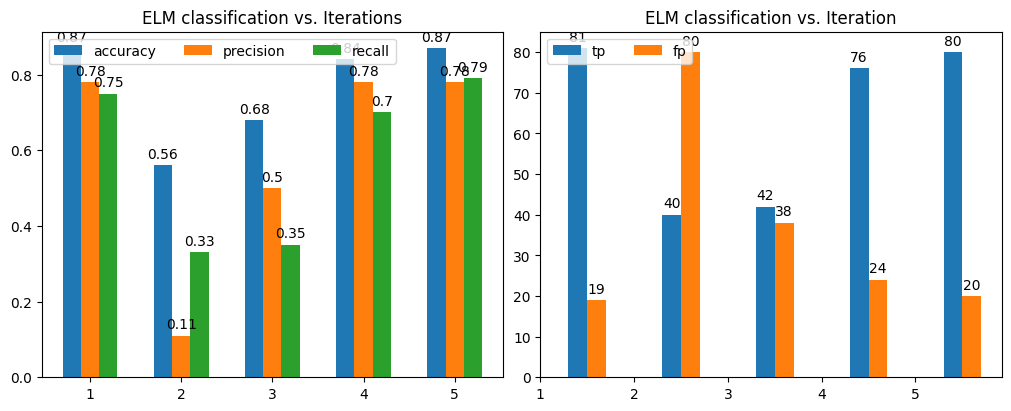

K-Fold Results: 
      tp    fp     tn    fn  accuracy  precision    recall        f1
0  81.0  19.0  181.0  19.0  0.873333   0.781034  0.750000  0.755706
1  40.0  80.0  160.0  80.0  0.555556   0.111111  0.333333  0.166667
2  42.0  38.0  122.0  38.0  0.683333   0.504274  0.350000  0.257735
3  76.0  24.0  176.0  24.0  0.840000   0.775895  0.700000  0.709486
4  80.0  20.0  180.0  20.0  0.866667   0.782301  0.791667  0.778358
Average Results: 
       tp     fp     tn     fn  accuracy  precision  recall       f1
0  319.0  181.0  819.0  181.0  0.763778   0.590923   0.585  0.53359


In [25]:
from utils.vis_utils import plot_bar_metrics

plot_bar_metrics(kfold_cls_results, xticks_label='Fold')

kfold_cls_results_df = pd.DataFrame(kfold_cls_results)
print("K-Fold Results: \n", kfold_cls_results_df)
sum_metrics = kfold_cls_results_df[["tp", "fp", "tn", "fn"]].sum()
mean_metrics = kfold_cls_results_df[["accuracy", "precision", "recall", "f1"]].mean()
avg_results = pd.DataFrame([sum_metrics.tolist() + mean_metrics.tolist()], 
                           columns=sum_metrics.index.tolist() + mean_metrics.index.tolist()
                          )
print("Average Results: \n", avg_results)

## 3. Active Learning with Random Sampling
For active learning, we will use the same config `base.yaml`. We will incrementally add the training shots as we go through the AL iterations. Due to limited available labels, we will keep the same test shots for evaluation at each iteration. The results from evaluations are stored in the metric logger. 

In [4]:
import random

import pandas as pd
from omegaconf import OmegaConf
from copy import copy

from utils.misc import get_files_in_dir
from dataset.datasets import split_data
from trainer import Trainer

cfg = OmegaConf.create(OmegaConf.load("./configs/base.yaml"))


data = [f.split('.')[0] for f in get_files_in_dir(cfg.data.label_dir, file_end='.csv')]
train_shots, test_shots = split_data(data, train_split=cfg.data.train_split, seed=cfg.rng.seed)

al_trainer = Trainer(cfg, exp_name='active_learning_with_random_sampling')

n_cycles = 5
samples_per_cycle = 2
train_sets = copy(train_shots)
sampled_train_sets = []
al_cls_metrics_results = []
al_det_metric_results = []
for i in range(n_cycles):
    
    if not len(train_sets)>samples_per_cycle-1:
        break

    print("Iteration: ", i+1)

    sampled_shots = random.sample(train_sets, k=samples_per_cycle)
    train_sets = [s for s in train_sets if s not in sampled_shots]
    
    sampled_train_sets += sampled_shots
    
    al_trainer.train(sampled_train_sets, test_sets=test_shots)
    al_trainer.save_states(ckpt_name=f"model_states_cycle{i}")
    
    al_cls_metrics_results.append(al_trainer.cls_metric_logger.results)
    if cfg.net.detection:
        al_det_metric_results.append(al_trainer.det_metric_logger.results)

Iteration:  1
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 2, train batch size: 16, train batches: 1

Verifying train dataloader ... 
{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 1/1 [00:00<00:00,  1.81it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.629, loss:    1.750]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 19.60it/s, , elm_cls_loss:    1.120, elm_det_loss:    0.628, loss:    1.748]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 21.11it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.626, loss:    1.746]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 21.94it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.625, loss:    1.745]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 21.53it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.624, loss:    1.742]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.04it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49251 | 1949 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.16it/s, test_loss: 1.742,                             test_cls_acc: 0.200, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from inf to 1.741926.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.741926.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 20.87it/s, , elm_cls_loss:    1.118, elm_det_loss:    0.623, loss:    1.741]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 21.63it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.622, loss:    1.739]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 21.65it/s, , elm_cls_loss:    1.117, elm_det_loss:    0.621, loss:    1.738]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 21.57it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.619, loss:    1.735]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 21.90it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.617, loss:    1.733]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.45it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49521 | 1679 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.731,                             test_cls_acc: 0.200, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.741926 to 1.730653.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.741926 to 1.730653.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 20.52it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.615, loss:    1.730]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 21.92it/s, , elm_cls_loss:    1.114, elm_det_loss:    0.613, loss:    1.727]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 22.94it/s, , elm_cls_loss:    1.113, elm_det_loss:    0.610, loss:    1.723]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 23.18it/s, , elm_cls_loss:    1.111, elm_det_loss:    0.604, loss:    1.716]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 22.55it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.598, loss:    1.707]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.82it/s, test_loss: 1.692,                             test_cls_acc: 0.200, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49357 | 1843 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.75it/s, test_loss: 1.692,                             test_cls_acc: 0.200, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.730653 to 1.691836.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.730653 to 1.691836.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 17.61it/s, , elm_cls_loss:    1.109, elm_det_loss:    0.582, loss:    1.691]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 20.38it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.556, loss:    1.665]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 21.99it/s, , elm_cls_loss:    1.105, elm_det_loss:    0.506, loss:    1.612]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 22.53it/s, , elm_cls_loss:    1.115, elm_det_loss:    0.427, loss:    1.542]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 21.75it/s, , elm_cls_loss:    1.122, elm_det_loss:    0.317, loss:    1.439]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 18.06it/s, test_loss: 1.336,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49350 | 1850 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.84it/s, test_loss: 1.336,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.691836 to 1.336169.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.691836 to 1.336169.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 20.77it/s, , elm_cls_loss:    1.165, elm_det_loss:    0.204, loss:    1.370]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 22.25it/s, , elm_cls_loss:    1.196, elm_det_loss:    0.185, loss:    1.381]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 22.21it/s, , elm_cls_loss:    1.169, elm_det_loss:    0.239, loss:    1.407]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 22.47it/s, , elm_cls_loss:    1.263, elm_det_loss:    0.254, loss:    1.518]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 22.79it/s, , elm_cls_loss:    1.116, elm_det_loss:    0.246, loss:    1.363]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.74it/s, test_loss: 1.281,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49372 | 1828 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.82it/s, test_loss: 1.281,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.336169 to 1.281350.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.336169 to 1.281350.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 20.37it/s, , elm_cls_loss:    1.121, elm_det_loss:    0.228, loss:    1.349]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 22.53it/s, , elm_cls_loss:    1.138, elm_det_loss:    0.184, loss:    1.323]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 22.75it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.171, loss:    1.236]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00, 23.08it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.198, loss:    1.268]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 23.34it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.213, loss:    1.282]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  4.02it/s, test_loss: 1.279,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49298 | 1902 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.83it/s, test_loss: 1.279,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss improved from 1.281350 to 1.278615.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.281350 to 1.278615.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 21.51it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.220, loss:    1.304]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 21.62it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.197, loss:    1.253]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 18.26it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.171, loss:    1.234]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 17.30it/s, , elm_cls_loss:    1.098, elm_det_loss:    0.156, loss:    1.253]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 20.34it/s, , elm_cls_loss:    1.084, elm_det_loss:    0.163, loss:    1.247]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.39it/s, test_loss: 1.230,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49448 | 1752 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.85it/s, test_loss: 1.230,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.278615 to 1.229778.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.278615 to 1.229778.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 17.41it/s, , elm_cls_loss:    1.048, elm_det_loss:    0.160, loss:    1.208]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 17.85it/s, , elm_cls_loss:    1.083, elm_det_loss:    0.168, loss:    1.250]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 18.19it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.157, loss:    1.223]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 19.80it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.160, loss:    1.228]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 20.35it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.166, loss:    1.244]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  3.98it/s, test_loss: 1.228,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49342 | 1858 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.75it/s, test_loss: 1.228,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.229778 to 1.227547.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.229778 to 1.227547.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 20.38it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.175, loss:    1.233]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 22.07it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.170, loss:    1.224]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 21.84it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.162, loss:    1.220]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 22.93it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.156, loss:    1.228]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 22.79it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.159, loss:    1.208]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.84it/s, test_loss: 1.209,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49432 | 1768 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 1.209,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.227547 to 1.208715.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.227547 to 1.208715.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 20.69it/s, , elm_cls_loss:    1.074, elm_det_loss:    0.160, loss:    1.234]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 22.97it/s, , elm_cls_loss:    1.059, elm_det_loss:    0.174, loss:    1.233]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 20.65it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.171, loss:    1.236]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 22.38it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.155, loss:    1.220]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 18.27it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.163, loss:    1.217]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  3.57it/s, test_loss: 1.213,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49373 | 1827 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.75it/s, test_loss: 1.213,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.208715.
Early Stopping: test/loss didn't improve from 1.208715. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 20.81it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.159, loss:    1.223]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 21.54it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.164, loss:    1.228]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 21.48it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.162, loss:    1.222]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 21.69it/s, , elm_cls_loss:    1.037, elm_det_loss:    0.159, loss:    1.196]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 18.84it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.155, loss:    1.205]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.95it/s, test_loss: 1.205,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49431 | 1769 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.41it/s, test_loss: 1.205,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.208715 to 1.205478.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.208715 to 1.205478.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 18.09it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.161, loss:    1.224]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 19.85it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.163, loss:    1.221]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 23.14it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.157, loss:    1.204]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 22.94it/s, , elm_cls_loss:    1.075, elm_det_loss:    0.167, loss:    1.243]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 23.43it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.156, loss:    1.209]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  3.76it/s, test_loss: 1.191,                             test_cls_acc: 0.400, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49632 | 1568 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.75it/s, test_loss: 1.191,                             test_cls_acc: 0.400, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 1.205478 to 1.191346.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.205478 to 1.191346.
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 19.91it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.160, loss:    1.220]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 21.40it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.154, loss:    1.223]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 22.01it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.161, loss:    1.216]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 23.06it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.158, loss:    1.202]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00, 19.21it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.163, loss:    1.213]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.53it/s, test_loss: 1.209,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49347 | 1853 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 1.209,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.191346.
Early Stopping: test/loss didn't improve from 1.191346. Early stopping counter: 1/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 20.32it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.156, loss:    1.216]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 22.51it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.155, loss:    1.195]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 23.03it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.157, loss:    1.221]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 22.29it/s, , elm_cls_loss:    1.070, elm_det_loss:    0.148, loss:    1.218]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 22.26it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.147, loss:    1.211]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.75it/s, test_loss: 1.212,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49256 | 1944 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.70it/s, test_loss: 1.212,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.191346.
Early Stopping: test/loss didn't improve from 1.191346. Early stopping counter: 2/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 20.56it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.152, loss:    1.201]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00, 22.05it/s, , elm_cls_loss:    1.036, elm_det_loss:    0.157, loss:    1.193]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 22.34it/s, , elm_cls_loss:    1.040, elm_det_loss:    0.148, loss:    1.188]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00, 22.33it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.158, loss:    1.208]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00, 21.71it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.156, loss:    1.213]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.36it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49473 | 1727 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 1.191346.
Early Stopping: test/loss didn't improve from 1.191346. Early stopping counter: 3/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 19.63it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.143, loss:    1.198]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 21.95it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.143, loss:    1.201]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 22.09it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.149, loss:    1.215]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 22.56it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.150, loss:    1.207]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 22.73it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.143, loss:    1.199]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.42it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49469 | 1731 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 1.196,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 1.191346.
Early Stopping: test/loss didn't improve from 1.191346. Early stopping counter: 4/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 19.36it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.142, loss:    1.205]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 21.96it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.142, loss:    1.195]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00, 21.92it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.144, loss:    1.204]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 20.19it/s, , elm_cls_loss:    1.051, elm_det_loss:    0.147, loss:    1.197]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 20.40it/s, , elm_cls_loss:    1.029, elm_det_loss:    0.143, loss:    1.172]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.82it/s, test_loss: 1.199,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49365 | 1835 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.51it/s, test_loss: 1.199,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 1.191346.
Early Stopping: test/loss didn't improve from 1.191346. Early stopping counter: 5/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 16.82it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.140, loss:    1.202]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 20.74it/s, , elm_cls_loss:    1.065, elm_det_loss:    0.143, loss:    1.208]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 18.40it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.138, loss:    1.188]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00, 19.07it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.140, loss:    1.202]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 23.97it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.134, loss:    1.195]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.31it/s, test_loss: 1.198,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49327 | 1873 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.77it/s, test_loss: 1.198,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.191346.
Early Stopping: test/loss didn't improve from 1.191346. Early stopping counter: 6/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 20.83it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.147, loss:    1.191]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 23.02it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.142, loss:    1.204]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 23.34it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.129, loss:    1.190]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 21.90it/s, , elm_cls_loss:    1.054, elm_det_loss:    0.135, loss:    1.189]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 21.15it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.138, loss:    1.195]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.40it/s, test_loss: 1.186,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49275 | 1925 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.60it/s, test_loss: 1.186,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.191346 to 1.186321.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.191346 to 1.186321.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00, 20.42it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.130, loss:    1.177]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00, 22.64it/s, , elm_cls_loss:    1.047, elm_det_loss:    0.125, loss:    1.171]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00, 19.59it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.125, loss:    1.189]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00, 22.38it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.124, loss:    1.180]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00, 22.65it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.128, loss:    1.177]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  3.16it/s, test_loss: 1.176,                             test_cls_acc: 0.400, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49496 | 1704 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.63it/s, test_loss: 1.176,                             test_cls_acc: 0.400, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.186321 to 1.176467.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.186321 to 1.176467.
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 19.68it/s, , elm_cls_loss:    1.064, elm_det_loss:    0.109, loss:    1.173]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00, 22.40it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.116, loss:    1.177]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00, 22.60it/s, , elm_cls_loss:    1.079, elm_det_loss:    0.115, loss:    1.193]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00, 21.59it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.126, loss:    1.193]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00, 22.19it/s, , elm_cls_loss:    1.044, elm_det_loss:    0.111, loss:    1.155]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.72it/s, test_loss: 1.166,                             test_cls_acc: 0.400, test_det_acc: 0.968]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49561 | 1639 |      0.968 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.166,                             test_cls_acc: 0.400, test_det_acc: 0.968]


Modelcheckpoint: test/loss improved from 1.176467 to 1.166230.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.176467 to 1.166230.
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00, 20.68it/s, , elm_cls_loss:    1.077, elm_det_loss:    0.114, loss:    1.191]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00, 19.60it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.116, loss:    1.169]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00, 22.89it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.114, loss:    1.164]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00, 21.82it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.114, loss:    1.163]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00, 19.91it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.110, loss:    1.182]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.81it/s, test_loss: 1.155,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49414 | 1786 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 1.155,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.166230 to 1.154931.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.166230 to 1.154931.
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00, 20.72it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.107, loss:    1.179]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00, 21.15it/s, , elm_cls_loss:    1.058, elm_det_loss:    0.095, loss:    1.153]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00, 19.19it/s, , elm_cls_loss:    1.076, elm_det_loss:    0.097, loss:    1.173]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00, 19.60it/s, , elm_cls_loss:    1.073, elm_det_loss:    0.101, loss:    1.173]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00, 21.98it/s, , elm_cls_loss:    1.069, elm_det_loss:    0.104, loss:    1.174]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.97it/s, test_loss: 1.139,                             test_cls_acc: 0.390, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   39 |   61 |  139 |   61 |      0.593 |       0.131 |    0.325 | 0.187 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.59it/s, test_loss: 1.139,                             test_cls_acc: 0.390, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.154931 to 1.139285.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.154931 to 1.139285.
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00, 19.92it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.087, loss:    1.143]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00, 21.70it/s, , elm_cls_loss:    1.072, elm_det_loss:    0.087, loss:    1.159]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00, 22.08it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.089, loss:    1.149]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00, 22.04it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.091, loss:    1.152]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00, 22.68it/s, , elm_cls_loss:    1.063, elm_det_loss:    0.079, loss:    1.142]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.54it/s, test_loss: 1.131,                             test_cls_acc: 0.400, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.259 |    0.333 | 0.229 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49622 | 1578 |      0.969 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.131,                             test_cls_acc: 0.400, test_det_acc: 0.969]


Modelcheckpoint: test/loss improved from 1.139285 to 1.130954.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.139285 to 1.130954.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00, 20.45it/s, , elm_cls_loss:    1.062, elm_det_loss:    0.079, loss:    1.141]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00, 21.96it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.081, loss:    1.142]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00, 21.52it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.076, loss:    1.156]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00, 22.07it/s, , elm_cls_loss:    1.087, elm_det_loss:    0.072, loss:    1.158]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00, 21.49it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.072, loss:    1.152]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.15it/s, test_loss: 1.127,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49463 | 1737 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.42it/s, test_loss: 1.127,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.130954 to 1.127453.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.130954 to 1.127453.
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00, 21.26it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.073, loss:    1.128]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00, 22.36it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.063, loss:    1.134]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00, 21.89it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.061, loss:    1.121]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00, 18.78it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.068, loss:    1.148]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00, 21.36it/s, , elm_cls_loss:    1.056, elm_det_loss:    0.060, loss:    1.116]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.71it/s, test_loss: 1.120,                             test_cls_acc: 0.400, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49379 | 1821 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.75it/s, test_loss: 1.120,                             test_cls_acc: 0.400, test_det_acc: 0.964]


Modelcheckpoint: test/loss improved from 1.127453 to 1.119515.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.127453 to 1.119515.
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00, 20.48it/s, , elm_cls_loss:    1.081, elm_det_loss:    0.056, loss:    1.138]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00, 20.63it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.061, loss:    1.128]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00, 22.02it/s, , elm_cls_loss:    1.068, elm_det_loss:    0.064, loss:    1.132]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00, 22.22it/s, , elm_cls_loss:    1.080, elm_det_loss:    0.054, loss:    1.135]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00, 21.64it/s, , elm_cls_loss:    1.055, elm_det_loss:    0.054, loss:    1.109]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.97it/s, test_loss: 1.122,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49395 | 1805 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 1.122,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.119515.
Early Stopping: test/loss didn't improve from 1.119515. Early stopping counter: 1/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00, 20.30it/s, , elm_cls_loss:    1.067, elm_det_loss:    0.056, loss:    1.123]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00, 22.79it/s, , elm_cls_loss:    1.057, elm_det_loss:    0.055, loss:    1.113]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00, 22.87it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.054, loss:    1.125]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00, 22.39it/s, , elm_cls_loss:    1.060, elm_det_loss:    0.050, loss:    1.110]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00, 22.71it/s, , elm_cls_loss:    1.046, elm_det_loss:    0.054, loss:    1.100]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.39it/s, test_loss: 1.110,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49396 | 1804 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 1.110,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.119515 to 1.110482.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.119515 to 1.110482.
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00, 19.85it/s, , elm_cls_loss:    1.078, elm_det_loss:    0.053, loss:    1.131]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00, 20.72it/s, , elm_cls_loss:    1.052, elm_det_loss:    0.049, loss:    1.102]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00, 20.75it/s, , elm_cls_loss:    1.053, elm_det_loss:    0.052, loss:    1.104]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00, 22.92it/s, , elm_cls_loss:    1.061, elm_det_loss:    0.052, loss:    1.113]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00, 22.50it/s, , elm_cls_loss:    1.049, elm_det_loss:    0.050, loss:    1.099]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 1.106,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49266 | 1934 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.37it/s, test_loss: 1.106,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.110482 to 1.105905.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.110482 to 1.105905.
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00, 21.07it/s, , elm_cls_loss:    1.032, elm_det_loss:    0.052, loss:    1.083]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00, 21.00it/s, , elm_cls_loss:    1.066, elm_det_loss:    0.046, loss:    1.112]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00, 22.75it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.042, loss:    1.113]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00, 23.06it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.045, loss:    1.095]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00, 23.09it/s, , elm_cls_loss:    1.024, elm_det_loss:    0.048, loss:    1.072]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.46it/s, test_loss: 1.108,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49421 | 1779 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.108,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 1.105905.
Early Stopping: test/loss didn't improve from 1.105905. Early stopping counter: 1/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00, 18.52it/s, , elm_cls_loss:    1.050, elm_det_loss:    0.046, loss:    1.097]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00, 21.68it/s, , elm_cls_loss:    1.037, elm_det_loss:    0.049, loss:    1.086]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00, 20.90it/s, , elm_cls_loss:    1.018, elm_det_loss:    0.051, loss:    1.069]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00, 20.08it/s, , elm_cls_loss:    1.019, elm_det_loss:    0.047, loss:    1.066]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00, 20.87it/s, , elm_cls_loss:    0.992, elm_det_loss:    0.053, loss:    1.044]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.21it/s, test_loss: 1.114,                             test_cls_acc: 0.400, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49449 | 1751 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 1.114,                             test_cls_acc: 0.400, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 1.105905.
Early Stopping: test/loss didn't improve from 1.105905. Early stopping counter: 2/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00, 19.27it/s, , elm_cls_loss:    0.999, elm_det_loss:    0.056, loss:    1.055]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00, 21.35it/s, , elm_cls_loss:    0.991, elm_det_loss:    0.061, loss:    1.052]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00, 22.56it/s, , elm_cls_loss:    1.026, elm_det_loss:    0.060, loss:    1.086]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00, 21.05it/s, , elm_cls_loss:    0.969, elm_det_loss:    0.069, loss:    1.038]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00, 21.53it/s, , elm_cls_loss:    0.964, elm_det_loss:    0.057, loss:    1.021]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 1.140,                             test_cls_acc: 0.400, test_det_acc: 0.963]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49296 | 1904 |      0.963 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.40it/s, test_loss: 1.140,                             test_cls_acc: 0.400, test_det_acc: 0.963]


Modelcheckpoint: test/loss didn't improved from 1.105905.
Early Stopping: test/loss didn't improve from 1.105905. Early stopping counter: 3/10
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    0.989, elm_det_loss:    0.052, loss:    1.040]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00, 21.49it/s, , elm_cls_loss:    0.982, elm_det_loss:    0.053, loss:    1.035]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00, 22.49it/s, , elm_cls_loss:    0.990, elm_det_loss:    0.067, loss:    1.057]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00, 22.64it/s, , elm_cls_loss:    0.938, elm_det_loss:    0.065, loss:    1.003]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00, 22.09it/s, , elm_cls_loss:    0.936, elm_det_loss:    0.055, loss:    0.990]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.44it/s, test_loss: 1.137,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49239 | 1961 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 1.137,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss didn't improved from 1.105905.
Early Stopping: test/loss didn't improve from 1.105905. Early stopping counter: 4/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00, 20.26it/s, , elm_cls_loss:    0.983, elm_det_loss:    0.051, loss:    1.033]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00, 22.44it/s, , elm_cls_loss:    0.924, elm_det_loss:    0.056, loss:    0.979]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00, 23.03it/s, , elm_cls_loss:    0.936, elm_det_loss:    0.067, loss:    1.003]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00, 23.78it/s, , elm_cls_loss:    0.951, elm_det_loss:    0.069, loss:    1.020]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00, 22.52it/s, , elm_cls_loss:    0.932, elm_det_loss:    0.065, loss:    0.997]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.79it/s, test_loss: 1.079,                             test_cls_acc: 0.400, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49399 | 1801 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 1.079,                             test_cls_acc: 0.400, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.105905 to 1.078696.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.105905 to 1.078696.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00, 20.40it/s, , elm_cls_loss:    0.892, elm_det_loss:    0.049, loss:    0.940]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00, 21.95it/s, , elm_cls_loss:    0.920, elm_det_loss:    0.048, loss:    0.967]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00, 21.29it/s, , elm_cls_loss:    0.896, elm_det_loss:    0.054, loss:    0.950]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00, 20.25it/s, , elm_cls_loss:    0.893, elm_det_loss:    0.057, loss:    0.950]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00, 21.81it/s, , elm_cls_loss:    0.851, elm_det_loss:    0.065, loss:    0.916]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.39it/s, test_loss: 1.067,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49273 | 1927 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.40it/s, test_loss: 1.067,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.078696 to 1.067390.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.078696 to 1.067390.
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00, 21.08it/s, , elm_cls_loss:    0.891, elm_det_loss:    0.056, loss:    0.947]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00, 22.04it/s, , elm_cls_loss:    0.846, elm_det_loss:    0.049, loss:    0.895]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00, 21.24it/s, , elm_cls_loss:    0.882, elm_det_loss:    0.047, loss:    0.929]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00, 22.12it/s, , elm_cls_loss:    0.854, elm_det_loss:    0.048, loss:    0.902]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00, 20.51it/s, , elm_cls_loss:    0.855, elm_det_loss:    0.052, loss:    0.907]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.96it/s, test_loss: 1.028,                             test_cls_acc: 0.590, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   59 |   41 |  159 |   41 |      0.727 |       0.498 |    0.492 | 0.435 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49466 | 1734 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.80it/s, test_loss: 1.028,                             test_cls_acc: 0.590, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.067390 to 1.028201.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.067390 to 1.028201.
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00, 20.12it/s, , elm_cls_loss:    0.863, elm_det_loss:    0.056, loss:    0.919]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00, 20.40it/s, , elm_cls_loss:    0.882, elm_det_loss:    0.056, loss:    0.938]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00, 21.37it/s, , elm_cls_loss:    0.883, elm_det_loss:    0.051, loss:    0.934]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00, 21.66it/s, , elm_cls_loss:    0.918, elm_det_loss:    0.048, loss:    0.966]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00, 22.13it/s, , elm_cls_loss:    0.882, elm_det_loss:    0.046, loss:    0.928]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.18it/s, test_loss: 1.031,                             test_cls_acc: 0.760, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.519 |    0.633 | 0.566 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49458 | 1742 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 1.031,                             test_cls_acc: 0.760, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 1.028201.
Early Stopping: test/loss didn't improve from 1.028201. Early stopping counter: 1/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00, 19.84it/s, , elm_cls_loss:    0.829, elm_det_loss:    0.060, loss:    0.889]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00, 20.38it/s, , elm_cls_loss:    0.850, elm_det_loss:    0.048, loss:    0.898]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00, 23.10it/s, , elm_cls_loss:    0.819, elm_det_loss:    0.047, loss:    0.866]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00, 21.93it/s, , elm_cls_loss:    0.841, elm_det_loss:    0.043, loss:    0.884]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00, 23.06it/s, , elm_cls_loss:    0.787, elm_det_loss:    0.050, loss:    0.837]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.56it/s, test_loss: 0.952,                             test_cls_acc: 0.790, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.547 |    0.658 | 0.592 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49522 | 1678 |      0.967 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 0.952,                             test_cls_acc: 0.790, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 1.028201 to 0.952495.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.028201 to 0.952495.
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00, 20.11it/s, , elm_cls_loss:    0.831, elm_det_loss:    0.065, loss:    0.897]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00, 22.05it/s, , elm_cls_loss:    0.856, elm_det_loss:    0.061, loss:    0.917]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00, 19.88it/s, , elm_cls_loss:    0.910, elm_det_loss:    0.058, loss:    0.968]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00, 22.44it/s, , elm_cls_loss:    0.809, elm_det_loss:    0.058, loss:    0.868]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00, 22.69it/s, , elm_cls_loss:    0.835, elm_det_loss:    0.055, loss:    0.890]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.36it/s, test_loss: 1.165,                             test_cls_acc: 0.790, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.539 |    0.658 | 0.589 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49439 | 1761 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  1.39it/s, test_loss: 1.165,                             test_cls_acc: 0.790, test_det_acc: 0.966]


Modelcheckpoint: test/loss didn't improved from 0.952495.
Early Stopping: test/loss didn't improve from 0.952495. Early stopping counter: 1/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00, 20.67it/s, , elm_cls_loss:    0.849, elm_det_loss:    0.057, loss:    0.906]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00, 21.60it/s, , elm_cls_loss:    0.784, elm_det_loss:    0.050, loss:    0.834]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00, 21.10it/s, , elm_cls_loss:    0.822, elm_det_loss:    0.048, loss:    0.870]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00, 22.35it/s, , elm_cls_loss:    0.803, elm_det_loss:    0.050, loss:    0.853]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00, 20.70it/s, , elm_cls_loss:    0.773, elm_det_loss:    0.049, loss:    0.822]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.99it/s, test_loss: 0.999,                             test_cls_acc: 0.730, test_det_acc: 0.964]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.514 |    0.608 | 0.546 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49349 | 1851 |      0.964 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 0.999,                             test_cls_acc: 0.730, test_det_acc: 0.964]


Modelcheckpoint: test/loss didn't improved from 0.952495.
Early Stopping: test/loss didn't improve from 0.952495. Early stopping counter: 2/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00, 19.95it/s, , elm_cls_loss:    0.845, elm_det_loss:    0.050, loss:    0.895]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00, 21.42it/s, , elm_cls_loss:    0.775, elm_det_loss:    0.046, loss:    0.820]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00, 21.86it/s, , elm_cls_loss:    0.783, elm_det_loss:    0.049, loss:    0.832]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00, 22.33it/s, , elm_cls_loss:    0.755, elm_det_loss:    0.052, loss:    0.807]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00, 21.18it/s, , elm_cls_loss:    0.742, elm_det_loss:    0.044, loss:    0.786]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.42it/s, test_loss: 0.844,                             test_cls_acc: 0.760, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.508 |    0.633 | 0.564 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49479 | 1721 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.844,                             test_cls_acc: 0.760, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 0.952495 to 0.843506.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.952495 to 0.843506.
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00, 19.93it/s, , elm_cls_loss:    0.784, elm_det_loss:    0.060, loss:    0.844]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00, 21.84it/s, , elm_cls_loss:    0.733, elm_det_loss:    0.047, loss:    0.780]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00, 21.01it/s, , elm_cls_loss:    0.685, elm_det_loss:    0.050, loss:    0.735]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00, 18.93it/s, , elm_cls_loss:    0.673, elm_det_loss:    0.043, loss:    0.715]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00, 22.52it/s, , elm_cls_loss:    0.643, elm_det_loss:    0.044, loss:    0.686]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 17.07it/s, test_loss: 0.926,                             test_cls_acc: 0.720, test_det_acc: 0.960]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.491 |      0.6 | 0.536 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |    2 |    1 | 49139 | 2058 |       0.96 |       0.667 |    0.001 | 0.002 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.75it/s, test_loss: 0.926,                             test_cls_acc: 0.720, test_det_acc: 0.960]


Modelcheckpoint: test/loss didn't improved from 0.843506.
Early Stopping: test/loss didn't improve from 0.843506. Early stopping counter: 1/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00, 20.96it/s, , elm_cls_loss:    0.701, elm_det_loss:    0.050, loss:    0.751]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00, 21.59it/s, , elm_cls_loss:    0.683, elm_det_loss:    0.058, loss:    0.741]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00, 22.07it/s, , elm_cls_loss:    0.632, elm_det_loss:    0.052, loss:    0.684]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00, 22.88it/s, , elm_cls_loss:    0.633, elm_det_loss:    0.055, loss:    0.687]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00, 18.45it/s, , elm_cls_loss:    0.676, elm_det_loss:    0.046, loss:    0.721]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.31it/s, test_loss: 0.664,                             test_cls_acc: 0.760, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.517 |    0.633 | 0.566 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |    1 |    2 | 49249 | 1948 |      0.962 |       0.333 |    0.001 | 0.001 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.37it/s, test_loss: 0.664,                             test_cls_acc: 0.760, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 0.843506 to 0.664195.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.843506 to 0.664195.
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00, 20.92it/s, , elm_cls_loss:    0.631, elm_det_loss:    0.048, loss:    0.679]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00, 21.44it/s, , elm_cls_loss:    0.667, elm_det_loss:    0.045, loss:    0.712]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00, 21.91it/s, , elm_cls_loss:    0.688, elm_det_loss:    0.043, loss:    0.731]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00, 22.50it/s, , elm_cls_loss:    0.620, elm_det_loss:    0.046, loss:    0.666]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00, 22.85it/s, , elm_cls_loss:    0.585, elm_det_loss:    0.075, loss:    0.660]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.17it/s, test_loss: 0.753,                             test_cls_acc: 0.710, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.476 |    0.592 | 0.527 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   17 |    2 | 49370 | 1811 |      0.965 |       0.895 |    0.009 | 0.018 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.753,                             test_cls_acc: 0.710, test_det_acc: 0.965]


Modelcheckpoint: test/loss didn't improved from 0.664195.
Early Stopping: test/loss didn't improve from 0.664195. Early stopping counter: 1/10
Epoch 220/1000


100%|██████████| 1/1 [00:00<00:00, 17.50it/s, , elm_cls_loss:    0.554, elm_det_loss:    0.049, loss:    0.602]


Epoch 221/1000


100%|██████████| 1/1 [00:00<00:00, 21.59it/s, , elm_cls_loss:    0.590, elm_det_loss:    0.045, loss:    0.635]


Epoch 222/1000


100%|██████████| 1/1 [00:00<00:00, 23.35it/s, , elm_cls_loss:    0.615, elm_det_loss:    0.044, loss:    0.659]


Epoch 223/1000


100%|██████████| 1/1 [00:00<00:00, 22.75it/s, , elm_cls_loss:    0.599, elm_det_loss:    0.039, loss:    0.638]


Epoch 224/1000


100%|██████████| 1/1 [00:00<00:00, 23.20it/s, , elm_cls_loss:    0.613, elm_det_loss:    0.044, loss:    0.658]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.02it/s, test_loss: 0.642,                             test_cls_acc: 0.760, test_det_acc: 0.967]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.517 |    0.633 | 0.566 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |   37 |    7 | 49498 | 1658 |      0.967 |       0.841 |    0.022 | 0.043 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 0.642,                             test_cls_acc: 0.760, test_det_acc: 0.967]


Modelcheckpoint: test/loss improved from 0.664195 to 0.642341.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.664195 to 0.642341.
Epoch 225/1000


100%|██████████| 1/1 [00:00<00:00, 21.10it/s, , elm_cls_loss:    0.579, elm_det_loss:    0.043, loss:    0.622]


Epoch 226/1000


100%|██████████| 1/1 [00:00<00:00, 22.89it/s, , elm_cls_loss:    0.568, elm_det_loss:    0.047, loss:    0.614]


Epoch 227/1000


100%|██████████| 1/1 [00:00<00:00, 21.97it/s, , elm_cls_loss:    0.656, elm_det_loss:    0.059, loss:    0.715]


Epoch 228/1000


100%|██████████| 1/1 [00:00<00:00, 22.33it/s, , elm_cls_loss:    0.549, elm_det_loss:    0.048, loss:    0.597]


Epoch 229/1000


100%|██████████| 1/1 [00:00<00:00, 23.24it/s, , elm_cls_loss:    0.566, elm_det_loss:    0.037, loss:    0.604]

Evaluating



100%|██████████| 1/1 [00:00<00:00, 16.43it/s, test_loss: 0.649,                             test_cls_acc: 0.760, test_det_acc: 0.969]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.519 |    0.633 | 0.566 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  257 |    6 | 49334 | 1603 |      0.969 |       0.977 |    0.138 | 0.242 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 0.649,                             test_cls_acc: 0.760, test_det_acc: 0.969]


Modelcheckpoint: test/loss didn't improved from 0.642341.
Early Stopping: test/loss didn't improve from 0.642341. Early stopping counter: 1/10
Epoch 230/1000


100%|██████████| 1/1 [00:00<00:00, 14.28it/s, , elm_cls_loss:    0.559, elm_det_loss:    0.038, loss:    0.597]


Epoch 231/1000


100%|██████████| 1/1 [00:00<00:00, 18.94it/s, , elm_cls_loss:    0.599, elm_det_loss:    0.038, loss:    0.638]


Epoch 232/1000


100%|██████████| 1/1 [00:00<00:00, 21.84it/s, , elm_cls_loss:    0.544, elm_det_loss:    0.035, loss:    0.579]


Epoch 233/1000


100%|██████████| 1/1 [00:00<00:00, 21.75it/s, , elm_cls_loss:    0.540, elm_det_loss:    0.048, loss:    0.589]


Epoch 234/1000


100%|██████████| 1/1 [00:00<00:00, 21.25it/s, , elm_cls_loss:    0.612, elm_det_loss:    0.058, loss:    0.671]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.05it/s, test_loss: 0.694,                             test_cls_acc: 0.710, test_det_acc: 0.977]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   71 |   29 |  171 |   29 |      0.807 |       0.473 |    0.592 | 0.526 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  744 |  126 | 49299 | 1031 |      0.977 |       0.855 |    0.419 | 0.563 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.25it/s, test_loss: 0.694,                             test_cls_acc: 0.710, test_det_acc: 0.977]


Modelcheckpoint: test/loss didn't improved from 0.642341.
Early Stopping: test/loss didn't improve from 0.642341. Early stopping counter: 2/10
Epoch 235/1000


100%|██████████| 1/1 [00:00<00:00, 18.97it/s, , elm_cls_loss:    0.585, elm_det_loss:    0.059, loss:    0.644]


Epoch 236/1000


100%|██████████| 1/1 [00:00<00:00, 21.36it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.049, loss:    0.560]


Epoch 237/1000


100%|██████████| 1/1 [00:00<00:00, 21.33it/s, , elm_cls_loss:    0.524, elm_det_loss:    0.048, loss:    0.572]


Epoch 238/1000


100%|██████████| 1/1 [00:00<00:00, 21.41it/s, , elm_cls_loss:    0.563, elm_det_loss:    0.039, loss:    0.601]


Epoch 239/1000


100%|██████████| 1/1 [00:00<00:00, 20.37it/s, , elm_cls_loss:    0.513, elm_det_loss:    0.043, loss:    0.556]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.35it/s, test_loss: 0.801,                             test_cls_acc: 0.730, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.821 |    0.617 | 0.569 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1131 |  150 | 49213 |  706 |      0.983 |       0.883 |    0.616 | 0.725 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.801,                             test_cls_acc: 0.730, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.642341.
Early Stopping: test/loss didn't improve from 0.642341. Early stopping counter: 3/10
Epoch 240/1000


100%|██████████| 1/1 [00:00<00:00, 20.53it/s, , elm_cls_loss:    0.556, elm_det_loss:    0.037, loss:    0.593]


Epoch 241/1000


100%|██████████| 1/1 [00:00<00:00, 21.84it/s, , elm_cls_loss:    0.555, elm_det_loss:    0.052, loss:    0.607]


Epoch 242/1000


100%|██████████| 1/1 [00:00<00:00, 21.19it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.043, loss:    0.535]


Epoch 243/1000


100%|██████████| 1/1 [00:00<00:00, 21.86it/s, , elm_cls_loss:    0.547, elm_det_loss:    0.041, loss:    0.588]


Epoch 244/1000


100%|██████████| 1/1 [00:00<00:00, 22.27it/s, , elm_cls_loss:    0.581, elm_det_loss:    0.045, loss:    0.627]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.79it/s, test_loss: 0.579,                             test_cls_acc: 0.750, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.603 |    0.633 | 0.59 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1518 |  475 | 48782 |  425 |      0.982 |       0.762 |    0.781 | 0.771 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.579,                             test_cls_acc: 0.750, test_det_acc: 0.982]


Modelcheckpoint: test/loss improved from 0.642341 to 0.579487.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.642341 to 0.579487.
Epoch 245/1000


100%|██████████| 1/1 [00:00<00:00, 20.23it/s, , elm_cls_loss:    0.600, elm_det_loss:    0.043, loss:    0.643]


Epoch 246/1000


100%|██████████| 1/1 [00:00<00:00, 21.55it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.044, loss:    0.556]


Epoch 247/1000


100%|██████████| 1/1 [00:00<00:00, 21.81it/s, , elm_cls_loss:    0.560, elm_det_loss:    0.038, loss:    0.598]


Epoch 248/1000


100%|██████████| 1/1 [00:00<00:00, 21.27it/s, , elm_cls_loss:    0.503, elm_det_loss:    0.042, loss:    0.545]


Epoch 249/1000


100%|██████████| 1/1 [00:00<00:00, 21.90it/s, , elm_cls_loss:    0.409, elm_det_loss:    0.039, loss:    0.447]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.95it/s, test_loss: 0.668,                             test_cls_acc: 0.780, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.724 |    0.683 | 0.67 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1197 |  252 | 49130 |  621 |      0.983 |       0.826 |    0.658 | 0.733 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.668,                             test_cls_acc: 0.780, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 1/10
Epoch 250/1000


100%|██████████| 1/1 [00:00<00:00, 20.11it/s, , elm_cls_loss:    0.650, elm_det_loss:    0.054, loss:    0.704]


Epoch 251/1000


100%|██████████| 1/1 [00:00<00:00, 21.97it/s, , elm_cls_loss:    0.404, elm_det_loss:    0.043, loss:    0.448]


Epoch 252/1000


100%|██████████| 1/1 [00:00<00:00, 22.03it/s, , elm_cls_loss:    0.502, elm_det_loss:    0.046, loss:    0.548]


Epoch 253/1000


100%|██████████| 1/1 [00:00<00:00, 21.73it/s, , elm_cls_loss:    0.612, elm_det_loss:    0.043, loss:    0.656]


Epoch 254/1000


100%|██████████| 1/1 [00:00<00:00, 22.45it/s, , elm_cls_loss:    0.461, elm_det_loss:    0.043, loss:    0.504]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  2.20it/s, test_loss: 0.715,                             test_cls_acc: 0.720, test_det_acc: 0.976]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.651 |     0.65 | 0.647 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1496 |  829 | 48453 |  422 |      0.976 |       0.643 |     0.78 | 0.705 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.33it/s, test_loss: 0.715,                             test_cls_acc: 0.720, test_det_acc: 0.976]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 2/10
Epoch 255/1000


100%|██████████| 1/1 [00:00<00:00, 18.01it/s, , elm_cls_loss:    0.598, elm_det_loss:    0.045, loss:    0.643]


Epoch 256/1000


100%|██████████| 1/1 [00:00<00:00, 19.15it/s, , elm_cls_loss:    0.579, elm_det_loss:    0.046, loss:    0.624]


Epoch 257/1000


100%|██████████| 1/1 [00:00<00:00, 16.69it/s, , elm_cls_loss:    0.512, elm_det_loss:    0.043, loss:    0.555]


Epoch 258/1000


100%|██████████| 1/1 [00:00<00:00, 20.68it/s, , elm_cls_loss:    0.538, elm_det_loss:    0.041, loss:    0.579]


Epoch 259/1000


100%|██████████| 1/1 [00:00<00:00, 21.77it/s, , elm_cls_loss:    0.473, elm_det_loss:    0.041, loss:    0.514]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.98it/s, test_loss: 0.727,                             test_cls_acc: 0.730, test_det_acc: 0.981]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.624 |    0.633 | 0.615 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1520 |  697 | 48700 |  283 |      0.981 |       0.686 |    0.843 | 0.756 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 0.727,                             test_cls_acc: 0.730, test_det_acc: 0.981]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 3/10
Epoch 260/1000


100%|██████████| 1/1 [00:00<00:00, 19.99it/s, , elm_cls_loss:    0.508, elm_det_loss:    0.044, loss:    0.551]


Epoch 261/1000


100%|██████████| 1/1 [00:00<00:00, 20.83it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.050, loss:    0.519]


Epoch 262/1000


100%|██████████| 1/1 [00:00<00:00, 19.94it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.100, loss:    0.570]


Epoch 263/1000


100%|██████████| 1/1 [00:00<00:00, 18.21it/s, , elm_cls_loss:    0.501, elm_det_loss:    0.046, loss:    0.548]


Epoch 264/1000


100%|██████████| 1/1 [00:00<00:00, 21.49it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.040, loss:    0.551]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.45it/s, test_loss: 0.671,                             test_cls_acc: 0.730, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.668 |    0.667 | 0.666 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1364 |  340 | 49093 |  403 |      0.985 |         0.8 |    0.772 | 0.786 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.74it/s, test_loss: 0.671,                             test_cls_acc: 0.730, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 4/10
Epoch 265/1000


100%|██████████| 1/1 [00:00<00:00, 20.89it/s, , elm_cls_loss:    0.481, elm_det_loss:    0.038, loss:    0.519]


Epoch 266/1000


100%|██████████| 1/1 [00:00<00:00, 20.53it/s, , elm_cls_loss:    0.477, elm_det_loss:    0.036, loss:    0.513]


Epoch 267/1000


100%|██████████| 1/1 [00:00<00:00, 20.65it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.041, loss:    0.533]


Epoch 268/1000


100%|██████████| 1/1 [00:00<00:00, 22.19it/s, , elm_cls_loss:    0.558, elm_det_loss:    0.038, loss:    0.596]


Epoch 269/1000


100%|██████████| 1/1 [00:00<00:00, 19.41it/s, , elm_cls_loss:    0.470, elm_det_loss:    0.041, loss:    0.511]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.02it/s, test_loss: 0.618,                             test_cls_acc: 0.750, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.621 |    0.642 | 0.612 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1409 |  321 | 49123 |  347 |      0.987 |       0.814 |    0.802 | 0.808 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.618,                             test_cls_acc: 0.750, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 5/10
Epoch 270/1000


100%|██████████| 1/1 [00:00<00:00, 20.49it/s, , elm_cls_loss:    0.473, elm_det_loss:    0.035, loss:    0.507]


Epoch 271/1000


100%|██████████| 1/1 [00:00<00:00, 20.76it/s, , elm_cls_loss:    0.507, elm_det_loss:    0.040, loss:    0.547]


Epoch 272/1000


100%|██████████| 1/1 [00:00<00:00, 21.80it/s, , elm_cls_loss:    0.548, elm_det_loss:    0.034, loss:    0.583]


Epoch 273/1000


100%|██████████| 1/1 [00:00<00:00, 21.67it/s, , elm_cls_loss:    0.446, elm_det_loss:    0.041, loss:    0.487]


Epoch 274/1000


100%|██████████| 1/1 [00:00<00:00, 19.53it/s, , elm_cls_loss:    0.495, elm_det_loss:    0.041, loss:    0.536]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.98it/s, test_loss: 0.716,                             test_cls_acc: 0.700, test_det_acc: 0.981]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.633 |    0.633 | 0.633 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1522 |  720 | 48727 |  231 |      0.981 |       0.679 |    0.868 | 0.762 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.22it/s, test_loss: 0.716,                             test_cls_acc: 0.700, test_det_acc: 0.981]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 6/10
Epoch 275/1000


100%|██████████| 1/1 [00:00<00:00, 20.08it/s, , elm_cls_loss:    0.487, elm_det_loss:    0.038, loss:    0.525]


Epoch 276/1000


100%|██████████| 1/1 [00:00<00:00, 19.57it/s, , elm_cls_loss:    0.478, elm_det_loss:    0.062, loss:    0.540]


Epoch 277/1000


100%|██████████| 1/1 [00:00<00:00, 21.36it/s, , elm_cls_loss:    0.512, elm_det_loss:    0.061, loss:    0.573]


Epoch 278/1000


100%|██████████| 1/1 [00:00<00:00, 21.89it/s, , elm_cls_loss:    0.487, elm_det_loss:    0.047, loss:    0.534]


Epoch 279/1000


100%|██████████| 1/1 [00:00<00:00, 21.84it/s, , elm_cls_loss:    0.524, elm_det_loss:    0.038, loss:    0.562]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.48it/s, test_loss: 0.624,                             test_cls_acc: 0.790, test_det_acc: 0.973]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.737 |    0.692 | 0.678 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1772 | 1128 | 48047 |  253 |      0.973 |       0.611 |    0.875 | 0.72 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.624,                             test_cls_acc: 0.790, test_det_acc: 0.973]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 7/10
Epoch 280/1000


100%|██████████| 1/1 [00:00<00:00, 20.27it/s, , elm_cls_loss:    0.549, elm_det_loss:    0.051, loss:    0.600]


Epoch 281/1000


100%|██████████| 1/1 [00:00<00:00, 21.53it/s, , elm_cls_loss:    0.531, elm_det_loss:    0.054, loss:    0.585]


Epoch 282/1000


100%|██████████| 1/1 [00:00<00:00, 22.09it/s, , elm_cls_loss:    0.511, elm_det_loss:    0.057, loss:    0.567]


Epoch 283/1000


100%|██████████| 1/1 [00:00<00:00, 22.20it/s, , elm_cls_loss:    0.415, elm_det_loss:    0.038, loss:    0.452]


Epoch 284/1000


100%|██████████| 1/1 [00:00<00:00, 19.45it/s, , elm_cls_loss:    0.491, elm_det_loss:    0.040, loss:    0.531]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.82it/s, test_loss: 0.638,                             test_cls_acc: 0.780, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.735 |    0.708 | 0.71 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1600 |  621 | 48713 |  266 |      0.983 |        0.72 |    0.857 | 0.783 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.638,                             test_cls_acc: 0.780, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 8/10
Epoch 285/1000


100%|██████████| 1/1 [00:00<00:00, 17.83it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.033, loss:    0.472]


Epoch 286/1000


100%|██████████| 1/1 [00:00<00:00, 20.86it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.054, loss:    0.433]


Epoch 287/1000


100%|██████████| 1/1 [00:00<00:00, 21.20it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.066, loss:    0.474]


Epoch 288/1000


100%|██████████| 1/1 [00:00<00:00, 21.25it/s, , elm_cls_loss:    0.492, elm_det_loss:    0.072, loss:    0.564]


Epoch 289/1000


100%|██████████| 1/1 [00:00<00:00, 22.77it/s, , elm_cls_loss:    0.426, elm_det_loss:    0.040, loss:    0.466]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.52it/s, test_loss: 0.698,                             test_cls_acc: 0.720, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |       0.629 |    0.633 | 0.624 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1436 |  493 | 48970 |  301 |      0.984 |       0.744 |    0.827 | 0.783 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.76it/s, test_loss: 0.698,                             test_cls_acc: 0.720, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 9/10
Epoch 290/1000


100%|██████████| 1/1 [00:00<00:00, 20.65it/s, , elm_cls_loss:    0.515, elm_det_loss:    0.041, loss:    0.556]


Epoch 291/1000


100%|██████████| 1/1 [00:00<00:00, 17.56it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.040, loss:    0.448]


Epoch 292/1000


100%|██████████| 1/1 [00:00<00:00, 20.79it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.033, loss:    0.410]


Epoch 293/1000


100%|██████████| 1/1 [00:00<00:00, 21.06it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.031, loss:    0.408]


Epoch 294/1000


100%|██████████| 1/1 [00:00<00:00, 20.86it/s, , elm_cls_loss:    0.438, elm_det_loss:    0.042, loss:    0.481]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.06it/s, test_loss: 0.707,                             test_cls_acc: 0.740, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.608 |    0.633 | 0.606 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1434 |  604 | 48873 |  289 |      0.983 |       0.704 |    0.832 | 0.763 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.20it/s, test_loss: 0.707,                             test_cls_acc: 0.740, test_det_acc: 0.983]

Modelcheckpoint: test/loss didn't improved from 0.579487.
Early Stopping: test/loss didn't improve from 0.579487. Early stopping counter: 10/10
Early stopping at epoch 294
DONE in 52.479501247406006!
Best ELM Classfication Results (epoch 244) {'tp': 75.0, 'fp': 25.0, 'tn': 175.0, 'fn': 25.0, 'accuracy': 0.8333333333333334, 'precision': 0.6028594412754131, 'recall': 0.6333333333333334, 'f1': 0.5901995077082524}
Best ELM Detection Results (epoch 244) {'tp': 1518.0, 'fp': 475.0, 'tn': 48782.0, 'fn': 425.0, 'accuracy': 0.982421875, 'precision': array(0.76166583), 'recall': array(0.78126608), 'f1': array(0.77134146)}
Iteration:  2
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 4, train batch size: 16, train batches: 1

Verifying train dataloader ... 


{'dalpha': torch.Size([180, 1, 512]), 'dtime': torch.Size([180, 1, 512]), 'cls_labels': torch.Size([180]), 'elm_labels': torch.Size([180, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  5.69it/s, , elm_cls_loss:    0.456, elm_det_loss:    0.034, loss:    0.489]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00, 11.59it/s, , elm_cls_loss:    0.524, elm_det_loss:    0.145, loss:    0.668]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00, 11.96it/s, , elm_cls_loss:    0.512, elm_det_loss:    0.051, loss:    0.562]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00, 11.98it/s, , elm_cls_loss:    0.487, elm_det_loss:    0.069, loss:    0.556]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00, 12.15it/s, , elm_cls_loss:    0.495, elm_det_loss:    0.047, loss:    0.542]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.78it/s, test_loss: 0.686,                             test_cls_acc: 0.770, test_det_acc: 0.979]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.696 |     0.65 | 0.603 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1584 |  727 | 48554 |  335 |      0.979 |       0.685 |    0.825 | 0.749 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.85it/s, test_loss: 0.686,                             test_cls_acc: 0.770, test_det_acc: 0.979]


Modelcheckpoint: test/loss improved from inf to 0.685798.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.685798.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00, 10.91it/s, , elm_cls_loss:    0.391, elm_det_loss:    0.036, loss:    0.428]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00, 11.71it/s, , elm_cls_loss:    0.478, elm_det_loss:    0.037, loss:    0.516]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00, 12.17it/s, , elm_cls_loss:    0.427, elm_det_loss:    0.036, loss:    0.463]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00, 12.60it/s, , elm_cls_loss:    0.441, elm_det_loss:    0.037, loss:    0.478]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00, 12.46it/s, , elm_cls_loss:    0.437, elm_det_loss:    0.035, loss:    0.472]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.54it/s, test_loss: 0.971,                             test_cls_acc: 0.730, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.501 |    0.608 | 0.543 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1636 |  521 | 48796 |  247 |      0.985 |       0.758 |    0.869 | 0.81 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 0.971,                             test_cls_acc: 0.730, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.685798.
Early Stopping: test/loss didn't improve from 0.685798. Counter will start after 10 warmup steps
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, , elm_cls_loss:    0.430, elm_det_loss:    0.046, loss:    0.476]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00, 12.12it/s, , elm_cls_loss:    0.496, elm_det_loss:    0.042, loss:    0.538]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, , elm_cls_loss:    0.442, elm_det_loss:    0.052, loss:    0.495]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00, 11.85it/s, , elm_cls_loss:    0.522, elm_det_loss:    0.043, loss:    0.565]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00, 11.70it/s, , elm_cls_loss:    0.471, elm_det_loss:    0.044, loss:    0.515]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.64it/s, test_loss: 0.702,                             test_cls_acc: 0.730, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.502 |    0.608 | 0.548 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1389 |  475 | 48984 |  352 |      0.984 |       0.745 |    0.798 | 0.771 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 0.702,                             test_cls_acc: 0.730, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.685798.
Early Stopping: test/loss didn't improve from 0.685798. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00, 11.59it/s, , elm_cls_loss:    0.467, elm_det_loss:    0.037, loss:    0.504]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.033, loss:    0.452]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00, 12.07it/s, , elm_cls_loss:    0.468, elm_det_loss:    0.044, loss:    0.511]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, , elm_cls_loss:    0.407, elm_det_loss:    0.052, loss:    0.459]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00, 11.27it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.047, loss:    0.455]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.53it/s, test_loss: 0.924,                             test_cls_acc: 0.740, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.667 |    0.625 | 0.579 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1411 |  210 | 49293 |  286 |       0.99 |        0.87 |    0.831 | 0.851 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.63it/s, test_loss: 0.924,                             test_cls_acc: 0.740, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.685798.
Early Stopping: test/loss didn't improve from 0.685798. Counter will start after 10 warmup steps
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00, 11.03it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.049, loss:    0.431]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00, 11.72it/s, , elm_cls_loss:    0.402, elm_det_loss:    0.035, loss:    0.437]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00, 11.94it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.033, loss:    0.425]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00, 11.81it/s, , elm_cls_loss:    0.438, elm_det_loss:    0.036, loss:    0.474]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00, 11.22it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.032, loss:    0.461]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.59it/s, test_loss: 0.741,                             test_cls_acc: 0.730, test_det_acc: 0.975]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.634 |    0.625 | 0.592 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1546 |  895 | 48395 |  364 |      0.975 |       0.633 |    0.809 | 0.711 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.07it/s, test_loss: 0.741,                             test_cls_acc: 0.730, test_det_acc: 0.975]


Modelcheckpoint: test/loss didn't improved from 0.685798.
Early Stopping: test/loss didn't improve from 0.685798. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, , elm_cls_loss:    0.392, elm_det_loss:    0.048, loss:    0.440]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00, 12.31it/s, , elm_cls_loss:    0.555, elm_det_loss:    0.038, loss:    0.593]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00, 11.26it/s, , elm_cls_loss:    0.472, elm_det_loss:    0.035, loss:    0.506]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00, 10.57it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.041, loss:    0.480]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00, 11.92it/s, , elm_cls_loss:    0.435, elm_det_loss:    0.034, loss:    0.469]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.43it/s, test_loss: 0.732,                             test_cls_acc: 0.730, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   73 |   27 |  173 |   27 |       0.82 |       0.584 |    0.617 | 0.573 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1506 |  424 | 48966 |  304 |      0.986 |        0.78 |    0.832 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.732,                             test_cls_acc: 0.730, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.685798.
Early Stopping: test/loss didn't improve from 0.685798. Counter will start after 10 warmup steps
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00, 11.60it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.034, loss:    0.503]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00, 11.42it/s, , elm_cls_loss:    0.394, elm_det_loss:    0.042, loss:    0.437]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00, 12.16it/s, , elm_cls_loss:    0.491, elm_det_loss:    0.039, loss:    0.529]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00, 12.08it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.041, loss:    0.451]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00, 12.10it/s, , elm_cls_loss:    0.447, elm_det_loss:    0.035, loss:    0.481]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.34it/s, test_loss: 0.598,                             test_cls_acc: 0.800, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.795 |    0.692 | 0.67 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1383 |  495 | 48898 |  424 |      0.982 |       0.736 |    0.765 | 0.751 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.598,                             test_cls_acc: 0.800, test_det_acc: 0.982]


Modelcheckpoint: test/loss improved from 0.685798 to 0.597908.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.685798 to 0.597908.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00, 11.74it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.035, loss:    0.438]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00, 12.28it/s, , elm_cls_loss:    0.477, elm_det_loss:    0.038, loss:    0.515]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00, 11.32it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.032, loss:    0.403]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00, 12.40it/s, , elm_cls_loss:    0.395, elm_det_loss:    0.036, loss:    0.430]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00, 12.26it/s, , elm_cls_loss:    0.444, elm_det_loss:    0.035, loss:    0.479]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.19it/s, test_loss: 0.839,                             test_cls_acc: 0.700, test_det_acc: 0.978]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   70 |   30 |  170 |   30 |        0.8 |       0.651 |      0.6 | 0.573 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1553 |  779 | 48543 |  325 |      0.978 |       0.666 |    0.827 | 0.738 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 0.839,                             test_cls_acc: 0.700, test_det_acc: 0.978]


Modelcheckpoint: test/loss didn't improved from 0.597908.
Early Stopping: test/loss didn't improve from 0.597908. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00, 10.93it/s, , elm_cls_loss:    0.464, elm_det_loss:    0.040, loss:    0.504]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00, 12.28it/s, , elm_cls_loss:    0.404, elm_det_loss:    0.030, loss:    0.434]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00, 12.44it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.036, loss:    0.433]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00, 11.46it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.032, loss:    0.393]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00, 11.73it/s, , elm_cls_loss:    0.406, elm_det_loss:    0.031, loss:    0.437]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.18it/s, test_loss: 0.726,                             test_cls_acc: 0.760, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.855 |    0.642 | 0.594 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1496 |  517 | 48830 |  357 |      0.983 |       0.743 |    0.807 | 0.774 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.65it/s, test_loss: 0.726,                             test_cls_acc: 0.760, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.597908.
Early Stopping: test/loss didn't improve from 0.597908. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00, 11.59it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.032, loss:    0.356]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00, 11.47it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.041, loss:    0.444]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00, 10.27it/s, , elm_cls_loss:    0.480, elm_det_loss:    0.039, loss:    0.519]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00, 11.32it/s, , elm_cls_loss:    0.334, elm_det_loss:    0.032, loss:    0.366]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00, 11.78it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.032, loss:    0.464]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.84it/s, test_loss: 0.654,                             test_cls_acc: 0.760, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.541 |    0.633 | 0.579 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1546 |  529 | 48867 |  258 |      0.985 |       0.745 |    0.857 | 0.797 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.15it/s, test_loss: 0.654,                             test_cls_acc: 0.760, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.597908.
Early Stopping: test/loss didn't improve from 0.597908. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00, 11.39it/s, , elm_cls_loss:    0.423, elm_det_loss:    0.032, loss:    0.456]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00, 11.79it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.035, loss:    0.455]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00, 10.43it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.031, loss:    0.384]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00, 11.08it/s, , elm_cls_loss:    0.440, elm_det_loss:    0.042, loss:    0.482]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00, 12.38it/s, , elm_cls_loss:    0.399, elm_det_loss:    0.034, loss:    0.433]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.97it/s, test_loss: 0.571,                             test_cls_acc: 0.780, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.766 |    0.683 | 0.674 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1570 |  473 | 48860 |  297 |      0.985 |       0.768 |    0.841 | 0.803 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.571,                             test_cls_acc: 0.780, test_det_acc: 0.985]


Modelcheckpoint: test/loss improved from 0.597908 to 0.571174.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.597908 to 0.571174.
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00, 10.69it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.036, loss:    0.444]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00, 11.24it/s, , elm_cls_loss:    0.365, elm_det_loss:    0.029, loss:    0.394]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00, 11.63it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.029, loss:    0.425]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00, 11.14it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.038, loss:    0.399]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00, 11.34it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.032, loss:    0.416]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.47it/s, test_loss: 0.850,                             test_cls_acc: 0.760, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.522 |    0.633 | 0.569 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1508 |  388 | 49006 |  298 |      0.987 |       0.795 |    0.835 | 0.815 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.850,                             test_cls_acc: 0.760, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 1/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00, 10.67it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.031, loss:    0.419]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00, 10.77it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.028, loss:    0.377]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00, 11.50it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.031, loss:    0.379]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00, 11.04it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.033, loss:    0.443]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  9.62it/s, , elm_cls_loss:    0.435, elm_det_loss:    0.036, loss:    0.471]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.05it/s, test_loss: 0.681,                             test_cls_acc: 0.740, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.592 |    0.625 | 0.586 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1504 |  389 | 49098 |  209 |      0.988 |       0.795 |    0.878 | 0.834 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 0.681,                             test_cls_acc: 0.740, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 2/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00, 10.64it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.030, loss:    0.454]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00, 11.28it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.031, loss:    0.450]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00, 11.11it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.033, loss:    0.421]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00, 10.29it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.031, loss:    0.416]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00, 12.04it/s, , elm_cls_loss:    0.424, elm_det_loss:    0.029, loss:    0.453]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.61it/s, test_loss: 0.729,                             test_cls_acc: 0.770, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.543 |    0.642 | 0.58 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1647 |  438 | 48758 |  357 |      0.984 |        0.79 |    0.822 | 0.806 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.729,                             test_cls_acc: 0.770, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 3/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00, 10.60it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.038, loss:    0.397]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  9.27it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.037, loss:    0.432]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00, 12.20it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.047, loss:    0.447]

Epoch 73/1000

100%|██████████| 1/1 [00:00<00:00,  9.61it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.031, loss:    0.470]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  9.57it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.035, loss:    0.418]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.07it/s, test_loss: 0.672,                             test_cls_acc: 0.760, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.628 |    0.642 | 0.594 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1449 |  484 | 48960 |  307 |      0.985 |        0.75 |    0.825 | 0.786 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.15it/s, test_loss: 0.672,                             test_cls_acc: 0.760, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 4/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00, 11.10it/s, , elm_cls_loss:    0.420, elm_det_loss:    0.033, loss:    0.452]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00, 11.41it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.033, loss:    0.382]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00, 11.61it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.039, loss:    0.441]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00, 10.59it/s, , elm_cls_loss:    0.430, elm_det_loss:    0.038, loss:    0.469]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00, 11.23it/s, , elm_cls_loss:    0.422, elm_det_loss:    0.033, loss:    0.455]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.38it/s, test_loss: 0.661,                             test_cls_acc: 0.800, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.779 |    0.708 | 0.702 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1543 |  607 | 48761 |  289 |      0.983 |       0.718 |    0.842 | 0.775 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 0.661,                             test_cls_acc: 0.800, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 5/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00, 11.45it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.041, loss:    0.343]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00, 10.56it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.027, loss:    0.440]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  9.80it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.032, loss:    0.383]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00, 11.55it/s, , elm_cls_loss:    0.377, elm_det_loss:    0.029, loss:    0.406]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00, 11.41it/s, , elm_cls_loss:    0.367, elm_det_loss:    0.034, loss:    0.401]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.52it/s, test_loss: 0.639,                             test_cls_acc: 0.800, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.864 |    0.692 | 0.667 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1445 |  351 | 49113 |  291 |      0.987 |       0.805 |    0.832 | 0.818 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 0.639,                             test_cls_acc: 0.800, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 6/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00, 11.53it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.030, loss:    0.353]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00, 10.61it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.033, loss:    0.433]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00, 10.75it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.031, loss:    0.407]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00, 11.75it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.035, loss:    0.360]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00, 12.11it/s, , elm_cls_loss:    0.363, elm_det_loss:    0.032, loss:    0.395]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.86it/s, test_loss: 0.775,                             test_cls_acc: 0.770, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.728 |    0.667 | 0.645 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1473 |  399 | 49023 |  305 |      0.986 |       0.787 |    0.828 | 0.807 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.775,                             test_cls_acc: 0.770, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 7/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00, 10.38it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.040, loss:    0.446]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00, 10.72it/s, , elm_cls_loss:    0.465, elm_det_loss:    0.027, loss:    0.492]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00, 12.39it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.034, loss:    0.410]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00, 12.37it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.027, loss:    0.355]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00, 12.38it/s, , elm_cls_loss:    0.332, elm_det_loss:    0.033, loss:    0.365]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.49it/s, test_loss: 0.609,                             test_cls_acc: 0.810, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.827 |    0.717 | 0.713 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1515 |  707 | 48748 |  230 |      0.982 |       0.682 |    0.868 | 0.764 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.609,                             test_cls_acc: 0.810, test_det_acc: 0.982]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 8/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  9.72it/s, , elm_cls_loss:    0.401, elm_det_loss:    0.032, loss:    0.432]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00, 12.17it/s, , elm_cls_loss:    0.406, elm_det_loss:    0.033, loss:    0.440]

Epoch 97/1000



100%|██████████| 1/1 [00:00<00:00, 12.13it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.032, loss:    0.405]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00, 12.31it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.031, loss:    0.418]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00, 11.62it/s, , elm_cls_loss:    0.384, elm_det_loss:    0.034, loss:    0.417]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.50it/s, test_loss: 0.822,                             test_cls_acc: 0.740, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.633 |    0.625 | 0.584 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1569 |  430 | 48807 |  394 |      0.984 |       0.785 |    0.799 | 0.792 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.822,                             test_cls_acc: 0.740, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 9/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00, 11.74it/s, , elm_cls_loss:    0.367, elm_det_loss:    0.037, loss:    0.404]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00, 11.29it/s, , elm_cls_loss:    0.353, elm_det_loss:    0.038, loss:    0.391]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00, 11.51it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.033, loss:    0.392]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00, 12.31it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.035, loss:    0.380]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00, 12.45it/s, , elm_cls_loss:    0.421, elm_det_loss:    0.033, loss:    0.453]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.54it/s, test_loss: 0.781,                             test_cls_acc: 0.770, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.677 |    0.667 | 0.645 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1460 |  340 | 49074 |  326 |      0.987 |       0.811 |    0.817 | 0.814 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.03it/s, test_loss: 0.781,                             test_cls_acc: 0.770, test_det_acc: 0.987]

Modelcheckpoint: test/loss didn't improved from 0.571174.
Early Stopping: test/loss didn't improve from 0.571174. Early stopping counter: 10/10
Early stopping at epoch 104
DONE in 21.295743227005005!
Best ELM Classfication Results (epoch 54) {'tp': 78.0, 'fp': 22.0, 'tn': 178.0, 'fn': 22.0, 'accuracy': 0.8533333333333334, 'precision': 0.765607712976134, 'recall': 0.6833333333333335, 'f1': 0.6736356427078075}
Best ELM Detection Results (epoch 54) {'tp': 1570.0, 'fp': 473.0, 'tn': 48860.0, 'fn': 297.0, 'accuracy': 0.9849609375, 'precision': array(0.76847773), 'recall': array(0.84092126), 'f1': array(0.80306905)}
Iteration:  3
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 6, train batch size: 16, train batches: 1

Verifying train dataloader ... 


{'dalpha': torch.Size([300, 1, 512]), 'dtime': torch.Size([300, 1, 512]), 'cls_labels': torch.Size([300]), 'elm_labels': torch.Size([300, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  4.09it/s, , elm_cls_loss:    0.623, elm_det_loss:    0.039, loss:    0.663]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  7.50it/s, , elm_cls_loss:    0.896, elm_det_loss:    0.064, loss:    0.960]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, , elm_cls_loss:    0.554, elm_det_loss:    0.099, loss:    0.653]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  8.33it/s, , elm_cls_loss:    0.539, elm_det_loss:    0.053, loss:    0.592]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, , elm_cls_loss:    0.548, elm_det_loss:    0.055, loss:    0.603]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.30it/s, test_loss: 0.579,                             test_cls_acc: 0.800, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.758 |    0.758 | 0.758 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1143 |  126 | 49365 |  566 |      0.986 |       0.901 |    0.669 | 0.768 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.67it/s, test_loss: 0.579,                             test_cls_acc: 0.800, test_det_acc: 0.986]


Modelcheckpoint: test/loss improved from inf to 0.578861.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 0.578861.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.572, elm_det_loss:    0.066, loss:    0.638]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  8.37it/s, , elm_cls_loss:    0.582, elm_det_loss:    0.075, loss:    0.658]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  8.32it/s, , elm_cls_loss:    0.416, elm_det_loss:    0.070, loss:    0.486]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  8.71it/s, , elm_cls_loss:    0.582, elm_det_loss:    0.062, loss:    0.644]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  8.55it/s, , elm_cls_loss:    0.544, elm_det_loss:    0.048, loss:    0.591]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.22it/s, test_loss: 0.591,                             test_cls_acc: 0.780, test_det_acc: 0.983]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.735 |    0.733 | 0.734 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1296 |  376 | 49013 |  515 |      0.983 |       0.775 |    0.716 | 0.744 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 0.591,                             test_cls_acc: 0.780, test_det_acc: 0.983]


Modelcheckpoint: test/loss didn't improved from 0.578861.
Early Stopping: test/loss didn't improve from 0.578861. Counter will start after 10 warmup steps
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  8.26it/s, , elm_cls_loss:    0.528, elm_det_loss:    0.044, loss:    0.572]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  8.20it/s, , elm_cls_loss:    0.518, elm_det_loss:    0.043, loss:    0.561]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  8.41it/s, , elm_cls_loss:    0.591, elm_det_loss:    0.044, loss:    0.634]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  7.71it/s, , elm_cls_loss:    0.499, elm_det_loss:    0.043, loss:    0.542]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  8.23it/s, , elm_cls_loss:    0.510, elm_det_loss:    0.048, loss:    0.558]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.45it/s, test_loss: 0.668,                             test_cls_acc: 0.720, test_det_acc: 0.978]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   72 |   28 |  172 |   28 |      0.813 |        0.67 |    0.667 | 0.668 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1452 |  751 | 48646 |  351 |      0.978 |       0.659 |    0.805 | 0.725 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.76it/s, test_loss: 0.668,                             test_cls_acc: 0.720, test_det_acc: 0.978]


Modelcheckpoint: test/loss didn't improved from 0.578861.
Early Stopping: test/loss didn't improve from 0.578861. Counter will start after 10 warmup steps
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, , elm_cls_loss:    0.457, elm_det_loss:    0.044, loss:    0.501]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  7.73it/s, , elm_cls_loss:    0.459, elm_det_loss:    0.048, loss:    0.507]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, , elm_cls_loss:    0.611, elm_det_loss:    0.050, loss:    0.661]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, , elm_cls_loss:    0.473, elm_det_loss:    0.051, loss:    0.524]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  7.96it/s, , elm_cls_loss:    0.434, elm_det_loss:    0.046, loss:    0.480]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.41it/s, test_loss: 0.536,                             test_cls_acc: 0.800, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.761 |     0.75 | 0.753 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1406 |  353 | 48961 |  480 |      0.984 |       0.799 |    0.745 | 0.771 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 0.536,                             test_cls_acc: 0.800, test_det_acc: 0.984]


Modelcheckpoint: test/loss improved from 0.578861 to 0.536022.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.578861 to 0.536022.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.423, elm_det_loss:    0.040, loss:    0.463]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.60it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.041, loss:    0.486]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.519, elm_det_loss:    0.042, loss:    0.561]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  8.31it/s, , elm_cls_loss:    0.507, elm_det_loss:    0.048, loss:    0.555]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, , elm_cls_loss:    0.477, elm_det_loss:    0.042, loss:    0.519]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.32it/s, test_loss: 0.581,                             test_cls_acc: 0.780, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.738 |    0.725 | 0.729 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1324 |  255 | 49092 |  529 |      0.985 |       0.839 |    0.715 | 0.772 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 0.581,                             test_cls_acc: 0.780, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.536022.
Early Stopping: test/loss didn't improve from 0.536022. Counter will start after 10 warmup steps
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  7.03it/s, , elm_cls_loss:    0.542, elm_det_loss:    0.046, loss:    0.588]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  8.28it/s, , elm_cls_loss:    0.454, elm_det_loss:    0.036, loss:    0.490]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  7.56it/s, , elm_cls_loss:    0.508, elm_det_loss:    0.042, loss:    0.550]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  8.01it/s, , elm_cls_loss:    0.481, elm_det_loss:    0.038, loss:    0.519]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  7.46it/s, , elm_cls_loss:    0.499, elm_det_loss:    0.037, loss:    0.537]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.50it/s, test_loss: 0.465,                             test_cls_acc: 0.800, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.758 |    0.758 | 0.758 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1450 |  333 | 49004 |  413 |      0.985 |       0.813 |    0.778 | 0.795 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.02it/s, test_loss: 0.465,                             test_cls_acc: 0.800, test_det_acc: 0.985]


Modelcheckpoint: test/loss improved from 0.536022 to 0.465311.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.536022 to 0.465311.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  7.77it/s, , elm_cls_loss:    0.397, elm_det_loss:    0.038, loss:    0.435]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  7.30it/s, , elm_cls_loss:    0.542, elm_det_loss:    0.049, loss:    0.591]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    0.469, elm_det_loss:    0.046, loss:    0.515]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, , elm_cls_loss:    0.458, elm_det_loss:    0.045, loss:    0.502]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.447, elm_det_loss:    0.039, loss:    0.487]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.14it/s, test_loss: 0.659,                             test_cls_acc: 0.780, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |        0.73 |    0.683 | 0.671 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1497 |  382 | 48955 |  366 |      0.985 |       0.797 |    0.804 |  0.8 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 0.659,                             test_cls_acc: 0.780, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Counter will start after 10 warmup steps
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  7.92it/s, , elm_cls_loss:    0.524, elm_det_loss:    0.044, loss:    0.568]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  8.21it/s, , elm_cls_loss:    0.486, elm_det_loss:    0.040, loss:    0.527]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  8.39it/s, , elm_cls_loss:    0.415, elm_det_loss:    0.039, loss:    0.454]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.489, elm_det_loss:    0.038, loss:    0.528]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  8.12it/s, , elm_cls_loss:    0.521, elm_det_loss:    0.044, loss:    0.565]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.59it/s, test_loss: 0.490,                             test_cls_acc: 0.780, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.731 |    0.733 | 0.732 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1539 |  346 | 48938 |  377 |      0.986 |       0.816 |    0.803 | 0.81 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 0.490,                             test_cls_acc: 0.780, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Counter will start after 10 warmup steps
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  8.17it/s, , elm_cls_loss:    0.531, elm_det_loss:    0.041, loss:    0.572]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.042, loss:    0.471]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  7.94it/s, , elm_cls_loss:    0.441, elm_det_loss:    0.040, loss:    0.481]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  8.14it/s, , elm_cls_loss:    0.416, elm_det_loss:    0.036, loss:    0.452]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, , elm_cls_loss:    0.497, elm_det_loss:    0.038, loss:    0.535]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.86it/s, test_loss: 0.533,                             test_cls_acc: 0.790, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.742 |    0.742 | 0.741 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1289 |  226 | 49267 |  418 |      0.987 |       0.851 |    0.755 |  0.8 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.46it/s, test_loss: 0.533,                             test_cls_acc: 0.790, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Counter will start after 10 warmup steps
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  7.75it/s, , elm_cls_loss:    0.465, elm_det_loss:    0.043, loss:    0.508]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  8.40it/s, , elm_cls_loss:    0.454, elm_det_loss:    0.038, loss:    0.492]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  8.47it/s, , elm_cls_loss:    0.493, elm_det_loss:    0.039, loss:    0.532]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  8.48it/s, , elm_cls_loss:    0.467, elm_det_loss:    0.045, loss:    0.513]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.046, loss:    0.432]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.49it/s, test_loss: 0.658,                             test_cls_acc: 0.780, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.731 |    0.717 | 0.719 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1334 |  316 | 49220 |  330 |      0.987 |       0.808 |    0.802 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 0.658,                             test_cls_acc: 0.780, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 1/10
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.038, loss:    0.439]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, , elm_cls_loss:    0.448, elm_det_loss:    0.036, loss:    0.484]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  7.29it/s, , elm_cls_loss:    0.378, elm_det_loss:    0.036, loss:    0.414]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.427, elm_det_loss:    0.041, loss:    0.468]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  8.30it/s, , elm_cls_loss:    0.471, elm_det_loss:    0.038, loss:    0.509]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.39it/s, test_loss: 0.581,                             test_cls_acc: 0.760, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.705 |    0.683 | 0.685 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1683 |  535 | 48612 |  370 |      0.982 |       0.759 |     0.82 | 0.788 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.581,                             test_cls_acc: 0.760, test_det_acc: 0.982]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 2/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  8.08it/s, , elm_cls_loss:    0.462, elm_det_loss:    0.042, loss:    0.504]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  8.09it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.035, loss:    0.467]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, , elm_cls_loss:    0.451, elm_det_loss:    0.037, loss:    0.488]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    0.427, elm_det_loss:    0.043, loss:    0.470]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  8.29it/s, , elm_cls_loss:    0.411, elm_det_loss:    0.032, loss:    0.443]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.60it/s, test_loss: 0.500,                             test_cls_acc: 0.850, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.822 |    0.833 | 0.826 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1514 |  268 | 49077 |  341 |      0.988 |        0.85 |    0.816 | 0.833 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.06it/s, test_loss: 0.500,                             test_cls_acc: 0.850, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 3/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  8.18it/s, , elm_cls_loss:    0.436, elm_det_loss:    0.041, loss:    0.477]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  8.66it/s, , elm_cls_loss:    0.399, elm_det_loss:    0.037, loss:    0.435]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  8.51it/s, , elm_cls_loss:    0.407, elm_det_loss:    0.037, loss:    0.444]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  8.16it/s, , elm_cls_loss:    0.389, elm_det_loss:    0.043, loss:    0.432]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  8.22it/s, , elm_cls_loss:    0.409, elm_det_loss:    0.037, loss:    0.446]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.99it/s, test_loss: 0.565,                             test_cls_acc: 0.800, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.739 |    0.717 | 0.714 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1294 |  228 | 49346 |  332 |      0.989 |        0.85 |    0.796 | 0.822 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.565,                             test_cls_acc: 0.800, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 4/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  8.11it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.040, loss:    0.469]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  8.39it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.036, loss:    0.422]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.037, loss:    0.469]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  8.60it/s, , elm_cls_loss:    0.398, elm_det_loss:    0.039, loss:    0.438]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  8.57it/s, , elm_cls_loss:    0.402, elm_det_loss:    0.041, loss:    0.443]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.04it/s, test_loss: 0.539,                             test_cls_acc: 0.810, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.771 |    0.767 | 0.767 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1417 |  345 | 49077 |  361 |      0.986 |       0.804 |    0.797 | 0.801 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.73it/s, test_loss: 0.539,                             test_cls_acc: 0.810, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 5/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  7.86it/s, , elm_cls_loss:    0.414, elm_det_loss:    0.036, loss:    0.450]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  8.67it/s, , elm_cls_loss:    0.425, elm_det_loss:    0.034, loss:    0.459]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  8.66it/s, , elm_cls_loss:    0.426, elm_det_loss:    0.040, loss:    0.466]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  8.25it/s, , elm_cls_loss:    0.405, elm_det_loss:    0.035, loss:    0.440]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  8.63it/s, , elm_cls_loss:    0.450, elm_det_loss:    0.036, loss:    0.485]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.33it/s, test_loss: 0.631,                             test_cls_acc: 0.740, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.685 |    0.683 | 0.684 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1361 |  404 | 49035 |  400 |      0.984 |       0.771 |    0.773 | 0.772 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 0.631,                             test_cls_acc: 0.740, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 6/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  7.93it/s, , elm_cls_loss:    0.417, elm_det_loss:    0.034, loss:    0.452]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  8.86it/s, , elm_cls_loss:    0.415, elm_det_loss:    0.036, loss:    0.451]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  8.64it/s, , elm_cls_loss:    0.423, elm_det_loss:    0.032, loss:    0.455]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  8.38it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.030, loss:    0.386]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  7.96it/s, , elm_cls_loss:    0.442, elm_det_loss:    0.035, loss:    0.477]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.95it/s, test_loss: 0.528,                             test_cls_acc: 0.820, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.764 |     0.75 | 0.751 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1237 |  247 | 49295 |  421 |      0.987 |       0.834 |    0.746 | 0.787 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.75it/s, test_loss: 0.528,                             test_cls_acc: 0.820, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 7/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  8.74it/s, , elm_cls_loss:    0.445, elm_det_loss:    0.036, loss:    0.481]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  8.03it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.035, loss:    0.410]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  8.53it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.035, loss:    0.377]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  8.49it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.036, loss:    0.406]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  8.69it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.039, loss:    0.381]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.31it/s, test_loss: 0.478,                             test_cls_acc: 0.850, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.823 |    0.833 | 0.826 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1338 |  259 | 49215 |  388 |      0.987 |       0.838 |    0.775 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.478,                             test_cls_acc: 0.850, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 8/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  8.36it/s, , elm_cls_loss:    0.367, elm_det_loss:    0.037, loss:    0.403]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  8.69it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.032, loss:    0.373]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  8.77it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.041, loss:    0.460]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  8.85it/s, , elm_cls_loss:    0.466, elm_det_loss:    0.037, loss:    0.502]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  8.68it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.038, loss:    0.470]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.56it/s, test_loss: 0.493,                             test_cls_acc: 0.870, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.852 |     0.85 | 0.85 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1394 |  341 | 49035 |  430 |      0.985 |       0.803 |    0.764 | 0.783 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.02it/s, test_loss: 0.493,                             test_cls_acc: 0.870, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.465311.
Early Stopping: test/loss didn't improve from 0.465311. Early stopping counter: 9/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  7.67it/s, , elm_cls_loss:    0.436, elm_det_loss:    0.039, loss:    0.474]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  8.35it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.036, loss:    0.356]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  8.28it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.038, loss:    0.411]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  8.63it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.036, loss:    0.380]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  8.70it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.038, loss:    0.380]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.09it/s, test_loss: 0.454,                             test_cls_acc: 0.850, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |        0.82 |    0.833 | 0.821 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1484 |  266 | 49251 |  199 |      0.991 |       0.848 |    0.882 | 0.865 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 0.454,                             test_cls_acc: 0.850, test_det_acc: 0.991]


Modelcheckpoint: test/loss improved from 0.465311 to 0.454466.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.465311 to 0.454466.
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  8.39it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.041, loss:    0.444]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  7.99it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.040, loss:    0.394]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  8.67it/s, , elm_cls_loss:    0.379, elm_det_loss:    0.042, loss:    0.421]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  6.92it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.037, loss:    0.383]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  8.54it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.035, loss:    0.438]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.39it/s, test_loss: 0.590,                             test_cls_acc: 0.770, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |       0.729 |    0.733 | 0.728 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1257 |  341 | 49171 |  431 |      0.985 |       0.787 |    0.745 | 0.765 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.59it/s, test_loss: 0.590,                             test_cls_acc: 0.770, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.454466.
Early Stopping: test/loss didn't improve from 0.454466. Early stopping counter: 1/10
Epoch 100/1000


100%|██████████| 1/1 [00:00<00:00,  8.33it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.032, loss:    0.418]


Epoch 101/1000


100%|██████████| 1/1 [00:00<00:00,  8.88it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.036, loss:    0.346]


Epoch 102/1000


100%|██████████| 1/1 [00:00<00:00,  8.56it/s, , elm_cls_loss:    0.366, elm_det_loss:    0.039, loss:    0.405]


Epoch 103/1000


100%|██████████| 1/1 [00:00<00:00,  8.78it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.033, loss:    0.341]


Epoch 104/1000


100%|██████████| 1/1 [00:00<00:00,  8.56it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.039, loss:    0.355]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.05it/s, test_loss: 0.612,                             test_cls_acc: 0.810, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.785 |    0.775 | 0.773 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1345 |  252 | 49209 |  394 |      0.987 |       0.842 |    0.773 | 0.806 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.67it/s, test_loss: 0.612,                             test_cls_acc: 0.810, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.454466.
Early Stopping: test/loss didn't improve from 0.454466. Early stopping counter: 2/10
Epoch 105/1000


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.035, loss:    0.414]


Epoch 106/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.369, elm_det_loss:    0.035, loss:    0.404]


Epoch 107/1000


100%|██████████| 1/1 [00:00<00:00,  7.12it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.035, loss:    0.352]


Epoch 108/1000


100%|██████████| 1/1 [00:00<00:00,  7.55it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.035, loss:    0.435]


Epoch 109/1000


100%|██████████| 1/1 [00:00<00:00,  7.72it/s, , elm_cls_loss:    0.380, elm_det_loss:    0.037, loss:    0.417]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.46it/s, test_loss: 0.497,                             test_cls_acc: 0.870, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.853 |    0.817 | 0.826 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1403 |  328 | 49089 |  380 |      0.986 |       0.811 |    0.787 | 0.799 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.70it/s, test_loss: 0.497,                             test_cls_acc: 0.870, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.454466.
Early Stopping: test/loss didn't improve from 0.454466. Early stopping counter: 3/10
Epoch 110/1000


100%|██████████| 1/1 [00:00<00:00,  7.35it/s, , elm_cls_loss:    0.404, elm_det_loss:    0.032, loss:    0.436]


Epoch 111/1000


100%|██████████| 1/1 [00:00<00:00,  7.97it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.042, loss:    0.385]


Epoch 112/1000


100%|██████████| 1/1 [00:00<00:00,  8.72it/s, , elm_cls_loss:    0.406, elm_det_loss:    0.036, loss:    0.441]


Epoch 113/1000


100%|██████████| 1/1 [00:00<00:00,  8.74it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.034, loss:    0.359]


Epoch 114/1000


100%|██████████| 1/1 [00:00<00:00,  8.86it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.034, loss:    0.372]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.82it/s, test_loss: 0.513,                             test_cls_acc: 0.820, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.771 |    0.767 | 0.768 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1395 |  358 | 49115 |  332 |      0.987 |       0.796 |    0.808 | 0.802 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 0.513,                             test_cls_acc: 0.820, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.454466.
Early Stopping: test/loss didn't improve from 0.454466. Early stopping counter: 4/10
Epoch 115/1000


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, , elm_cls_loss:    0.426, elm_det_loss:    0.035, loss:    0.462]


Epoch 116/1000


100%|██████████| 1/1 [00:00<00:00,  8.70it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.037, loss:    0.347]


Epoch 117/1000


100%|██████████| 1/1 [00:00<00:00,  8.66it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.037, loss:    0.362]


Epoch 118/1000


100%|██████████| 1/1 [00:00<00:00,  8.37it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.033, loss:    0.409]


Epoch 119/1000


100%|██████████| 1/1 [00:00<00:00,  7.61it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.035, loss:    0.369]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 16.00it/s, test_loss: 0.409,                             test_cls_acc: 0.880, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.852 |    0.842 | 0.845 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1491 |  276 | 49098 |  335 |      0.988 |       0.844 |    0.817 | 0.83 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.65it/s, test_loss: 0.409,                             test_cls_acc: 0.880, test_det_acc: 0.988]


Modelcheckpoint: test/loss improved from 0.454466 to 0.408812.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.454466 to 0.408812.
Epoch 120/1000


100%|██████████| 1/1 [00:00<00:00,  7.58it/s, , elm_cls_loss:    0.316, elm_det_loss:    0.034, loss:    0.350]


Epoch 121/1000


100%|██████████| 1/1 [00:00<00:00,  7.54it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.034, loss:    0.371]


Epoch 122/1000


100%|██████████| 1/1 [00:00<00:00,  8.07it/s, , elm_cls_loss:    0.412, elm_det_loss:    0.033, loss:    0.445]


Epoch 123/1000


100%|██████████| 1/1 [00:00<00:00,  7.89it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.030, loss:    0.368]


Epoch 124/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.033, loss:    0.352]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.24it/s, test_loss: 0.499,                             test_cls_acc: 0.840, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.813 |    0.808 | 0.81 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1641 |  362 | 48832 |  365 |      0.986 |       0.819 |    0.818 | 0.819 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.21s/it, test_loss: 0.499,                             test_cls_acc: 0.840, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 1/10
Epoch 125/1000


100%|██████████| 1/1 [00:00<00:00,  8.53it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.033, loss:    0.404]


Epoch 126/1000


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.037, loss:    0.412]


Epoch 127/1000


100%|██████████| 1/1 [00:00<00:00,  8.93it/s, , elm_cls_loss:    0.347, elm_det_loss:    0.033, loss:    0.380]


Epoch 128/1000


100%|██████████| 1/1 [00:00<00:00,  8.70it/s, , elm_cls_loss:    0.403, elm_det_loss:    0.032, loss:    0.435]


Epoch 129/1000


100%|██████████| 1/1 [00:00<00:00,  8.80it/s, , elm_cls_loss:    0.393, elm_det_loss:    0.035, loss:    0.429]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.97it/s, test_loss: 0.445,                             test_cls_acc: 0.860, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.827 |    0.833 | 0.829 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1514 |  371 | 48974 |  341 |      0.986 |       0.803 |    0.816 | 0.81 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 0.445,                             test_cls_acc: 0.860, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 2/10
Epoch 130/1000


100%|██████████| 1/1 [00:00<00:00,  8.56it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.031, loss:    0.366]


Epoch 131/1000


100%|██████████| 1/1 [00:00<00:00,  8.86it/s, , elm_cls_loss:    0.370, elm_det_loss:    0.036, loss:    0.406]


Epoch 132/1000


100%|██████████| 1/1 [00:00<00:00,  9.13it/s, , elm_cls_loss:    0.375, elm_det_loss:    0.031, loss:    0.405]


Epoch 133/1000


100%|██████████| 1/1 [00:00<00:00,  9.33it/s, , elm_cls_loss:    0.323, elm_det_loss:    0.040, loss:    0.363]


Epoch 134/1000


100%|██████████| 1/1 [00:00<00:00,  8.34it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.036, loss:    0.412]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.63it/s, test_loss: 0.564,                             test_cls_acc: 0.800, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.767 |    0.767 | 0.767 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1509 |  310 | 49041 |  340 |      0.987 |        0.83 |    0.816 | 0.823 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.48it/s, test_loss: 0.564,                             test_cls_acc: 0.800, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 3/10
Epoch 135/1000


100%|██████████| 1/1 [00:00<00:00,  8.76it/s, , elm_cls_loss:    0.328, elm_det_loss:    0.033, loss:    0.361]


Epoch 136/1000


100%|██████████| 1/1 [00:00<00:00,  9.03it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.033, loss:    0.358]


Epoch 137/1000


100%|██████████| 1/1 [00:00<00:00,  8.28it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.034, loss:    0.420]


Epoch 138/1000


100%|██████████| 1/1 [00:00<00:00,  7.95it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.036, loss:    0.392]


Epoch 139/1000


100%|██████████| 1/1 [00:00<00:00,  8.76it/s, , elm_cls_loss:    0.287, elm_det_loss:    0.035, loss:    0.321]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.24it/s, test_loss: 0.467,                             test_cls_acc: 0.860, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   86 |   14 |  186 |   14 |      0.907 |       0.827 |      0.8 | 0.807 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1493 |  319 | 49030 |  358 |      0.987 |       0.824 |    0.807 | 0.815 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.64it/s, test_loss: 0.467,                             test_cls_acc: 0.860, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 4/10
Epoch 140/1000


100%|██████████| 1/1 [00:00<00:00,  8.64it/s, , elm_cls_loss:    0.296, elm_det_loss:    0.035, loss:    0.331]


Epoch 141/1000


100%|██████████| 1/1 [00:00<00:00,  8.95it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.036, loss:    0.411]


Epoch 142/1000


100%|██████████| 1/1 [00:00<00:00,  8.82it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.033, loss:    0.394]


Epoch 143/1000


100%|██████████| 1/1 [00:00<00:00,  9.03it/s, , elm_cls_loss:    0.269, elm_det_loss:    0.031, loss:    0.300]


Epoch 144/1000


100%|██████████| 1/1 [00:00<00:00,  8.61it/s, , elm_cls_loss:    0.350, elm_det_loss:    0.035, loss:    0.384]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.89it/s, test_loss: 0.459,                             test_cls_acc: 0.850, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.823 |    0.833 | 0.827 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1529 |  448 | 48867 |  356 |      0.984 |       0.773 |    0.811 | 0.792 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.45it/s, test_loss: 0.459,                             test_cls_acc: 0.850, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 5/10
Epoch 145/1000


100%|██████████| 1/1 [00:00<00:00,  9.01it/s, , elm_cls_loss:    0.348, elm_det_loss:    0.032, loss:    0.380]


Epoch 146/1000


100%|██████████| 1/1 [00:00<00:00,  9.08it/s, , elm_cls_loss:    0.334, elm_det_loss:    0.031, loss:    0.365]


Epoch 147/1000


100%|██████████| 1/1 [00:00<00:00,  9.30it/s, , elm_cls_loss:    0.396, elm_det_loss:    0.034, loss:    0.430]


Epoch 148/1000


100%|██████████| 1/1 [00:00<00:00,  8.62it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.034, loss:    0.367]


Epoch 149/1000


100%|██████████| 1/1 [00:00<00:00,  8.80it/s, , elm_cls_loss:    0.283, elm_det_loss:    0.033, loss:    0.316]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.00it/s, test_loss: 0.414,                             test_cls_acc: 0.880, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.851 |    0.858 | 0.853 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1569 |  373 | 48935 |  323 |      0.986 |       0.808 |    0.829 | 0.818 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.58it/s, test_loss: 0.414,                             test_cls_acc: 0.880, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 6/10
Epoch 150/1000


100%|██████████| 1/1 [00:00<00:00,  8.70it/s, , elm_cls_loss:    0.279, elm_det_loss:    0.034, loss:    0.312]


Epoch 151/1000


100%|██████████| 1/1 [00:00<00:00,  8.98it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.034, loss:    0.363]


Epoch 152/1000


100%|██████████| 1/1 [00:00<00:00,  8.05it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.035, loss:    0.445]


Epoch 153/1000


100%|██████████| 1/1 [00:00<00:00,  8.15it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.030, loss:    0.405]


Epoch 154/1000


100%|██████████| 1/1 [00:00<00:00,  8.75it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.029, loss:    0.365]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.71it/s, test_loss: 0.460,                             test_cls_acc: 0.840, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.797 |    0.775 | 0.779 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1353 |  245 | 49315 |  287 |       0.99 |       0.847 |    0.825 | 0.836 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.61it/s, test_loss: 0.460,                             test_cls_acc: 0.840, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 7/10
Epoch 155/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.410, elm_det_loss:    0.036, loss:    0.446]


Epoch 156/1000


100%|██████████| 1/1 [00:00<00:00,  8.41it/s, , elm_cls_loss:    0.363, elm_det_loss:    0.035, loss:    0.398]


Epoch 157/1000


100%|██████████| 1/1 [00:00<00:00,  9.00it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.032, loss:    0.357]


Epoch 158/1000


100%|██████████| 1/1 [00:00<00:00,  8.88it/s, , elm_cls_loss:    0.287, elm_det_loss:    0.031, loss:    0.318]


Epoch 159/1000


100%|██████████| 1/1 [00:00<00:00,  9.16it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.034, loss:    0.342]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.34it/s, test_loss: 0.566,                             test_cls_acc: 0.790, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.741 |    0.725 | 0.727 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1390 |  232 | 49209 |  369 |      0.988 |       0.857 |     0.79 | 0.822 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.05s/it, test_loss: 0.566,                             test_cls_acc: 0.790, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 8/10
Epoch 160/1000


100%|██████████| 1/1 [00:00<00:00,  8.95it/s, , elm_cls_loss:    0.286, elm_det_loss:    0.030, loss:    0.316]


Epoch 161/1000


100%|██████████| 1/1 [00:00<00:00,  9.11it/s, , elm_cls_loss:    0.298, elm_det_loss:    0.033, loss:    0.331]


Epoch 162/1000


100%|██████████| 1/1 [00:00<00:00,  9.25it/s, , elm_cls_loss:    0.385, elm_det_loss:    0.036, loss:    0.422]


Epoch 163/1000


100%|██████████| 1/1 [00:00<00:00,  9.30it/s, , elm_cls_loss:    0.320, elm_det_loss:    0.033, loss:    0.352]


Epoch 164/1000


100%|██████████| 1/1 [00:00<00:00,  7.91it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.035, loss:    0.406]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.78it/s, test_loss: 0.512,                             test_cls_acc: 0.840, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.817 |    0.825 | 0.812 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1345 |  214 | 49313 |  328 |      0.989 |       0.863 |    0.804 | 0.832 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.65it/s, test_loss: 0.512,                             test_cls_acc: 0.840, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.408812.
Early Stopping: test/loss didn't improve from 0.408812. Early stopping counter: 9/10
Epoch 165/1000


100%|██████████| 1/1 [00:00<00:00,  8.80it/s, , elm_cls_loss:    0.329, elm_det_loss:    0.031, loss:    0.361]


Epoch 166/1000


100%|██████████| 1/1 [00:00<00:00,  8.77it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.033, loss:    0.342]


Epoch 167/1000


100%|██████████| 1/1 [00:00<00:00,  8.52it/s, , elm_cls_loss:    0.429, elm_det_loss:    0.035, loss:    0.464]


Epoch 168/1000


100%|██████████| 1/1 [00:00<00:00,  8.80it/s, , elm_cls_loss:    0.330, elm_det_loss:    0.031, loss:    0.361]


Epoch 169/1000


100%|██████████| 1/1 [00:00<00:00,  8.63it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.034, loss:    0.365]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.07it/s, test_loss: 0.341,                             test_cls_acc: 0.900, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   90 |   10 |  190 |   10 |      0.933 |       0.874 |    0.875 | 0.875 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1491 |  298 | 49056 |  355 |      0.987 |       0.833 |    0.808 | 0.82 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.341,                             test_cls_acc: 0.900, test_det_acc: 0.987]


Modelcheckpoint: test/loss improved from 0.408812 to 0.340533.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.408812 to 0.340533.
Epoch 170/1000


100%|██████████| 1/1 [00:00<00:00,  8.58it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.031, loss:    0.326]


Epoch 171/1000


100%|██████████| 1/1 [00:00<00:00,  8.84it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.031, loss:    0.382]


Epoch 172/1000


100%|██████████| 1/1 [00:00<00:00,  9.00it/s, , elm_cls_loss:    0.280, elm_det_loss:    0.035, loss:    0.315]


Epoch 173/1000


100%|██████████| 1/1 [00:00<00:00,  8.71it/s, , elm_cls_loss:    0.387, elm_det_loss:    0.035, loss:    0.422]


Epoch 174/1000


100%|██████████| 1/1 [00:00<00:00,  7.84it/s, , elm_cls_loss:    0.245, elm_det_loss:    0.030, loss:    0.275]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.87it/s, test_loss: 0.627,                             test_cls_acc: 0.760, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   76 |   24 |  176 |   24 |       0.84 |       0.685 |    0.683 | 0.68 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1484 |  240 | 49179 |  297 |       0.99 |       0.861 |    0.833 | 0.847 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.65it/s, test_loss: 0.627,                             test_cls_acc: 0.760, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 1/10
Epoch 175/1000


100%|██████████| 1/1 [00:00<00:00,  8.71it/s, , elm_cls_loss:    0.317, elm_det_loss:    0.032, loss:    0.349]


Epoch 176/1000


100%|██████████| 1/1 [00:00<00:00,  9.33it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.034, loss:    0.379]


Epoch 177/1000


100%|██████████| 1/1 [00:00<00:00,  8.04it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.040, loss:    0.342]


Epoch 178/1000


100%|██████████| 1/1 [00:00<00:00,  8.24it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.035, loss:    0.345]


Epoch 179/1000


100%|██████████| 1/1 [00:00<00:00,  9.37it/s, , elm_cls_loss:    0.258, elm_det_loss:    0.030, loss:    0.287]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.94it/s, test_loss: 0.396,                             test_cls_acc: 0.880, test_det_acc: 0.991]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.865 |    0.883 | 0.862 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1413 |  220 | 49318 |  249 |      0.991 |       0.865 |     0.85 | 0.858 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.65it/s, test_loss: 0.396,                             test_cls_acc: 0.880, test_det_acc: 0.991]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 2/10
Epoch 180/1000


100%|██████████| 1/1 [00:00<00:00,  8.82it/s, , elm_cls_loss:    0.365, elm_det_loss:    0.034, loss:    0.399]


Epoch 181/1000


100%|██████████| 1/1 [00:00<00:00,  9.30it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.031, loss:    0.366]


Epoch 182/1000


100%|██████████| 1/1 [00:00<00:00,  9.20it/s, , elm_cls_loss:    0.344, elm_det_loss:    0.034, loss:    0.377]


Epoch 183/1000


100%|██████████| 1/1 [00:00<00:00,  9.25it/s, , elm_cls_loss:    0.419, elm_det_loss:    0.031, loss:    0.450]


Epoch 184/1000


100%|██████████| 1/1 [00:00<00:00,  9.34it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.029, loss:    0.353]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.65it/s, test_loss: 0.548,                             test_cls_acc: 0.780, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.725 |    0.725 | 0.725 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1422 |  370 | 49216 |  192 |      0.989 |       0.794 |    0.881 | 0.835 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.65it/s, test_loss: 0.548,                             test_cls_acc: 0.780, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 3/10
Epoch 185/1000


100%|██████████| 1/1 [00:00<00:00,  8.56it/s, , elm_cls_loss:    0.382, elm_det_loss:    0.033, loss:    0.415]


Epoch 186/1000


100%|██████████| 1/1 [00:00<00:00,  9.45it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.032, loss:    0.365]


Epoch 187/1000


100%|██████████| 1/1 [00:00<00:00,  8.53it/s, , elm_cls_loss:    0.253, elm_det_loss:    0.030, loss:    0.282]


Epoch 188/1000


100%|██████████| 1/1 [00:00<00:00,  8.70it/s, , elm_cls_loss:    0.390, elm_det_loss:    0.034, loss:    0.424]


Epoch 189/1000


100%|██████████| 1/1 [00:00<00:00,  8.92it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.032, loss:    0.341]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.21it/s, test_loss: 0.525,                             test_cls_acc: 0.800, test_det_acc: 0.990]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.735 |    0.725 | 0.725 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1604 |  307 | 49064 |  225 |       0.99 |       0.839 |    0.877 | 0.858 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.69it/s, test_loss: 0.525,                             test_cls_acc: 0.800, test_det_acc: 0.990]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 4/10
Epoch 190/1000


100%|██████████| 1/1 [00:00<00:00,  7.69it/s, , elm_cls_loss:    0.310, elm_det_loss:    0.028, loss:    0.338]


Epoch 191/1000


100%|██████████| 1/1 [00:00<00:00,  8.76it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.033, loss:    0.371]


Epoch 192/1000


100%|██████████| 1/1 [00:00<00:00,  9.20it/s, , elm_cls_loss:    0.333, elm_det_loss:    0.033, loss:    0.366]


Epoch 193/1000


100%|██████████| 1/1 [00:00<00:00,  9.33it/s, , elm_cls_loss:    0.345, elm_det_loss:    0.030, loss:    0.375]


Epoch 194/1000


100%|██████████| 1/1 [00:00<00:00,  9.52it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.032, loss:    0.359]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.31it/s, test_loss: 0.530,                             test_cls_acc: 0.820, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.786 |    0.775 | 0.779 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1560 |  246 | 49083 |  311 |      0.989 |       0.864 |    0.834 | 0.849 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.10s/it, test_loss: 0.530,                             test_cls_acc: 0.820, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 5/10
Epoch 195/1000


100%|██████████| 1/1 [00:00<00:00,  8.65it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.034, loss:    0.381]


Epoch 196/1000


100%|██████████| 1/1 [00:00<00:00,  9.18it/s, , elm_cls_loss:    0.297, elm_det_loss:    0.032, loss:    0.330]


Epoch 197/1000


100%|██████████| 1/1 [00:00<00:00,  9.42it/s, , elm_cls_loss:    0.342, elm_det_loss:    0.031, loss:    0.373]


Epoch 198/1000


100%|██████████| 1/1 [00:00<00:00,  9.34it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.030, loss:    0.319]


Epoch 199/1000


100%|██████████| 1/1 [00:00<00:00,  9.18it/s, , elm_cls_loss:    0.341, elm_det_loss:    0.033, loss:    0.374]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.32it/s, test_loss: 0.492,                             test_cls_acc: 0.830, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   83 |   17 |  183 |   17 |      0.887 |       0.794 |      0.8 | 0.795 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1456 |  213 | 49199 |  332 |      0.989 |       0.872 |    0.814 | 0.842 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.54it/s, test_loss: 0.492,                             test_cls_acc: 0.830, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 6/10
Epoch 200/1000


100%|██████████| 1/1 [00:00<00:00,  8.71it/s, , elm_cls_loss:    0.307, elm_det_loss:    0.035, loss:    0.341]


Epoch 201/1000


100%|██████████| 1/1 [00:00<00:00,  9.13it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.037, loss:    0.374]


Epoch 202/1000


100%|██████████| 1/1 [00:00<00:00,  9.03it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.030, loss:    0.351]


Epoch 203/1000


100%|██████████| 1/1 [00:00<00:00,  7.79it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.031, loss:    0.319]


Epoch 204/1000


100%|██████████| 1/1 [00:00<00:00,  9.15it/s, , elm_cls_loss:    0.322, elm_det_loss:    0.036, loss:    0.358]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.38it/s, test_loss: 0.533,                             test_cls_acc: 0.850, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   85 |   15 |  185 |   15 |        0.9 |       0.838 |    0.858 | 0.833 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1431 |  403 | 48956 |  410 |      0.984 |        0.78 |    0.777 | 0.779 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.64it/s, test_loss: 0.533,                             test_cls_acc: 0.850, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 7/10
Epoch 205/1000


100%|██████████| 1/1 [00:00<00:00,  8.49it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.033, loss:    0.299]


Epoch 206/1000


100%|██████████| 1/1 [00:00<00:00,  7.74it/s, , elm_cls_loss:    0.338, elm_det_loss:    0.029, loss:    0.367]


Epoch 207/1000


100%|██████████| 1/1 [00:00<00:00,  8.72it/s, , elm_cls_loss:    0.302, elm_det_loss:    0.029, loss:    0.330]


Epoch 208/1000


100%|██████████| 1/1 [00:00<00:00,  8.77it/s, , elm_cls_loss:    0.336, elm_det_loss:    0.032, loss:    0.368]


Epoch 209/1000


100%|██████████| 1/1 [00:00<00:00,  9.17it/s, , elm_cls_loss:    0.308, elm_det_loss:    0.032, loss:    0.340]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.71it/s, test_loss: 0.470,                             test_cls_acc: 0.820, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.794 |      0.8 | 0.792 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1686 |  338 | 48854 |  322 |      0.987 |       0.833 |     0.84 | 0.836 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.470,                             test_cls_acc: 0.820, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 8/10
Epoch 210/1000


100%|██████████| 1/1 [00:00<00:00,  8.92it/s, , elm_cls_loss:    0.295, elm_det_loss:    0.030, loss:    0.326]


Epoch 211/1000


100%|██████████| 1/1 [00:00<00:00,  8.83it/s, , elm_cls_loss:    0.304, elm_det_loss:    0.031, loss:    0.336]


Epoch 212/1000


100%|██████████| 1/1 [00:00<00:00,  9.23it/s, , elm_cls_loss:    0.254, elm_det_loss:    0.033, loss:    0.287]


Epoch 213/1000


100%|██████████| 1/1 [00:00<00:00,  9.23it/s, , elm_cls_loss:    0.266, elm_det_loss:    0.032, loss:    0.298]


Epoch 214/1000


100%|██████████| 1/1 [00:00<00:00,  8.77it/s, , elm_cls_loss:    0.277, elm_det_loss:    0.033, loss:    0.310]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.53it/s, test_loss: 0.553,                             test_cls_acc: 0.790, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |       0.762 |    0.767 | 0.757 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1472 |  318 | 49083 |  327 |      0.987 |       0.822 |    0.818 | 0.82 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.47it/s, test_loss: 0.553,                             test_cls_acc: 0.790, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 9/10
Epoch 215/1000


100%|██████████| 1/1 [00:00<00:00,  8.27it/s, , elm_cls_loss:    0.324, elm_det_loss:    0.032, loss:    0.356]


Epoch 216/1000


100%|██████████| 1/1 [00:00<00:00,  9.28it/s, , elm_cls_loss:    0.298, elm_det_loss:    0.029, loss:    0.327]


Epoch 217/1000


100%|██████████| 1/1 [00:00<00:00,  8.66it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.025, loss:    0.384]


Epoch 218/1000


100%|██████████| 1/1 [00:00<00:00,  8.88it/s, , elm_cls_loss:    0.335, elm_det_loss:    0.029, loss:    0.364]


Epoch 219/1000


100%|██████████| 1/1 [00:00<00:00,  8.78it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.033, loss:    0.394]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.06it/s, test_loss: 0.435,                             test_cls_acc: 0.880, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   88 |   12 |  188 |   12 |       0.92 |       0.853 |    0.833 | 0.84 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1507 |  362 | 49012 |  319 |      0.987 |       0.806 |    0.825 | 0.816 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.435,                             test_cls_acc: 0.880, test_det_acc: 0.987]

Modelcheckpoint: test/loss didn't improved from 0.340533.
Early Stopping: test/loss didn't improve from 0.340533. Early stopping counter: 10/10
Early stopping at epoch 219
DONE in 51.20506930351257!
Best ELM Classfication Results (epoch 169) {'tp': 90.0, 'fp': 10.0, 'tn': 190.0, 'fn': 10.0, 'accuracy': 0.9333333333333332, 'precision': 0.8743485511778194, 'recall': 0.875, 'f1': 0.8745767567849144}
Best ELM Detection Results (epoch 169) {'tp': 1491.0, 'fp': 298.0, 'tn': 49056.0, 'fn': 355.0, 'accuracy': 0.98724609375, 'precision': array(0.8334265), 'recall': array(0.80769231), 'f1': array(0.82035763)}
Iteration:  4
Preparing train/test dataset ... 
Creating dataloaders ...
train samples: 8, train batch size: 16, train batches: 1

Verifying train dataloader ... 


{'dalpha': torch.Size([400, 1, 512]), 'dtime': torch.Size([400, 1, 512]), 'cls_labels': torch.Size([400]), 'elm_labels': torch.Size([400, 512])}
val samples: 0, val batch size: 16, val batches: 0

Verifying val dataloader ... 
test samples: 2, test batch size: 16, test batches: 1

Verifying test dataloader ... 


/home/ubuntu/miniconda3/envs/mlvis/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


{'dalpha': torch.Size([100, 1, 512]), 'dtime': torch.Size([100, 1, 512]), 'cls_labels': torch.Size([100]), 'elm_labels': torch.Size([100, 512])}
Training Started (device: cuda:0, rank: 0)
Epoch 0/1000


100%|██████████| 1/1 [00:00<00:00,  4.41it/s, , elm_cls_loss:    0.264, elm_det_loss:    0.042, loss:    0.306]


Epoch 1/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    5.089, elm_det_loss:    0.105, loss:    5.193]


Epoch 2/1000


100%|██████████| 1/1 [00:00<00:00,  6.03it/s, , elm_cls_loss:    3.236, elm_det_loss:    0.090, loss:    3.327]


Epoch 3/1000


100%|██████████| 1/1 [00:00<00:00,  5.66it/s, , elm_cls_loss:    2.140, elm_det_loss:    0.208, loss:    2.348]


Epoch 4/1000


100%|██████████| 1/1 [00:00<00:00,  6.91it/s, , elm_cls_loss:    1.509, elm_det_loss:    0.474, loss:    1.984]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 12.90it/s, test_loss: 1.818,                             test_cls_acc: 0.410, test_det_acc: 0.681]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   41 |   59 |  141 |   59 |      0.607 |       0.468 |     0.35 | 0.224 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+-------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |    fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+=======+=======+======+============+=============+==========+=======+
| Average   | 1297 | 15758 | 33578 |  567 |      0.681 |       0.076 |    0.696 | 0.137 |
+-----------+------+-------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  1.58it/s, test_loss: 1.818,                             test_cls_acc: 0.410, test_det_acc: 0.681]


Modelcheckpoint: test/loss improved from inf to 1.817541.
Saving model checkpoint ... 
Early Stopping: test/loss improved from inf to 1.817541.
Epoch 5/1000


100%|██████████| 1/1 [00:00<00:00,  5.97it/s, , elm_cls_loss:    1.299, elm_det_loss:    0.527, loss:    1.826]


Epoch 6/1000


100%|██████████| 1/1 [00:00<00:00,  6.50it/s, , elm_cls_loss:    1.225, elm_det_loss:    0.459, loss:    1.684]


Epoch 7/1000


100%|██████████| 1/1 [00:00<00:00,  6.57it/s, , elm_cls_loss:    1.197, elm_det_loss:    0.365, loss:    1.562]


Epoch 8/1000


100%|██████████| 1/1 [00:00<00:00,  6.97it/s, , elm_cls_loss:    1.187, elm_det_loss:    0.294, loss:    1.481]


Epoch 9/1000


100%|██████████| 1/1 [00:00<00:00,  6.75it/s, , elm_cls_loss:    1.188, elm_det_loss:    0.242, loss:    1.430]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.49it/s, test_loss: 1.390,                             test_cls_acc: 0.400, test_det_acc: 0.962]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   40 |   60 |  140 |   60 |        0.6 |       0.133 |    0.333 | 0.19 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49255 | 1945 |      0.962 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.72it/s, test_loss: 1.390,                             test_cls_acc: 0.400, test_det_acc: 0.962]


Modelcheckpoint: test/loss improved from 1.817541 to 1.390155.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.817541 to 1.390155.
Epoch 10/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.183, elm_det_loss:    0.195, loss:    1.378]


Epoch 11/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    1.197, elm_det_loss:    0.162, loss:    1.359]


Epoch 12/1000


100%|██████████| 1/1 [00:00<00:00,  6.90it/s, , elm_cls_loss:    1.201, elm_det_loss:    0.142, loss:    1.343]


Epoch 13/1000


100%|██████████| 1/1 [00:00<00:00,  6.73it/s, , elm_cls_loss:    1.195, elm_det_loss:    0.136, loss:    1.331]


Epoch 14/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    1.178, elm_det_loss:    0.135, loss:    1.314]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.05it/s, test_loss: 1.274,                             test_cls_acc: 0.200, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   20 |   80 |  120 |   80 |      0.467 |       0.067 |    0.333 | 0.111 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49451 | 1749 |      0.966 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:01<00:00,  1.26s/it, test_loss: 1.274,                             test_cls_acc: 0.200, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.390155 to 1.274094.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.390155 to 1.274094.
Epoch 15/1000


100%|██████████| 1/1 [00:00<00:00,  6.08it/s, , elm_cls_loss:    1.156, elm_det_loss:    0.128, loss:    1.283]


Epoch 16/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    1.142, elm_det_loss:    0.125, loss:    1.266]


Epoch 17/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    1.135, elm_det_loss:    0.121, loss:    1.257]


Epoch 18/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    1.119, elm_det_loss:    0.113, loss:    1.232]


Epoch 19/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    1.108, elm_det_loss:    0.104, loss:    1.212]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.41it/s, test_loss: 1.215,                             test_cls_acc: 0.150, test_det_acc: 0.965]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   15 |   85 |  115 |   85 |      0.433 |       0.081 |    0.242 | 0.099 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   |    0 |    0 | 49397 | 1803 |      0.965 |           0 |        0 |    0 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.57it/s, test_loss: 1.215,                             test_cls_acc: 0.150, test_det_acc: 0.965]


Modelcheckpoint: test/loss improved from 1.274094 to 1.214844.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.274094 to 1.214844.
Epoch 20/1000


100%|██████████| 1/1 [00:00<00:00,  6.37it/s, , elm_cls_loss:    1.071, elm_det_loss:    0.099, loss:    1.171]


Epoch 21/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    1.008, elm_det_loss:    0.094, loss:    1.101]


Epoch 22/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.960, elm_det_loss:    0.108, loss:    1.067]


Epoch 23/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.926, elm_det_loss:    0.120, loss:    1.045]


Epoch 24/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.985, elm_det_loss:    0.125, loss:    1.110]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.08it/s, test_loss: 1.027,                             test_cls_acc: 0.680, test_det_acc: 0.966]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.649 |    0.575 | 0.535 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |    1 |    0 | 49471 | 1728 |      0.966 |           1 |    0.001 | 0.001 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 1.027,                             test_cls_acc: 0.680, test_det_acc: 0.966]


Modelcheckpoint: test/loss improved from 1.214844 to 1.027412.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.214844 to 1.027412.
Epoch 25/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.839, elm_det_loss:    0.103, loss:    0.942]


Epoch 26/1000


100%|██████████| 1/1 [00:00<00:00,  6.41it/s, , elm_cls_loss:    0.774, elm_det_loss:    0.087, loss:    0.861]


Epoch 27/1000


100%|██████████| 1/1 [00:00<00:00,  6.69it/s, , elm_cls_loss:    0.735, elm_det_loss:    0.084, loss:    0.819]


Epoch 28/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.684, elm_det_loss:    0.090, loss:    0.774]


Epoch 29/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    0.617, elm_det_loss:    0.091, loss:    0.708]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 11.94it/s, test_loss: 0.735,                             test_cls_acc: 0.680, test_det_acc: 0.976]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.454 |    0.567 | 0.503 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   |  398 |   32 | 49566 | 1204 |      0.976 |       0.926 |    0.248 | 0.392 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.56it/s, test_loss: 0.735,                             test_cls_acc: 0.680, test_det_acc: 0.976]


Modelcheckpoint: test/loss improved from 1.027412 to 0.735334.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 1.027412 to 0.735334.
Epoch 30/1000


100%|██████████| 1/1 [00:00<00:00,  6.22it/s, , elm_cls_loss:    0.609, elm_det_loss:    0.114, loss:    0.723]


Epoch 31/1000


100%|██████████| 1/1 [00:00<00:00,  6.31it/s, , elm_cls_loss:    0.552, elm_det_loss:    0.103, loss:    0.656]


Epoch 32/1000


100%|██████████| 1/1 [00:00<00:00,  6.11it/s, , elm_cls_loss:    0.636, elm_det_loss:    0.107, loss:    0.743]


Epoch 33/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.544, elm_det_loss:    0.099, loss:    0.643]


Epoch 34/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.523, elm_det_loss:    0.083, loss:    0.606]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 13.17it/s, test_loss: 0.723,                             test_cls_acc: 0.680, test_det_acc: 0.979]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   68 |   32 |  168 |   32 |      0.787 |       0.578 |    0.592 | 0.58 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1123 |  407 | 49017 |  653 |      0.979 |       0.734 |    0.632 | 0.679 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.49it/s, test_loss: 0.723,                             test_cls_acc: 0.680, test_det_acc: 0.979]


Modelcheckpoint: test/loss improved from 0.735334 to 0.723090.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.735334 to 0.723090.
Epoch 35/1000


100%|██████████| 1/1 [00:00<00:00,  6.39it/s, , elm_cls_loss:    0.503, elm_det_loss:    0.082, loss:    0.585]


Epoch 36/1000


100%|██████████| 1/1 [00:00<00:00,  5.51it/s, , elm_cls_loss:    0.543, elm_det_loss:    0.075, loss:    0.619]


Epoch 37/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.571, elm_det_loss:    0.072, loss:    0.643]


Epoch 38/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.499, elm_det_loss:    0.071, loss:    0.570]


Epoch 39/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.453, elm_det_loss:    0.075, loss:    0.528]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.15it/s, test_loss: 0.671,                             test_cls_acc: 0.740, test_det_acc: 0.977]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.661 |    0.658 | 0.651 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1522 |  866 | 48501 |  311 |      0.977 |       0.637 |     0.83 | 0.721 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.38it/s, test_loss: 0.671,                             test_cls_acc: 0.740, test_det_acc: 0.977]


Modelcheckpoint: test/loss improved from 0.723090 to 0.671303.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.723090 to 0.671303.
Epoch 40/1000


100%|██████████| 1/1 [00:00<00:00,  6.14it/s, , elm_cls_loss:    0.510, elm_det_loss:    0.085, loss:    0.595]


Epoch 41/1000


100%|██████████| 1/1 [00:00<00:00,  6.13it/s, , elm_cls_loss:    0.443, elm_det_loss:    0.087, loss:    0.530]


Epoch 42/1000


100%|██████████| 1/1 [00:00<00:00,  6.09it/s, , elm_cls_loss:    0.418, elm_det_loss:    0.096, loss:    0.514]


Epoch 43/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    0.432, elm_det_loss:    0.097, loss:    0.529]


Epoch 44/1000


100%|██████████| 1/1 [00:00<00:00,  6.98it/s, , elm_cls_loss:    0.484, elm_det_loss:    0.096, loss:    0.580]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.15it/s, test_loss: 0.571,                             test_cls_acc: 0.810, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   81 |   19 |  181 |   19 |      0.873 |       0.765 |    0.742 | 0.745 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1408 |  364 | 49150 |  278 |      0.987 |       0.795 |    0.835 | 0.814 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.51it/s, test_loss: 0.571,                             test_cls_acc: 0.810, test_det_acc: 0.987]


Modelcheckpoint: test/loss improved from 0.671303 to 0.571137.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.671303 to 0.571137.
Epoch 45/1000


100%|██████████| 1/1 [00:00<00:00,  6.66it/s, , elm_cls_loss:    0.455, elm_det_loss:    0.086, loss:    0.541]


Epoch 46/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.439, elm_det_loss:    0.079, loss:    0.518]


Epoch 47/1000


100%|██████████| 1/1 [00:00<00:00,  6.36it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.065, loss:    0.441]


Epoch 48/1000


100%|██████████| 1/1 [00:00<00:00,  7.04it/s, , elm_cls_loss:    0.463, elm_det_loss:    0.060, loss:    0.524]


Epoch 49/1000


100%|██████████| 1/1 [00:00<00:00,  6.93it/s, , elm_cls_loss:    0.376, elm_det_loss:    0.055, loss:    0.431]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.19it/s, test_loss: 0.491,                             test_cls_acc: 0.820, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   82 |   18 |  182 |   18 |       0.88 |       0.792 |      0.8 | 0.792 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1236 |  224 | 49245 |  495 |      0.986 |       0.847 |    0.714 | 0.775 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 0.491,                             test_cls_acc: 0.820, test_det_acc: 0.986]


Modelcheckpoint: test/loss improved from 0.571137 to 0.491195.
Saving model checkpoint ... 
Early Stopping: test/loss improved from 0.571137 to 0.491195.
Epoch 50/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    0.386, elm_det_loss:    0.056, loss:    0.441]


Epoch 51/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.051, loss:    0.420]


Epoch 52/1000


100%|██████████| 1/1 [00:00<00:00,  6.15it/s, , elm_cls_loss:    0.399, elm_det_loss:    0.048, loss:    0.447]


Epoch 53/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.388, elm_det_loss:    0.043, loss:    0.431]


Epoch 54/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.468, elm_det_loss:    0.044, loss:    0.512]


Evaluating


100%|██████████| 1/1 [00:00<00:00,  1.20it/s, test_loss: 0.585,                             test_cls_acc: 0.780, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.755 |    0.758 | 0.751 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1419 |  452 | 48840 |  489 |      0.982 |       0.758 |    0.744 | 0.751 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.16s/it, test_loss: 0.585,                             test_cls_acc: 0.780, test_det_acc: 0.982]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 1/10
Epoch 55/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.416, elm_det_loss:    0.044, loss:    0.460]


Epoch 56/1000


100%|██████████| 1/1 [00:00<00:00,  7.08it/s, , elm_cls_loss:    0.433, elm_det_loss:    0.050, loss:    0.482]


Epoch 57/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.413, elm_det_loss:    0.049, loss:    0.462]


Epoch 58/1000


100%|██████████| 1/1 [00:00<00:00,  6.96it/s, , elm_cls_loss:    0.412, elm_det_loss:    0.050, loss:    0.461]


Epoch 59/1000


100%|██████████| 1/1 [00:00<00:00,  6.49it/s, , elm_cls_loss:    0.359, elm_det_loss:    0.050, loss:    0.409]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.98it/s, test_loss: 0.600,                             test_cls_acc: 0.750, test_det_acc: 0.982]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   75 |   25 |  175 |   25 |      0.833 |       0.688 |    0.675 | 0.674 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |   f1 |
+===========+======+======+=======+======+============+=============+==========+======+
| Average   | 1515 |  565 | 48781 |  339 |      0.982 |       0.728 |    0.817 | 0.77 |
+-----------+------+------+-------+------+------------+-------------+----------+------+


100%|██████████| 1/1 [00:00<00:00,  2.62it/s, test_loss: 0.600,                             test_cls_acc: 0.750, test_det_acc: 0.982]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 2/10
Epoch 60/1000


100%|██████████| 1/1 [00:00<00:00,  6.71it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.052, loss:    0.402]


Epoch 61/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.452, elm_det_loss:    0.053, loss:    0.505]


Epoch 62/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.056, loss:    0.411]


Epoch 63/1000


100%|██████████| 1/1 [00:00<00:00,  6.85it/s, , elm_cls_loss:    0.365, elm_det_loss:    0.057, loss:    0.421]


Epoch 64/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.407, elm_det_loss:    0.058, loss:    0.466]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.65it/s, test_loss: 0.587,                             test_cls_acc: 0.790, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |        0.76 |    0.767 | 0.759 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1435 |  440 | 48953 |  372 |      0.984 |       0.765 |    0.794 | 0.779 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.65it/s, test_loss: 0.587,                             test_cls_acc: 0.790, test_det_acc: 0.984]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 3/10
Epoch 65/1000


100%|██████████| 1/1 [00:00<00:00,  6.64it/s, , elm_cls_loss:    0.428, elm_det_loss:    0.059, loss:    0.487]


Epoch 66/1000


100%|██████████| 1/1 [00:00<00:00,  7.06it/s, , elm_cls_loss:    0.340, elm_det_loss:    0.044, loss:    0.384]


Epoch 67/1000


100%|██████████| 1/1 [00:00<00:00,  6.17it/s, , elm_cls_loss:    0.450, elm_det_loss:    0.046, loss:    0.496]


Epoch 68/1000


100%|██████████| 1/1 [00:00<00:00,  6.32it/s, , elm_cls_loss:    0.361, elm_det_loss:    0.043, loss:    0.404]


Epoch 69/1000


100%|██████████| 1/1 [00:00<00:00,  6.61it/s, , elm_cls_loss:    0.355, elm_det_loss:    0.047, loss:    0.402]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.71it/s, test_loss: 0.639,                             test_cls_acc: 0.740, test_det_acc: 0.986]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   74 |   26 |  174 |   26 |      0.827 |       0.686 |    0.683 | 0.684 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1517 |  345 | 48945 |  393 |      0.986 |       0.815 |    0.794 | 0.804 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.53it/s, test_loss: 0.639,                             test_cls_acc: 0.740, test_det_acc: 0.986]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 4/10
Epoch 70/1000


100%|██████████| 1/1 [00:00<00:00,  6.48it/s, , elm_cls_loss:    0.371, elm_det_loss:    0.045, loss:    0.416]


Epoch 71/1000


100%|██████████| 1/1 [00:00<00:00,  6.58it/s, , elm_cls_loss:    0.374, elm_det_loss:    0.042, loss:    0.416]


Epoch 72/1000


100%|██████████| 1/1 [00:00<00:00,  6.70it/s, , elm_cls_loss:    0.364, elm_det_loss:    0.040, loss:    0.404]


Epoch 73/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.354, elm_det_loss:    0.043, loss:    0.397]


Epoch 74/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.349, elm_det_loss:    0.043, loss:    0.392]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.59it/s, test_loss: 0.503,                             test_cls_acc: 0.870, test_det_acc: 0.985]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   87 |   13 |  187 |   13 |      0.913 |       0.853 |    0.875 | 0.855 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1630 |  396 | 48780 |  394 |      0.985 |       0.805 |    0.805 | 0.805 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.68it/s, test_loss: 0.503,                             test_cls_acc: 0.870, test_det_acc: 0.985]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 5/10
Epoch 75/1000


100%|██████████| 1/1 [00:00<00:00,  6.54it/s, , elm_cls_loss:    0.363, elm_det_loss:    0.040, loss:    0.403]


Epoch 76/1000


100%|██████████| 1/1 [00:00<00:00,  6.18it/s, , elm_cls_loss:    0.368, elm_det_loss:    0.042, loss:    0.410]


Epoch 77/1000


100%|██████████| 1/1 [00:00<00:00,  6.86it/s, , elm_cls_loss:    0.408, elm_det_loss:    0.040, loss:    0.448]


Epoch 78/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.357, elm_det_loss:    0.040, loss:    0.397]


Epoch 79/1000


100%|██████████| 1/1 [00:00<00:00,  6.72it/s, , elm_cls_loss:    0.313, elm_det_loss:    0.041, loss:    0.354]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.91it/s, test_loss: 0.602,                             test_cls_acc: 0.790, test_det_acc: 0.988]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   79 |   21 |  179 |   21 |       0.86 |        0.78 |    0.792 | 0.773 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1518 |  397 | 49068 |  217 |      0.988 |       0.793 |    0.875 | 0.832 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.58it/s, test_loss: 0.602,                             test_cls_acc: 0.790, test_det_acc: 0.988]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 6/10
Epoch 80/1000


100%|██████████| 1/1 [00:00<00:00,  6.62it/s, , elm_cls_loss:    0.373, elm_det_loss:    0.043, loss:    0.416]


Epoch 81/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.042, loss:    0.398]


Epoch 82/1000


100%|██████████| 1/1 [00:00<00:00,  6.42it/s, , elm_cls_loss:    0.418, elm_det_loss:    0.046, loss:    0.464]


Epoch 83/1000


100%|██████████| 1/1 [00:00<00:00,  6.55it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.043, loss:    0.388]


Epoch 84/1000


100%|██████████| 1/1 [00:00<00:00,  6.63it/s, , elm_cls_loss:    0.400, elm_det_loss:    0.045, loss:    0.445]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.23it/s, test_loss: 0.621,                             test_cls_acc: 0.770, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   77 |   23 |  177 |   23 |      0.847 |        0.74 |    0.742 | 0.738 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1531 |  357 | 49020 |  292 |      0.987 |       0.811 |     0.84 | 0.825 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.55it/s, test_loss: 0.621,                             test_cls_acc: 0.770, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 7/10
Epoch 85/1000


100%|██████████| 1/1 [00:00<00:00,  6.77it/s, , elm_cls_loss:    0.321, elm_det_loss:    0.039, loss:    0.360]


Epoch 86/1000


100%|██████████| 1/1 [00:00<00:00,  7.10it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.042, loss:    0.389]


Epoch 87/1000


100%|██████████| 1/1 [00:00<00:00,  7.05it/s, , elm_cls_loss:    0.383, elm_det_loss:    0.038, loss:    0.421]


Epoch 88/1000


100%|██████████| 1/1 [00:00<00:00,  6.87it/s, , elm_cls_loss:    0.337, elm_det_loss:    0.037, loss:    0.374]


Epoch 89/1000


100%|██████████| 1/1 [00:00<00:00,  6.40it/s, , elm_cls_loss:    0.356, elm_det_loss:    0.034, loss:    0.390]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.10it/s, test_loss: 0.558,                             test_cls_acc: 0.800, test_det_acc: 0.987]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   80 |   20 |  180 |   20 |      0.867 |       0.785 |    0.792 | 0.777 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1546 |  389 | 48989 |  276 |      0.987 |       0.799 |    0.849 | 0.823 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.66it/s, test_loss: 0.558,                             test_cls_acc: 0.800, test_det_acc: 0.987]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 8/10
Epoch 90/1000


100%|██████████| 1/1 [00:00<00:00,  6.46it/s, , elm_cls_loss:    0.346, elm_det_loss:    0.038, loss:    0.384]


Epoch 91/1000


100%|██████████| 1/1 [00:00<00:00,  5.88it/s, , elm_cls_loss:    0.312, elm_det_loss:    0.033, loss:    0.345]


Epoch 92/1000


100%|██████████| 1/1 [00:00<00:00,  6.59it/s, , elm_cls_loss:    0.351, elm_det_loss:    0.036, loss:    0.387]


Epoch 93/1000


100%|██████████| 1/1 [00:00<00:00,  6.68it/s, , elm_cls_loss:    0.309, elm_det_loss:    0.037, loss:    0.345]


Epoch 94/1000


100%|██████████| 1/1 [00:00<00:00,  6.80it/s, , elm_cls_loss:    0.288, elm_det_loss:    0.036, loss:    0.324]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 15.32it/s, test_loss: 0.492,                             test_cls_acc: 0.840, test_det_acc: 0.989]

+-------------+------+------+------+------+------------+-------------+----------+-------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |    f1 |
+=============+======+======+======+======+============+=============+==========+=======+
| Average     |   84 |   16 |  184 |   16 |      0.893 |       0.805 |    0.808 | 0.805 |
+-------------+------+------+------+------+------------+-------------+----------+-------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1460 |  315 | 49165 |  260 |      0.989 |       0.823 |    0.849 | 0.835 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:01<00:00,  1.20s/it, test_loss: 0.492,                             test_cls_acc: 0.840, test_det_acc: 0.989]


Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 9/10
Epoch 95/1000


100%|██████████| 1/1 [00:00<00:00,  6.52it/s, , elm_cls_loss:    0.327, elm_det_loss:    0.040, loss:    0.366]


Epoch 96/1000


100%|██████████| 1/1 [00:00<00:00,  6.79it/s, , elm_cls_loss:    0.289, elm_det_loss:    0.041, loss:    0.330]


Epoch 97/1000


100%|██████████| 1/1 [00:00<00:00,  6.78it/s, , elm_cls_loss:    0.331, elm_det_loss:    0.038, loss:    0.368]


Epoch 98/1000


100%|██████████| 1/1 [00:00<00:00,  6.95it/s, , elm_cls_loss:    0.325, elm_det_loss:    0.036, loss:    0.361]


Epoch 99/1000


100%|██████████| 1/1 [00:00<00:00,  5.97it/s, , elm_cls_loss:    0.300, elm_det_loss:    0.038, loss:    0.338]


Evaluating


100%|██████████| 1/1 [00:00<00:00, 14.88it/s, test_loss: 0.569,                             test_cls_acc: 0.780, test_det_acc: 0.984]

+-------------+------+------+------+------+------------+-------------+----------+------+
| elm_types   |   tp |   fp |   tn |   fn |   accuracy |   precision |   recall |   f1 |
+=============+======+======+======+======+============+=============+==========+======+
| Average     |   78 |   22 |  178 |   22 |      0.853 |       0.769 |    0.775 | 0.76 |
+-------------+------+------+------+------+------------+-------------+----------+------+
+-----------+------+------+-------+------+------------+-------------+----------+-------+
| elm_det   |   tp |   fp |    tn |   fn |   accuracy |   precision |   recall |    f1 |
+===========+======+======+=======+======+============+=============+==========+=======+
| Average   | 1668 |  570 | 48730 |  232 |      0.984 |       0.745 |    0.878 | 0.806 |
+-----------+------+------+-------+------+------------+-------------+----------+-------+


100%|██████████| 1/1 [00:00<00:00,  2.71it/s, test_loss: 0.569,                             test_cls_acc: 0.780, test_det_acc: 0.984]

Modelcheckpoint: test/loss didn't improved from 0.491195.
Early Stopping: test/loss didn't improve from 0.491195. Early stopping counter: 10/10
Early stopping at epoch 99
DONE in 29.006360054016113!
Best ELM Classfication Results (epoch 49) {'tp': 82.0, 'fp': 18.0, 'tn': 182.0, 'fn': 18.0, 'accuracy': 0.88, 'precision': 0.792099792099792, 'recall': 0.7999999999999999, 'f1': 0.7916431394692264}
Best ELM Detection Results (epoch 49) {'tp': 1236.0, 'fp': 224.0, 'tn': 49245.0, 'fn': 495.0, 'accuracy': 0.98595703125, 'precision': array(0.84657534), 'recall': array(0.71403813), 'f1': array(0.77467878)}


#### Visualize results of Active Learning with Random Sampling

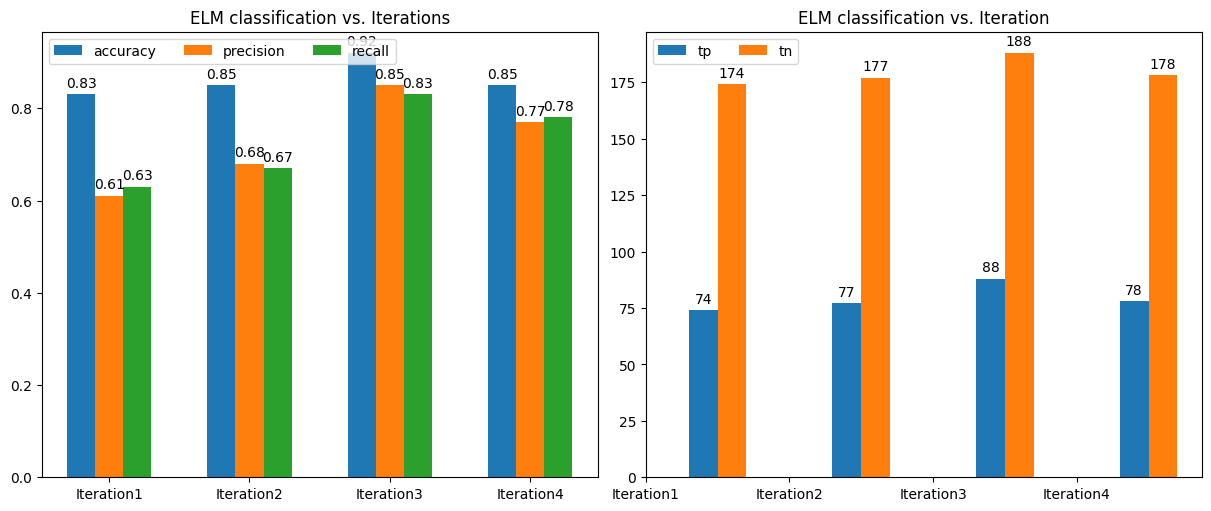

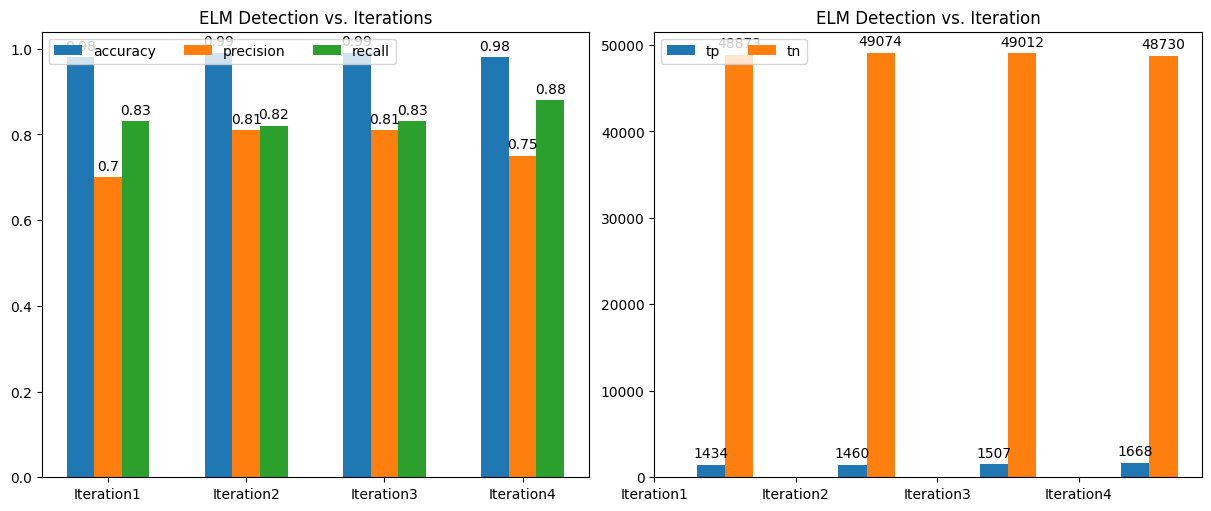

In [21]:
from utils.vis_utils import plot_bar_metrics
# Visualize classification results
plot_bar_metrics(al_cls_metrics_results, metric_type='classification', xticks_label='Iteration', figsize=(12, 5))
# Visualize detection results
plot_bar_metrics(al_det_metrics_results, metric_type='Detection', xticks_label='Iteration', figsize=(12, 5))


## 4.Active learning with Uncertainity Sampling

metric_dict